# Tools preparation

## Jupyter settings

In [1]:
#(1) change code cells width
from IPython.display import display, HTML
display(
HTML(data = """
<style>
  div#notebook-container {width: 75%;}
  div#menubar-container {width: 65%;}
  div#maintoolbar-container {width: 55%;}
</style>

"""))

#(2) display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'





#(3) pandas DataFrame displayed outpu size
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 20


# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# # Disable all GPUS
# tf.config.set_visible_devices([], 'GPU')
# visible_devices = tf.config.get_visible_devices()
# for device in visible_devices:
#     assert device.device_type != 'GPU'


## Functions and modules

pip modules

In [2]:
import os
# os.chdir(os.getcwd() + '/time_series/')
# # os.getcwd()

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import sklearn

import statsmodels as stm

import scipy.linalg as la
import scipy

import datetime
import plotnine
from plotnine import *

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib import pyplot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import scipy
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error

import copy




my own modules

In [3]:
# from modules.data_analysis        import *
# from modules.data_preparation     import *
# from modules.models               import *
# from modules.models_visualisation import *

%run "modules\\data_analysis"
%run "modules\\data_preparation"
# %run "modules\\models"
%run "modules\\models2"
%run "modules\\models_visualisation"


# Data analysis

## Data preparation

<b>Data description</b>: Data taken from yahoo finance page. Describes stocks price of General Motors (GM) and Toyota Motor (TM) companies for period of 5 year on NYSE (New York Stock Exchange). 

In [4]:

# LOADING DATA SET

# ts_var_1 = 'GM'
# ts_var_2 = 'TM'
# ts_var_3 = 'GM_Vol'
# ts_var_4 = 'TM_Vol'
# ts_var_date = 'Date'


ts_var_1 = 'var_1'
ts_var_2 = 'var_2'
ts_var_3 = 'var_3'
ts_var_4 = 'var_4'
ts_var_date = 'data'

# date_source_dir = 
ts = pd.read_csv('data/ceny_akcji.csv', delimiter=',')

# konwerja kolumny z datami na typ datowy
ts[ts_var_date] = ts[ts_var_date].astype('datetime64[ns]')

# wybor tylko potrzebnych kolumn
ts = ts[[ ts_var_date # data notowania akcji
        , ts_var_1  # wartosc akcji GM
        , ts_var_2 # wolumen akcji GM
        , ts_var_3 # Wartosc akcji TM
        , ts_var_4]] # Volumen akcji TM









# MAKING DATES COMPLETE

# Parządkuje daty wykonujący 3 rzeczy:

#(1) Uciaglam dat (braki wynikające np. ze swiąt itp.).
#(2) Zostawiam tylko podane w parametrze 'days_of_week' dni tygodnia (gdzie '0' to poniedziałek).
#(3) Szereg na początku i na końcu tak przycinam aby zaczynał się od poniedziałku (fistr_day=MO)  i kończył na pikątku (last_day=FR)
ts = data_continuity(ts, var_date=ts_var_date, var_date_new='date', days_of_week  = [0,1,2,3,4], first_day = MO, last_day = FR)
ts = ts.drop(columns = ts_var_date)
ts = ts.reset_index(drop = True)









# MISSING VALUES IMPUTATION

# Braki uzupelniam usrednionymi trzema wartosciami z 3 poprzednich odpowiednich dni tygodnia (np. brak z piątku uzupełniam srednią z trzech poprzednich piątków)

ts = imputation_backward(     ts    = ts
                            , gap   = 5
                            , n_obs = 3
                            , var_y = ts_var_1)

ts = imputation_backward(     ts    = ts
                            , gap   = 5
                            , n_obs = 3
                            , var_y = ts_var_2)

ts = imputation_backward(     ts    = ts
                            , gap   = 5
                            , n_obs = 3
                            , var_y = ts_var_3)

ts = imputation_backward(     ts    = ts
                            , gap   = 5
                            , n_obs = 3
                            , var_y = ts_var_4)

# Sprawdzam czy dalej sa braki danych
# pd.isna(ts).apply(sum, axis=0)








# FEATURE ENGINERRING

lags = [1,2,3,4,5,6,7,8]
diff_lags = [1,2]

ts = var_transform(ts, var_y = ts_var_1, n_lag = lags, diff_lag = diff_lags, log=True, inv_log=False, box_cox=True, inv_box_cox=None, normalisation=True, imputation='median')[0]
ts = var_transform(ts, var_y = ts_var_2, n_lag = lags, diff_lag = diff_lags, log=True, inv_log=False, box_cox=True, inv_box_cox=None, normalisation=True, imputation='median')[0]
ts = var_transform(ts, var_y = ts_var_3, n_lag = lags, diff_lag = diff_lags, log=True, inv_log=False, box_cox=True, inv_box_cox=None, normalisation=True, imputation='median')[0]
ts = var_transform(ts, var_y = ts_var_4, n_lag = lags, diff_lag = diff_lags, log=True, inv_log=False, box_cox=True, inv_box_cox=None, normalisation=True, imputation='median')[0]










# FEATURE ENGINEERING ON DATES

# Adding variables base on dates.
ts = date_parts_extract(    ts = ts      # zbior
                          , var_date     = 'date' # nazwa kolumny z datą w zbiorze
                          , day_of_week  = True 
                          , day_of_month = True
                          , month        = True
                          , quarter      = True
                          , week_of_year = True
                          , year         = True)


# holidays
ts.loc[ts['date'].isin(holidays),'date_if_holiday'] = 1
ts.loc[ts['date'].isin(holidays)==False,'date_if_holiday'] = 0

# days before holidays
ts['date_if_holiday_lag_1'] = ts['date_if_holiday'].shift(-1).fillna(0)
ts['date_if_holiday_lag_2'] = ts['date_if_holiday'].shift(-2).fillna(0)
ts['date_if_holiday_lag_3'] = ts['date_if_holiday'].shift(-3).fillna(0)
ts['date_if_holiday_lag_12'] = ts['date_if_holiday_lag_1'] + ts['date_if_holiday_lag_2']
ts['date_if_holiday_lag_123'] = ts['date_if_holiday_lag_1'] + ts['date_if_holiday_lag_2'] + ts['date_if_holiday_lag_3']

# end of the month
ts.loc[ts['date_day_of_month'] < 25, 'date_end_of_month'] = 0
ts.loc[ts['date_day_of_month'] >= 25,'date_end_of_month'] = 1

# christmas
ts['date_before_christm'] = (ts['date_month']==12) & (ts['date_day_of_month'] > 12) & (ts['date_day_of_month'] <= 24)
ts['date_after_christm']  = (ts['date_month']==12) & (ts['date_day_of_month'] > 26) & (ts['date_day_of_month'] <= 31)



2015-04-30 00:00:00
2020-04-29 00:00:00
2015-05-04 00:00:00
2020-04-24 00:00:00


F:\1_Programs_and_programing\DS_proj\time_series_python\modules\data_preparation.py:207: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


## Basic visualisation

### Line plots

Time series for all dates

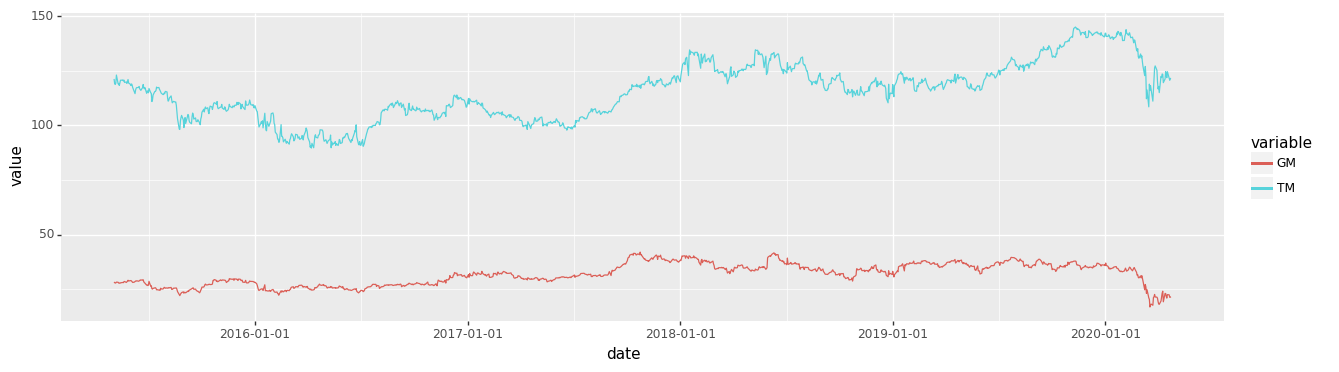

<ggplot: (121096303031)>

In [8]:
plot_line(ts = ts, var_date = 'date', vars = [ts_var_1, ts_var_2], fig_w = 15, fig_h = 4)

Timme series with zoom

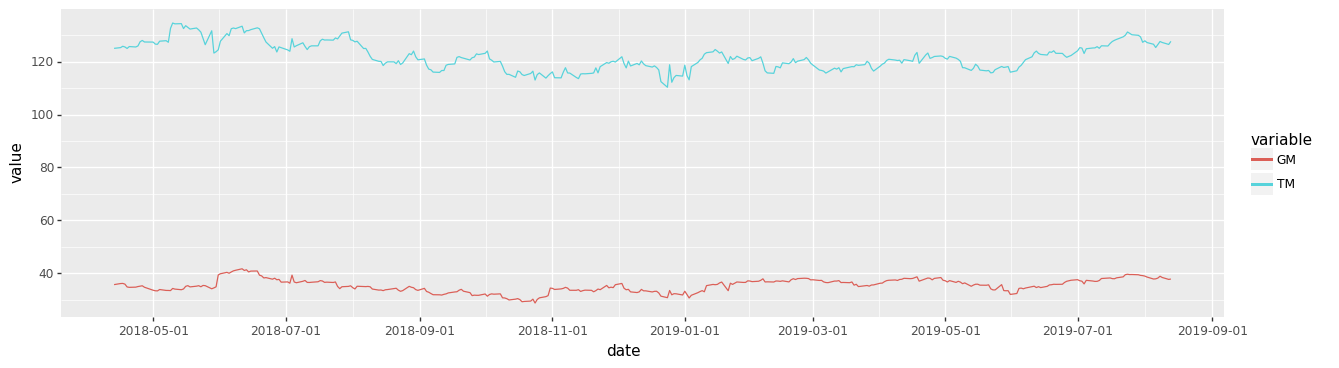

<ggplot: (121098569178)>

In [9]:
plot_line(ts = ts, var_date = 'date', vars = [ts_var_1, ts_var_2], fig_w = 15, fig_h = 4, x_lim = [datetime.datetime(2018, 4, 13), datetime.datetime(2019, 8, 13)])

### Line plot aggregated

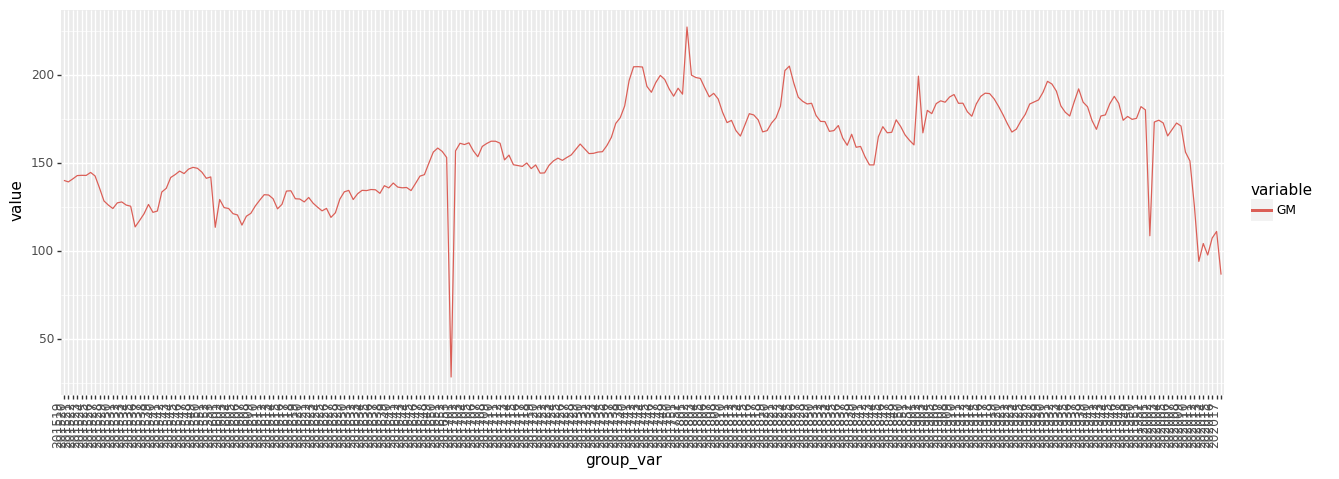

<ggplot: (121107059888)>

In [70]:
agg_fun  = 'sum'
agg_unit = 'week'
plot_line_aggregate(ts = ts, var_date = 'date', var_y = ts_var_1, unit = agg_unit, aggregate = agg_fun, labels = False,  axis_x_angle = 90, fig_h=5, fig_w=15)

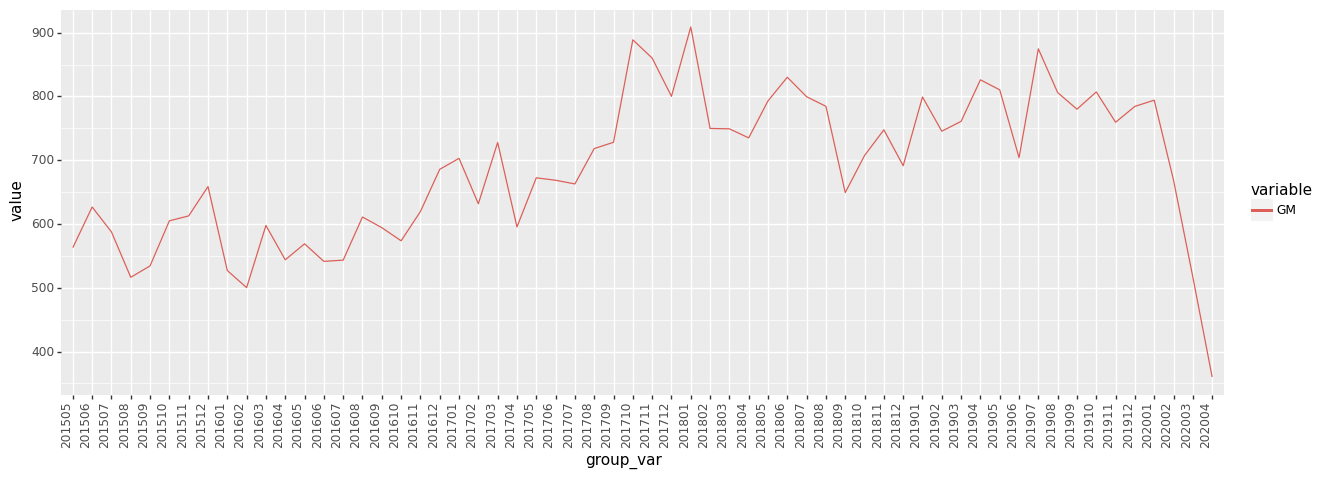

<ggplot: (-9223371915747653316)>

In [71]:
agg_fun  = 'sum'
agg_unit = 'month'
plot_line_aggregate(ts = ts, var_date = 'date', var_y = ts_var_1, unit = agg_unit, aggregate = agg_fun, labels = False,  axis_x_angle = 90, fig_h=5, fig_w=15)

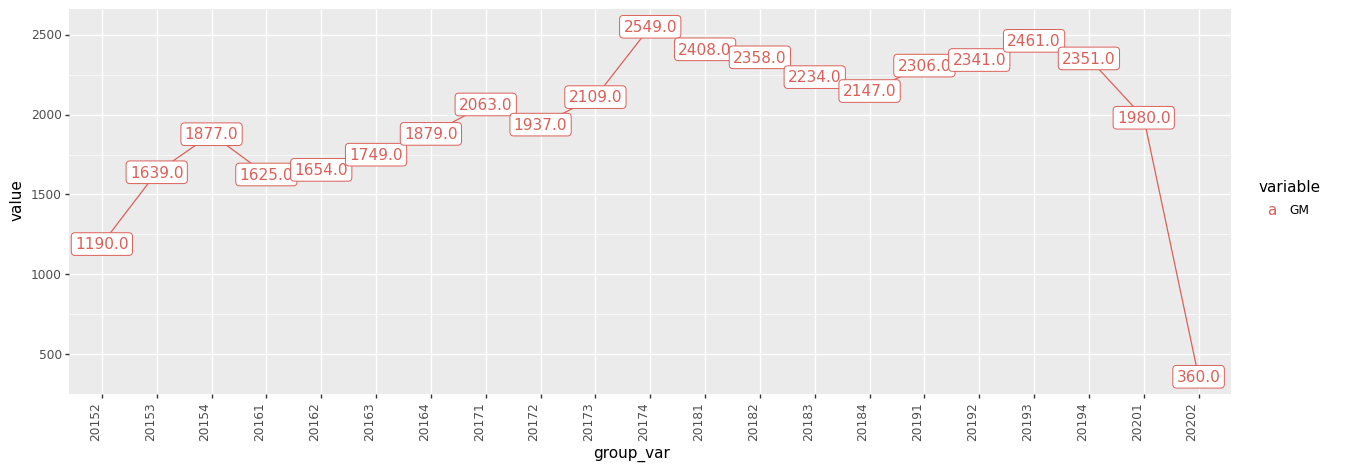

<ggplot: (121103096510)>

In [72]:
agg_fun  = 'sum'
agg_unit = 'quarter'
labels   = True
plot_line_aggregate(ts = ts, var_date = 'date', var_y = ts_var_1, unit = agg_unit, aggregate = agg_fun, labels = labels,  axis_x_angle = 90, fig_h=5, fig_w=15)

### Box plots

Box plot per week day

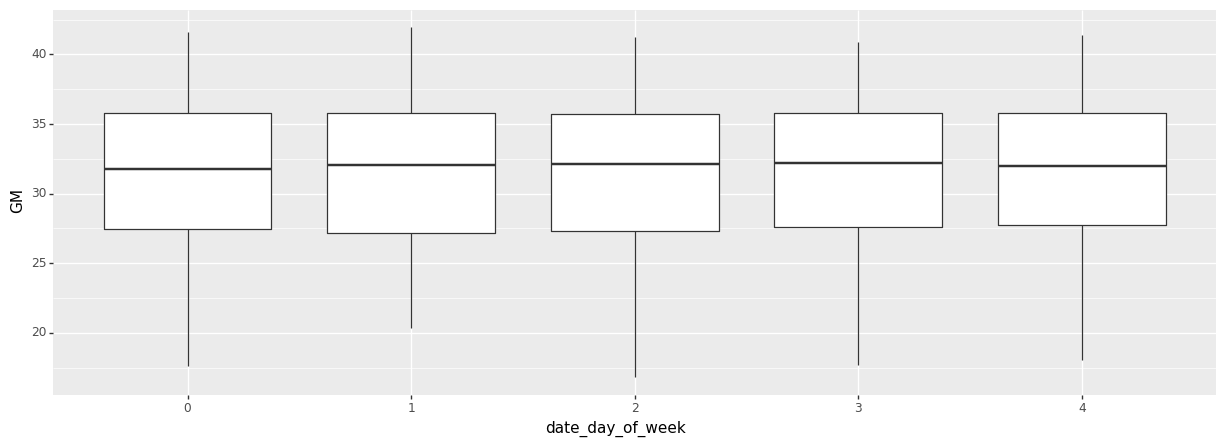

<ggplot: (-9223371915755788421)>

In [73]:
plot_box(ts = ts, var_y = ts_var_1, var_group_x = 'date_day_of_week')

Box plot per month day

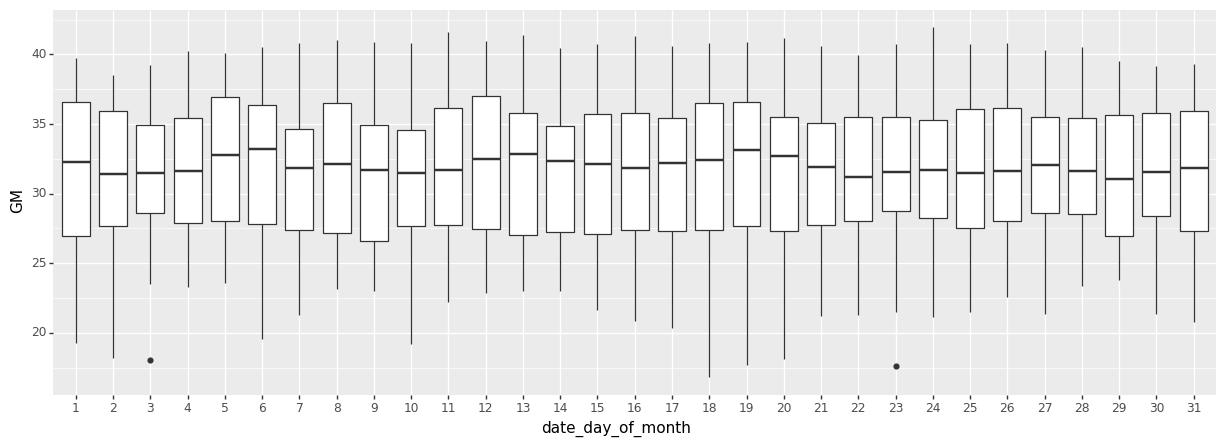

<ggplot: (-9223371915756158867)>

In [13]:
plot_box(ts = ts, var_y = ts_var_1, var_group_x = 'date_day_of_month')

Box plot per month

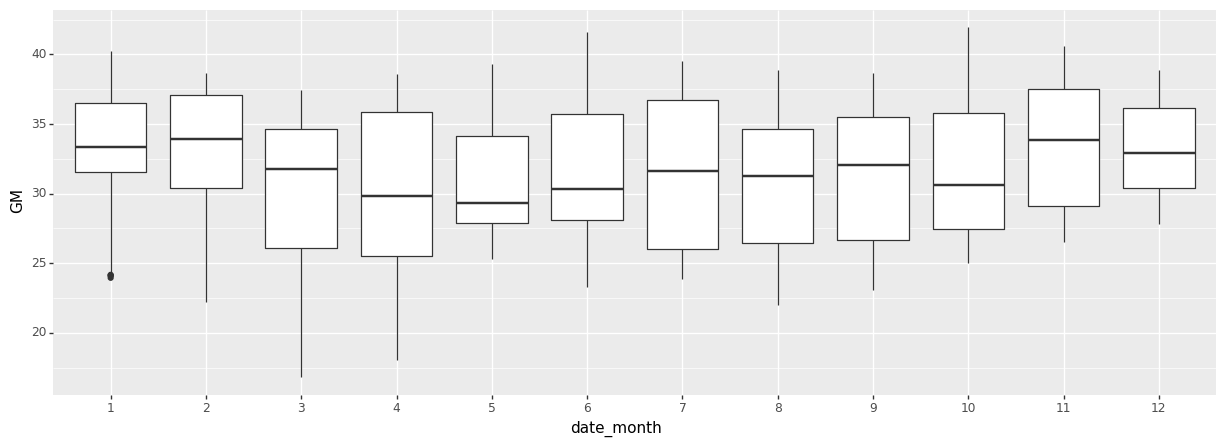

<ggplot: (-9223371915758373723)>

In [74]:
plot_box(ts = ts, var_y = ts_var_1, var_group_x = 'date_month')

Box plot per quarter group by year

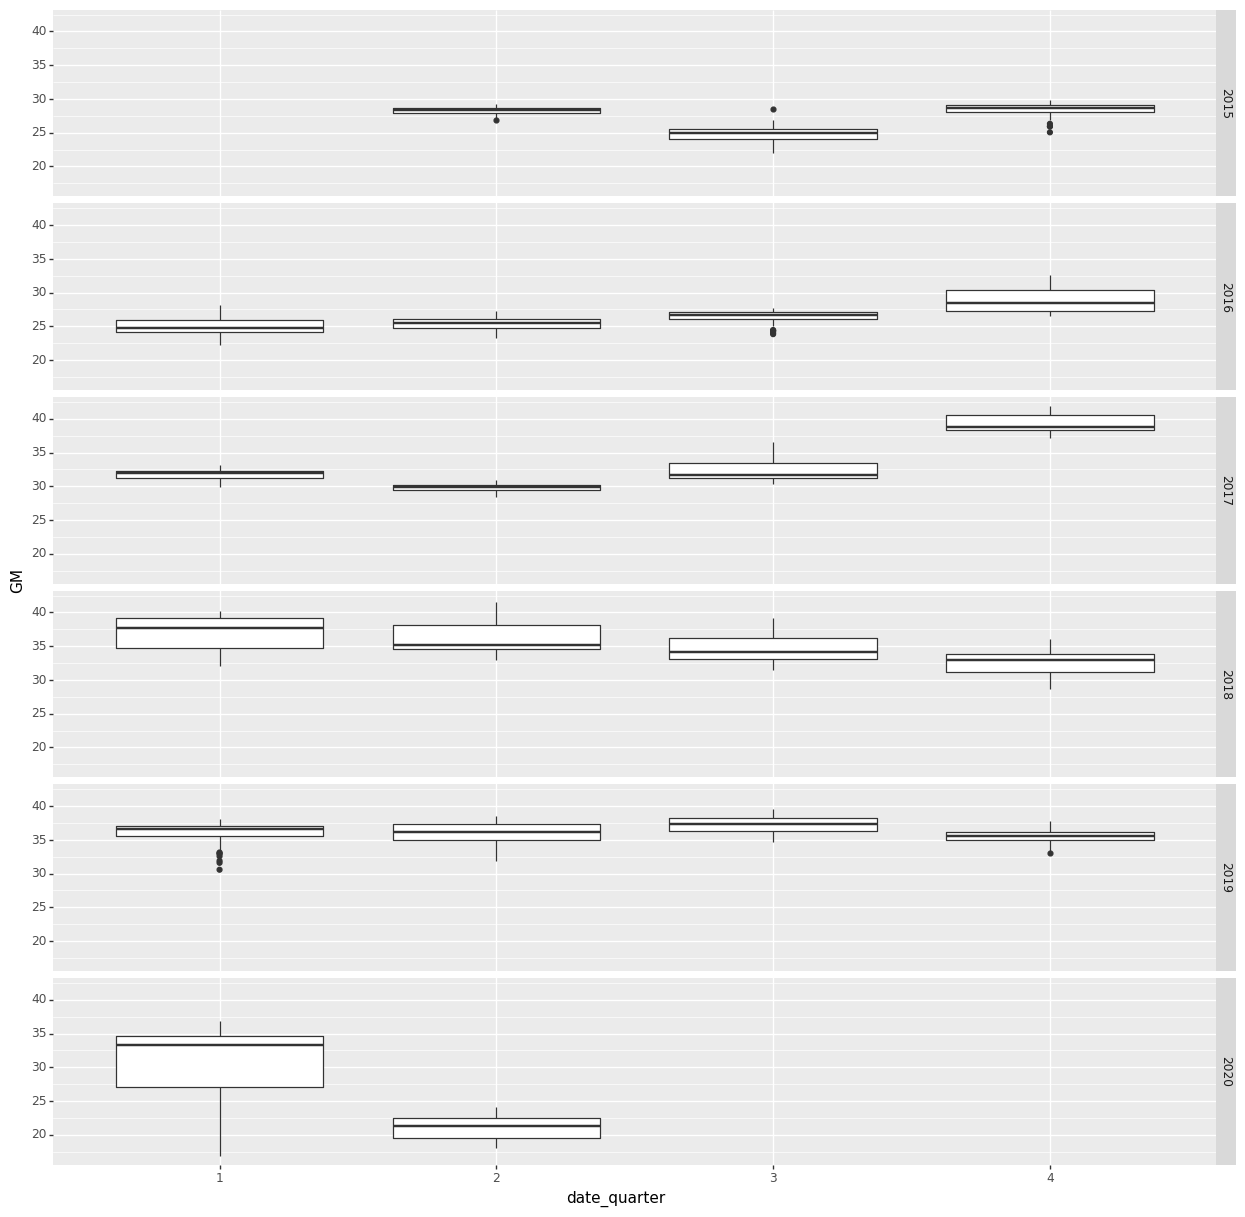

<ggplot: (121102272509)>

In [76]:
plot_box(ts = ts, var_y = ts_var_1, var_group_x = 'date_quarter', var_group_facet_y = 'date_year', fig_h = 15)

Density plot for GM per quarter

### Density plots

Density by days of week

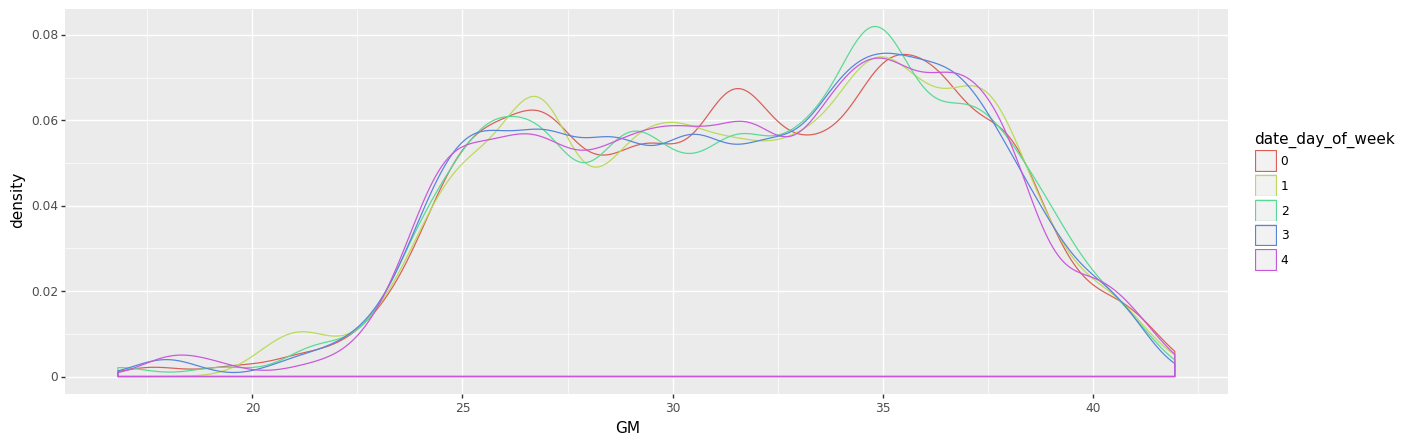

<ggplot: (121100992860)>

In [79]:
plot_density(ts = ts, var_y = ts_var_1, var_group_x = 'date_day_of_week', var_group_facet_y = None, adjust = 0.5, fig_w = 15, fig_h = 5)

Density by months

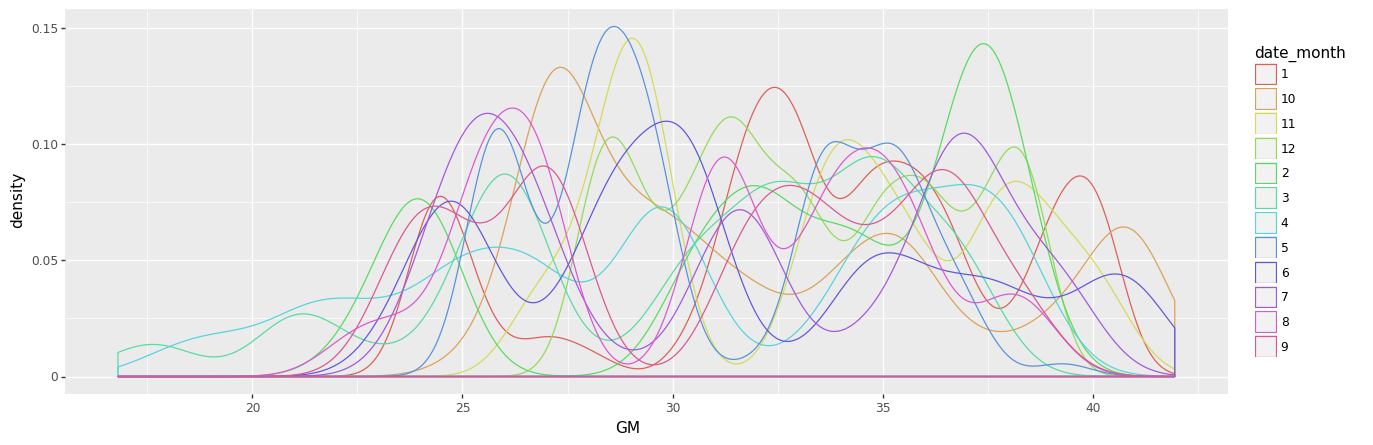

<ggplot: (121107283029)>

In [78]:
plot_density(ts = ts, var_y = ts_var_1, var_group_x = 'date_month', var_group_facet_y = None, adjust = 0.5, fig_w = 15, fig_h = 5)

Density by quarters

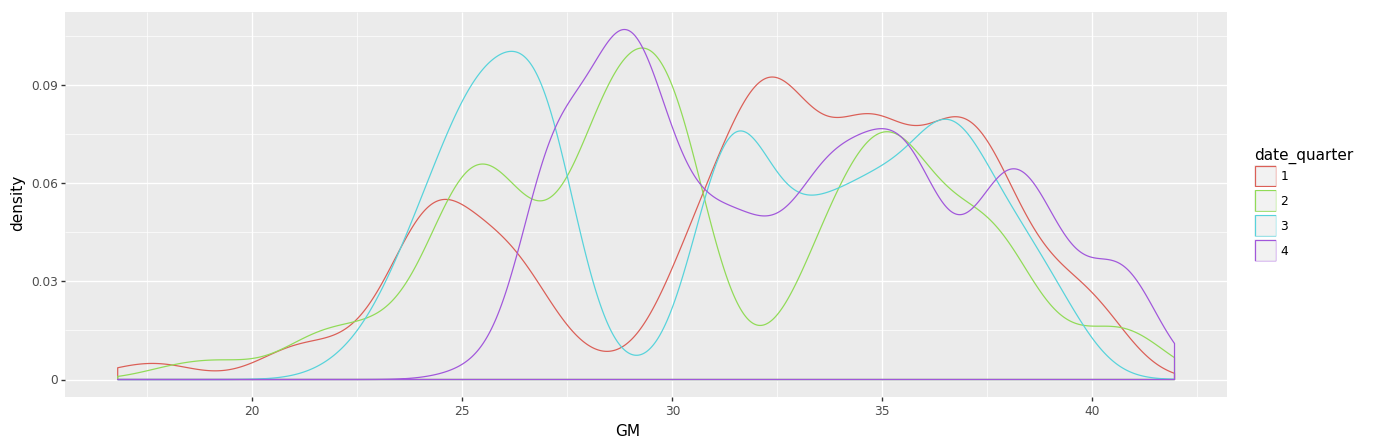

<ggplot: (144824365183)>

In [240]:
plot_density(ts = ts, var_y = ts_var_1, var_group_x = 'date_quarter', var_group_facet_y = None, adjust = 0.5, fig_w = 15, fig_h = 5)

Density by quarters grouped by year

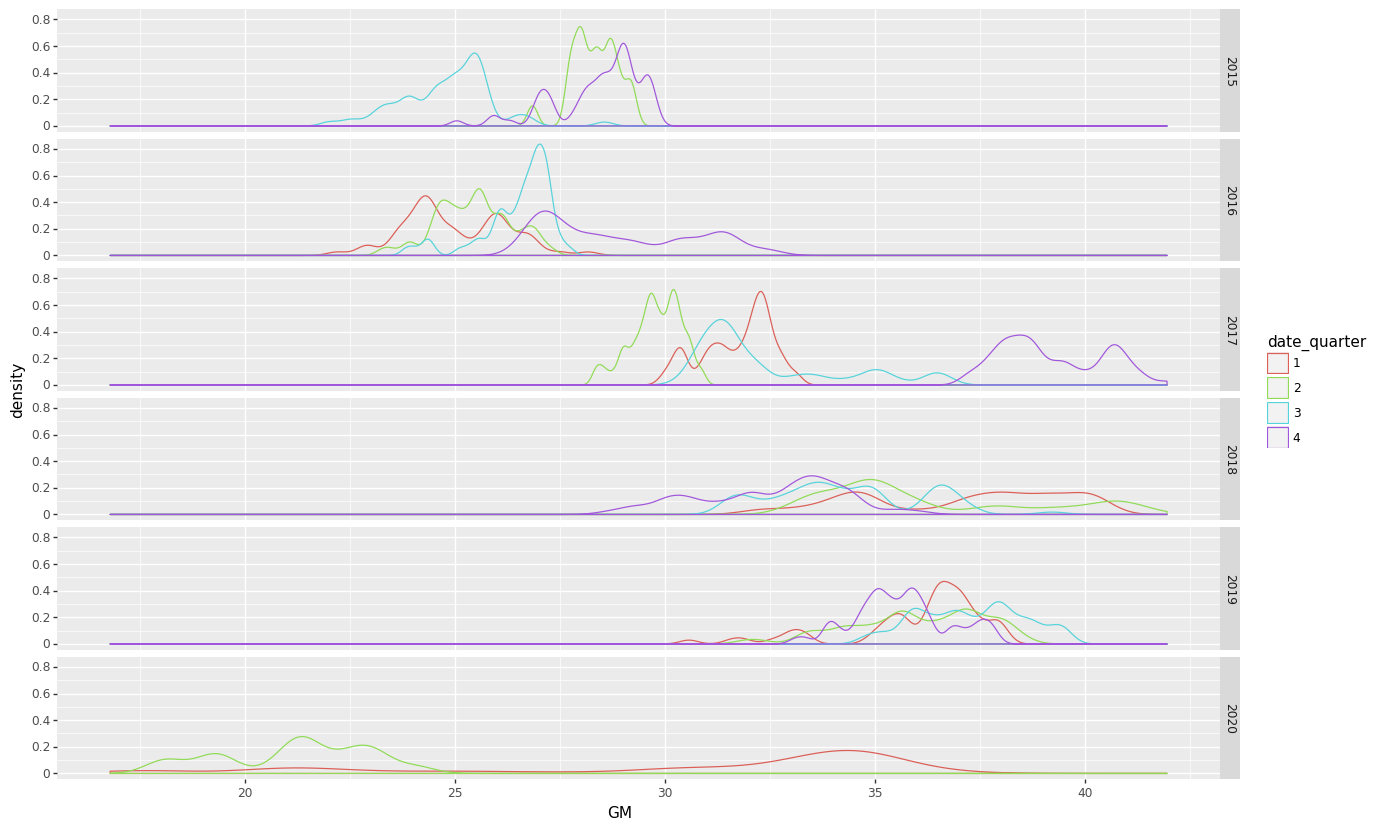

<ggplot: (-9223371915753452074)>

In [82]:
plot_density(ts = ts, var_y = ts_var_1, var_group_x = 'date_quarter', var_group_facet_y = 'date_year', adjust = 0.5, fig_w = 15, fig_h = 10)

## Stationarity

### ADF/KPSS/density/moments

RESULTS OF ADF TEST
ADF Statistic: -1.7024512255077842
p-value: 0.4298499763404045
Critical Values:
	1%: -3.435401880796999
	5%: -2.863770985550096
	10%: -2.567957791647768

 

RESULTS OF KPSS TEST:
Test Statistic            2.701354
p-value                   0.010000
Lags Used                23.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

 

        mean       std
1  28.492584  3.509163
2  34.960097  4.010374


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value


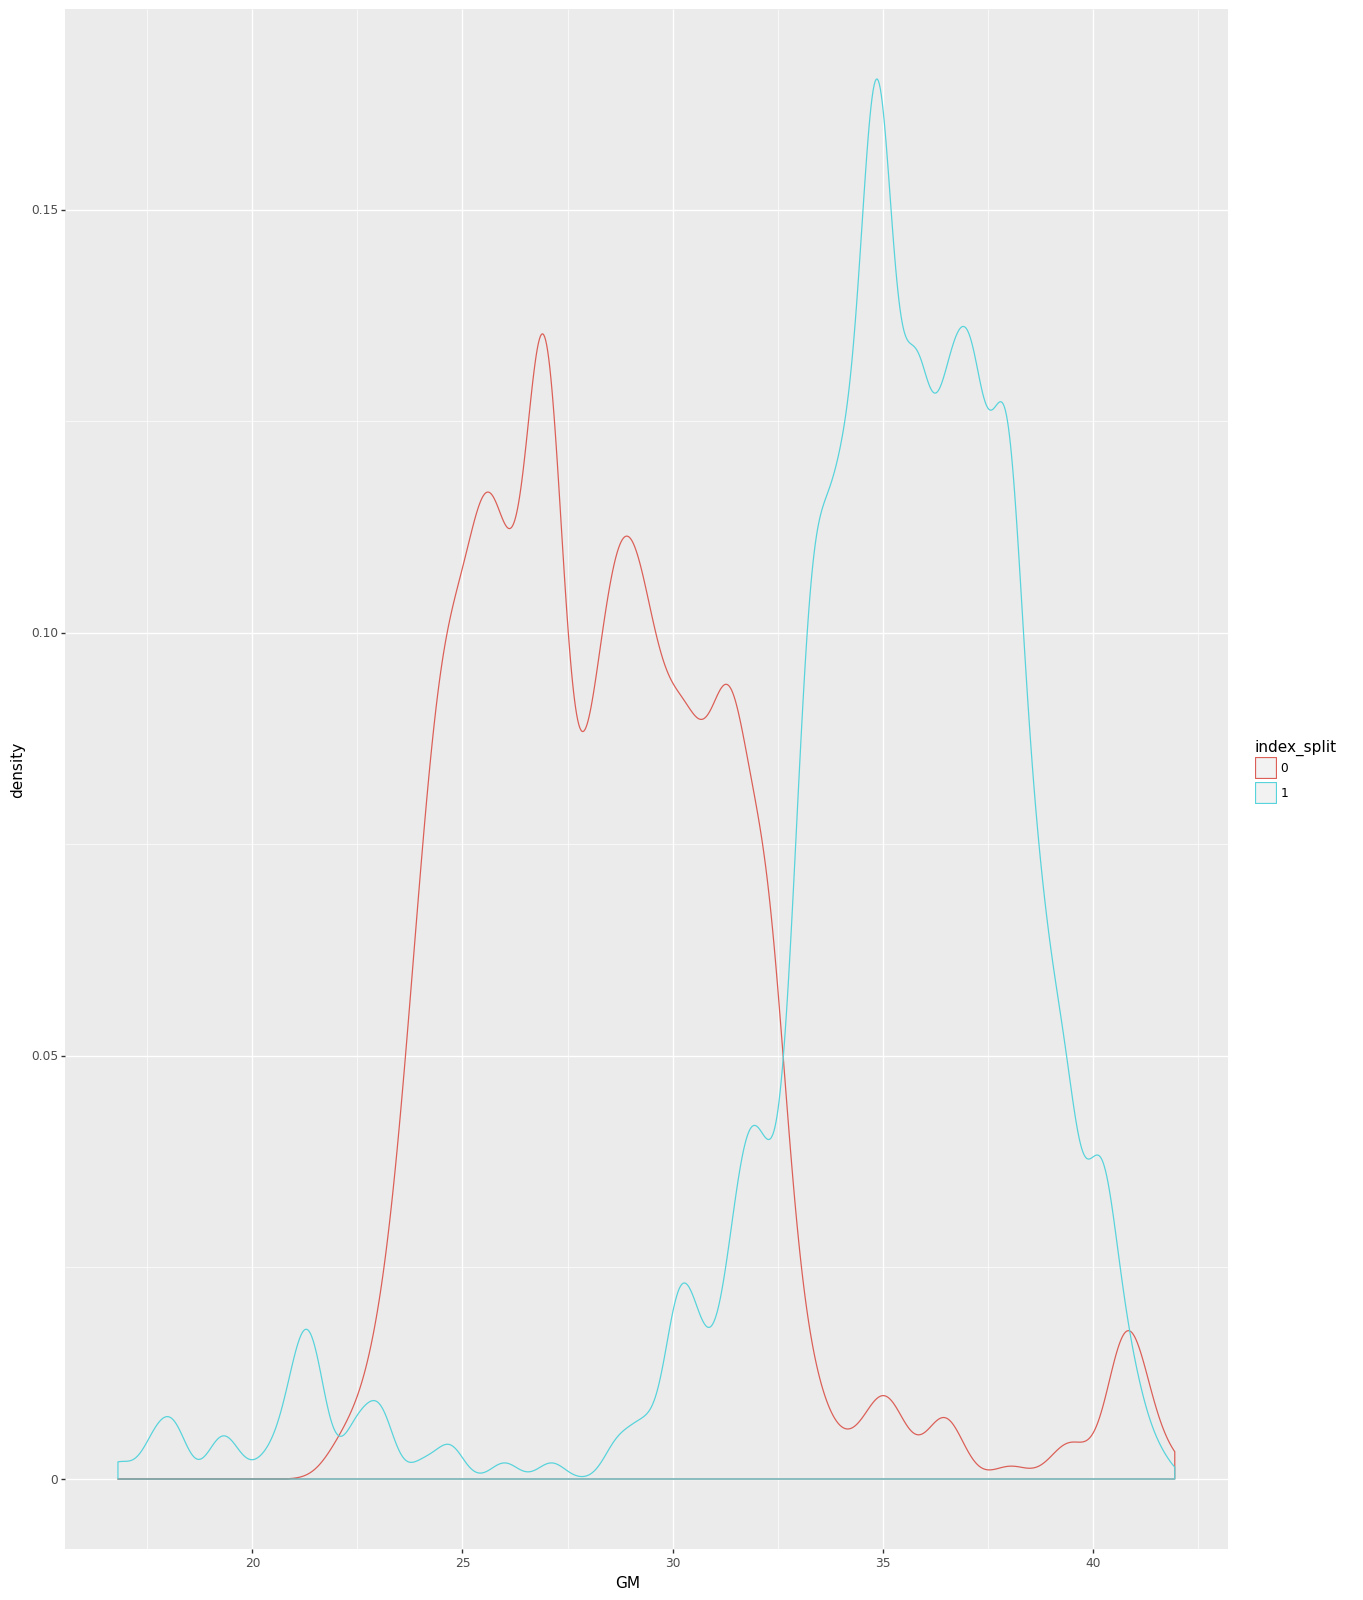

<ggplot: (-9223371915754151150)>

In [15]:
stationarity(ts=ts, var_y = ts_var_1, ts_split=2)

### ARCH EFFECT

In [110]:
pd.DataFrame({ 'stats':['Lagrange multiplier test statistic','p-value for Lagrange multiplier test','fstatistic for F test','pvalue for F test']
              ,'value':stm.stats.diagnostic.het_arch(ts[ts_var_1], nlags=None, autolag=None, store=False, ddof=0 ) }).round(5)

stats       value
0    Lagrange multiplier test statistic  1252.81978
1  p-value for Lagrange multiplier test     0.00000
2                 fstatistic for F test  2942.03338
3                     pvalue for F test     0.00000

## Autocorrelation

### ACF-PACF

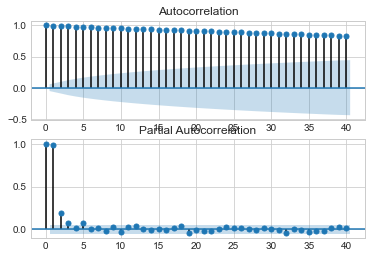

In [185]:
acf_pacf(ts = ts, var_y = ts_var_1, lags = 40)


### Lagged plot

C:\Users\memy\Anaconda3\lib\site-packages\plotnine\layer.py:449: UserWarning: geom_point : Removed 15 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


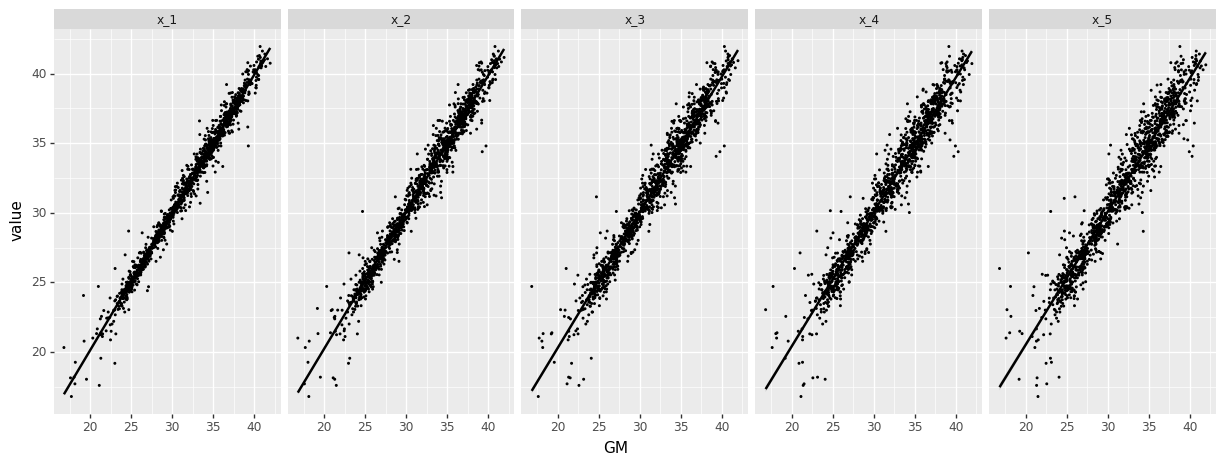

<ggplot: (-9223371892029921248)>

In [243]:
lagged_plot(ts = ts , var_y = ts_var_1, lags = [1,2,3,4,5], x_lims = (np.nan,np.nan))

### Periodogram

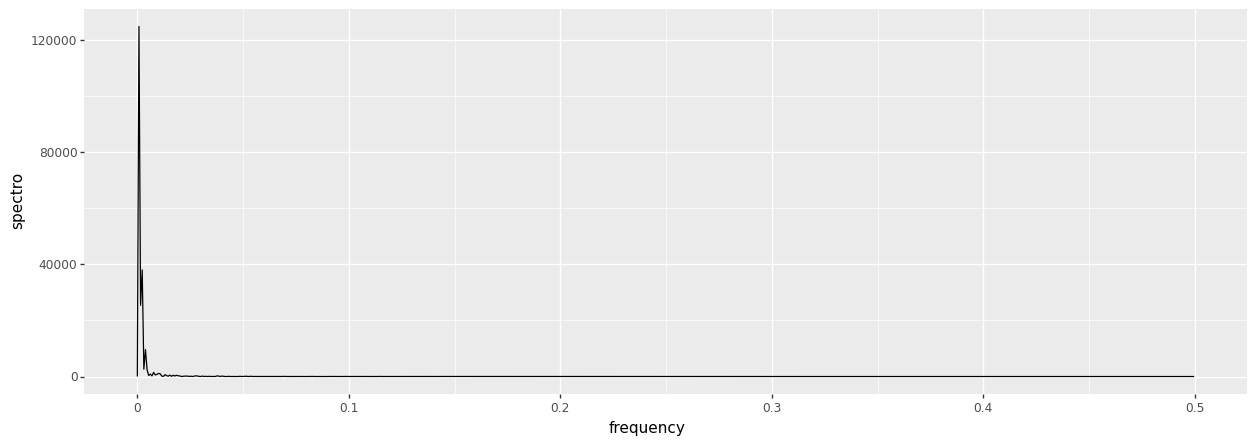

<ggplot: (-9223371897442069437)>

In [195]:
periodogram(ts = ts, var_y = ts_var_1, fs=1.0, detrend='constant', window = None, fig_w=15, fig_h=5)

## Two time series correlation

### Cross correlation

In [16]:
cross_correlation(ts, var_y1 = ts_var_1, var_y2=ts_var_2, lags = 10)

GM      1.00
TM      0.67
TM_0    0.67
TM_1    0.67
TM_2    0.66
TM_3    0.65
TM_4    0.65
TM_5    0.64
TM_6    0.63
TM_7    0.63
TM_8    0.62
TM_9    0.62
Name: GM, dtype: float64

### Window lagged correlation

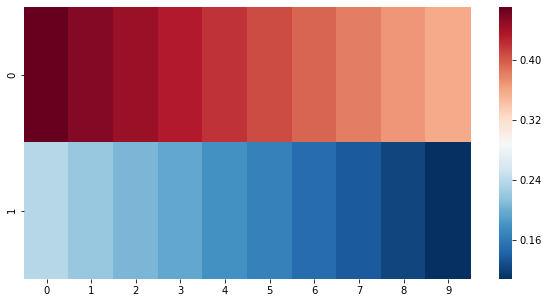

In [17]:
window_lagged_correlation(ts = ts
                              , var_y1 = ts_var_1
                              , var_y2 = ts_var_2
                              , lags=10
                              , no_splits = 2)

### Granger casuality test

In [18]:
granger_test(ts, var_y1 = ts_var_1, var_y2 = ts_var_2, max_lag = 7)


GM vs TM


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4830  , p=0.2235  , df_denom=1295, df_num=1
ssr based chi2 test:   chi2=1.4864  , p=0.2228  , df=1
likelihood ratio test: chi2=1.4855  , p=0.2229  , df=1
parameter F test:         F=1.4830  , p=0.2235  , df_denom=1295, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7881  , p=0.1677  , df_denom=1292, df_num=2
ssr based chi2 test:   chi2=3.5901  , p=0.1661  , df=2
likelihood ratio test: chi2=3.5851  , p=0.1665  , df=2
parameter F test:         F=1.7881  , p=0.1677  , df_denom=1292, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2821  , p=0.2790  , df_denom=1289, df_num=3
ssr based chi2 test:   chi2=3.8672  , p=0.2762  , df=3
likelihood ratio test: chi2=3.8614  , p=0.2768  , df=3
parameter F test:         F=1.2821  , p=0.2790  , df_denom=1289, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8

## Cointegration

### Test

In [19]:
results = statsmodels.tsa.stattools.coint(y0=ts[ts_var_1], y1=ts[ts_var_2], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)

# The null hypothesis is: no cointegration

print('The t-statistic of unit-root test on residuals  ' + str(results[0]))
print('p-value  ' + str(results[1]))
print('Critical values for the test statistic at the 1 %, 5 %, and 10 %  ' + str(results[2]))

The t-statistic of unit-root test on residuals  -1.4137110058950824
p-value  0.7927748521515411
Critical values for the test statistic at the 1 %, 5 %, and 10 %  [-3.90489742 -3.34084137 -3.0477191 ]


### Selecting rank

For Vecm model

In [20]:
# https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618?gi=6517fb80f372
vec_rank = statsmodels.tsa.vector_ar.vecm.select_coint_rank(ts[[ts_var_1,ts_var_2]], det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          14.39          23.15
-------------------------------------


## Outliers

https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

### Isolation Forest

IsolationForest(contamination=0.02)

C:\Users\memy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\memy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


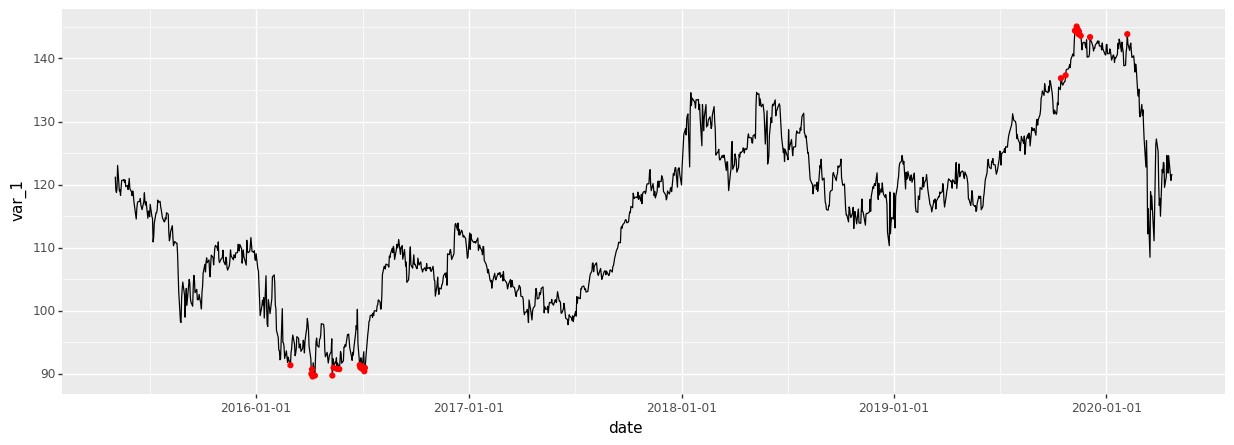

<ggplot: (-9223371897442118228)>

In [173]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

df = ts[[ts_var_1]]

data = df
# normalizacja danych
scaler    = StandardScaler()
np_scaled = scaler.fit_transform(data)
data      = pd.DataFrame(np_scaled)

# trenowanie modelu
outliers_fraction = 0.02 # zakladam ze jest 5 procent outliersow
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

# # znacznik outliers-ow
df['outlier'] = pd.Series(model.predict(data))
df['date'] = ts[['date']]

# # wizualizacja
plotnine.options.figure_size = (15, 5)
(ggplot()+geom_line(data = df, mapping = aes(x='date', y=ts_var_1)) + geom_point(data=df[df['outlier']==-1], mapping=aes(x='date', y = ts_var_1), color = 'red' ) )

### Bollinger bands

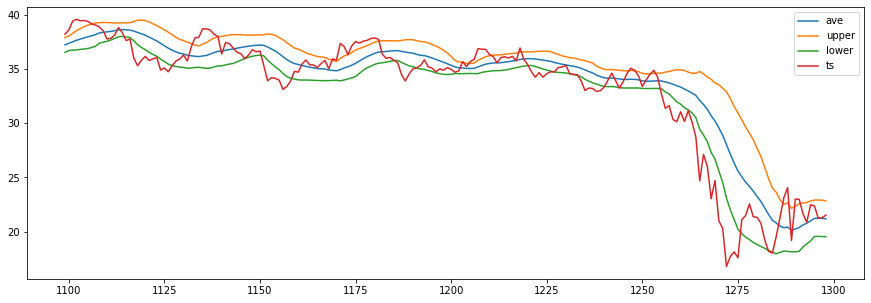

In [9]:
def bbands(ts, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    ave = ts.rolling(length, min_periods=1).mean()
    sd = ts.rolling(length, min_periods=1).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

sp=pd.DataFrame()
sp['ave'], sp['upper'], sp['lower'] = bbands(ts[ts_var_1], length=20, numsd=1)
sp['ts']=ts[ts_var_1]
sp[-200:].plot(figsize=(15,5))





## Filtering and decomposition

### Dynamic PCA (singular spectral analysis)

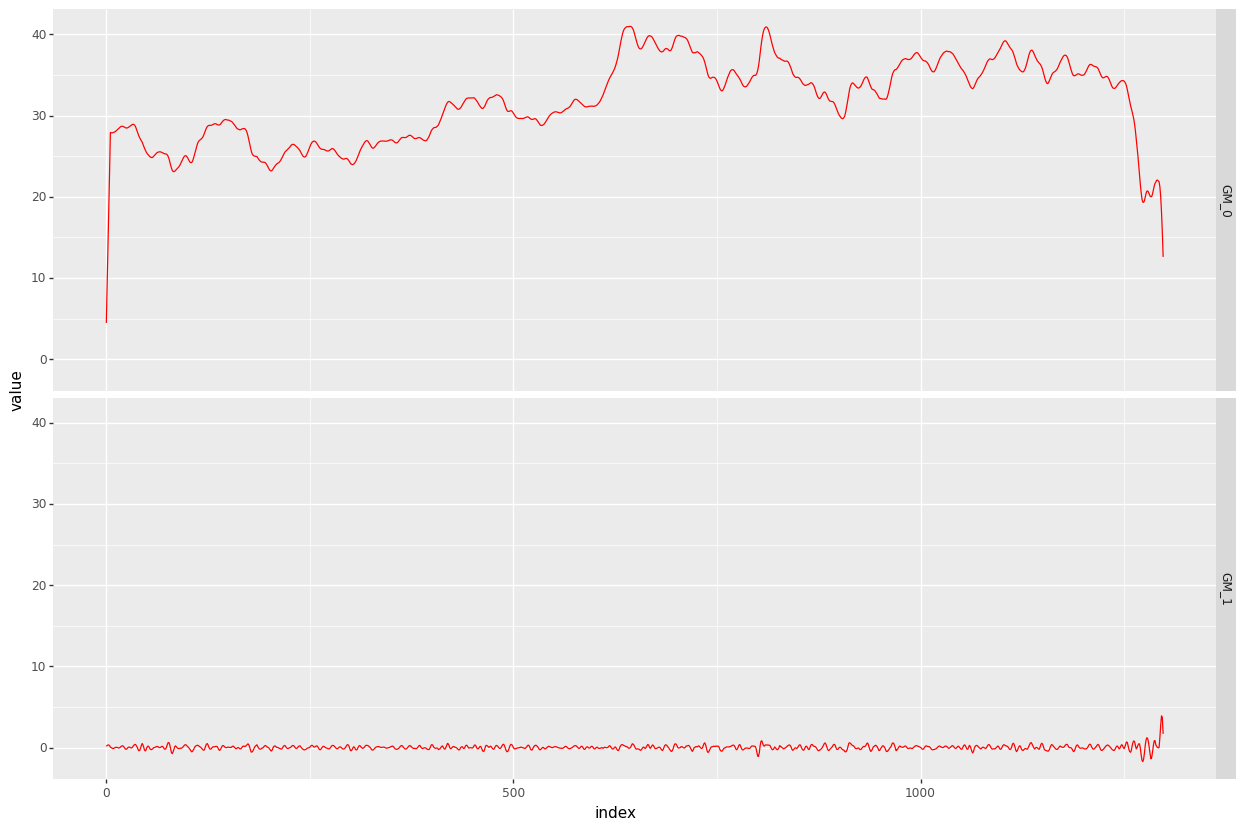

<ggplot: (121099567624)>

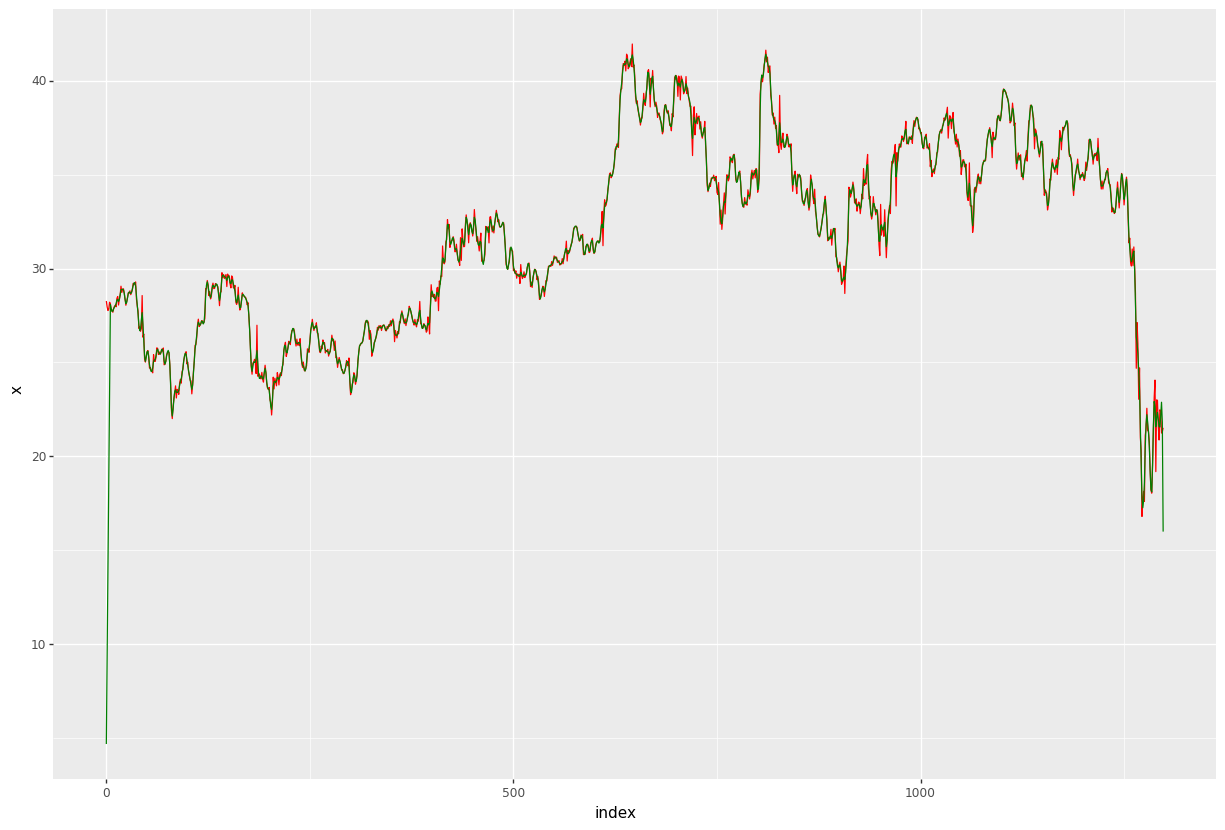

<ggplot: (-9223371915753649881)>

In [86]:

ts_sa = pd.DataFrame({ts_var_1:ts[ts_var_1]})

s1 = singular_spectral_analysis()

s1.decompose(time_series=ts_sa, k=5, x_name=ts_var_1)

# s1.time_series
# s1.reconstruction

# dekompozycja 2 komponenty o najwyzszym stopniu wyjansniania wariancji
s1.plot_decomposition(components_inicies=[0,1])

# zagregowane 3 komponenty o najwyzszym stopniu wyjasniania wariancji vs szereg bazowy
s1.filter(components_inicies = [0,1,2])
s1.plot_filter_vs_base()



### Seasonal decomposition

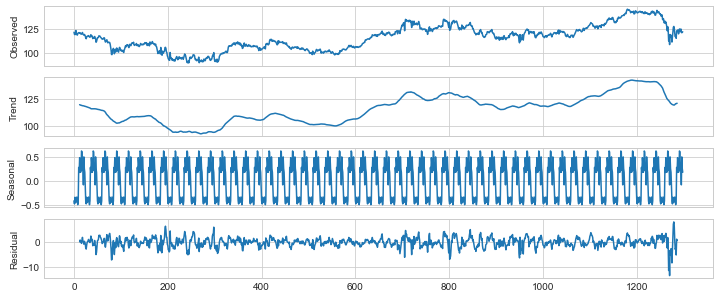

In [193]:
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import statsmodels.api as sm

result = seasonal_decompose(ts[ts_var_1], model='additive', period=25)
    
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,5))
plot_small_statsmodels(result, axes)


### Hodrick–Prescott

https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter (teoria)

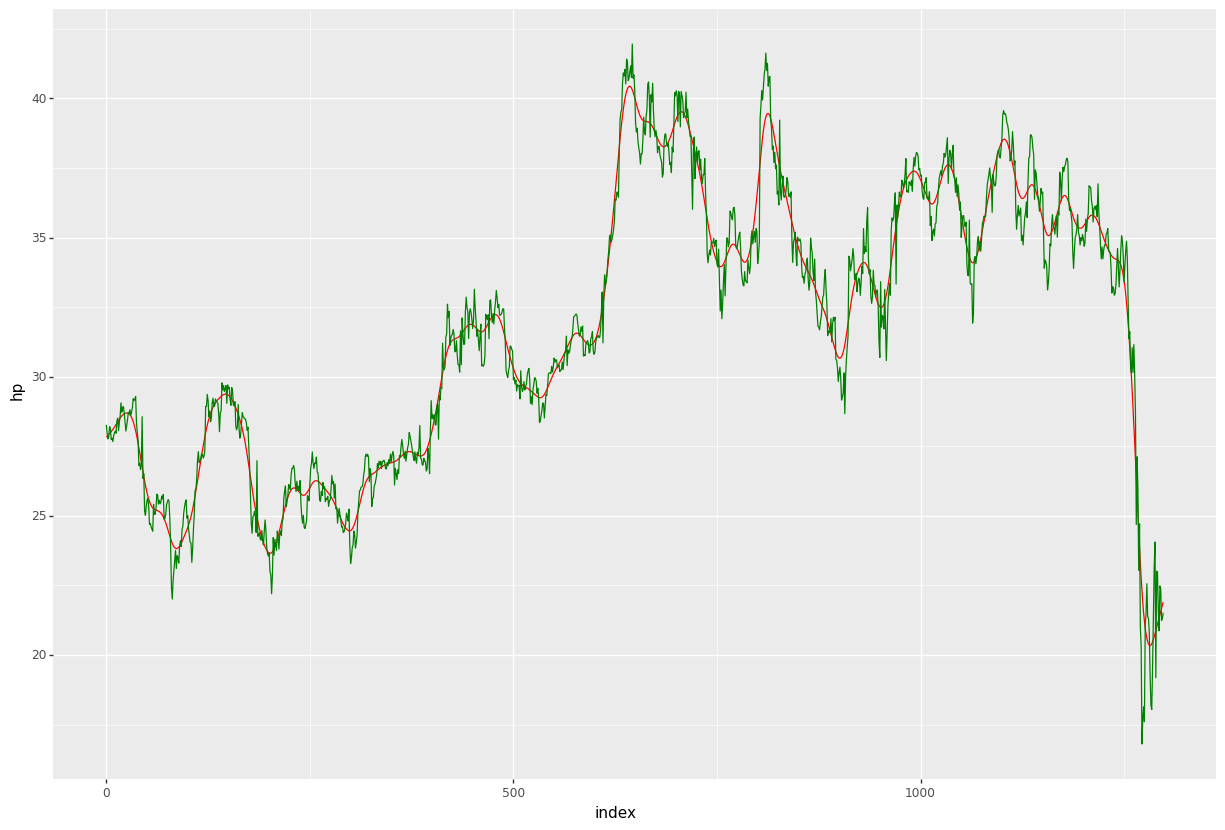

<ggplot: (121106421098)>

In [26]:
hp = stm.tsa.filters.hp_filter.hpfilter(x=ts[ts_var_1], lamb = 1600) # 1600 for quarters

x_comparision = pd.DataFrame({'hp':hp[1],'ts':ts[ts_var_1]})
x_comparision = x_comparision.reset_index(drop=True)
x_comparision = x_comparision.reset_index(drop=False)

ggplot(data=x_comparision) + geom_line(aes(x='index', y='hp'), color = 'red') + geom_line(aes(x='index', y='ts'), color = 'green')

### Christiano Fitzgerald asymmetric, random walk filter

https://rdrr.io/cran/mFilter/man/cffilter.html

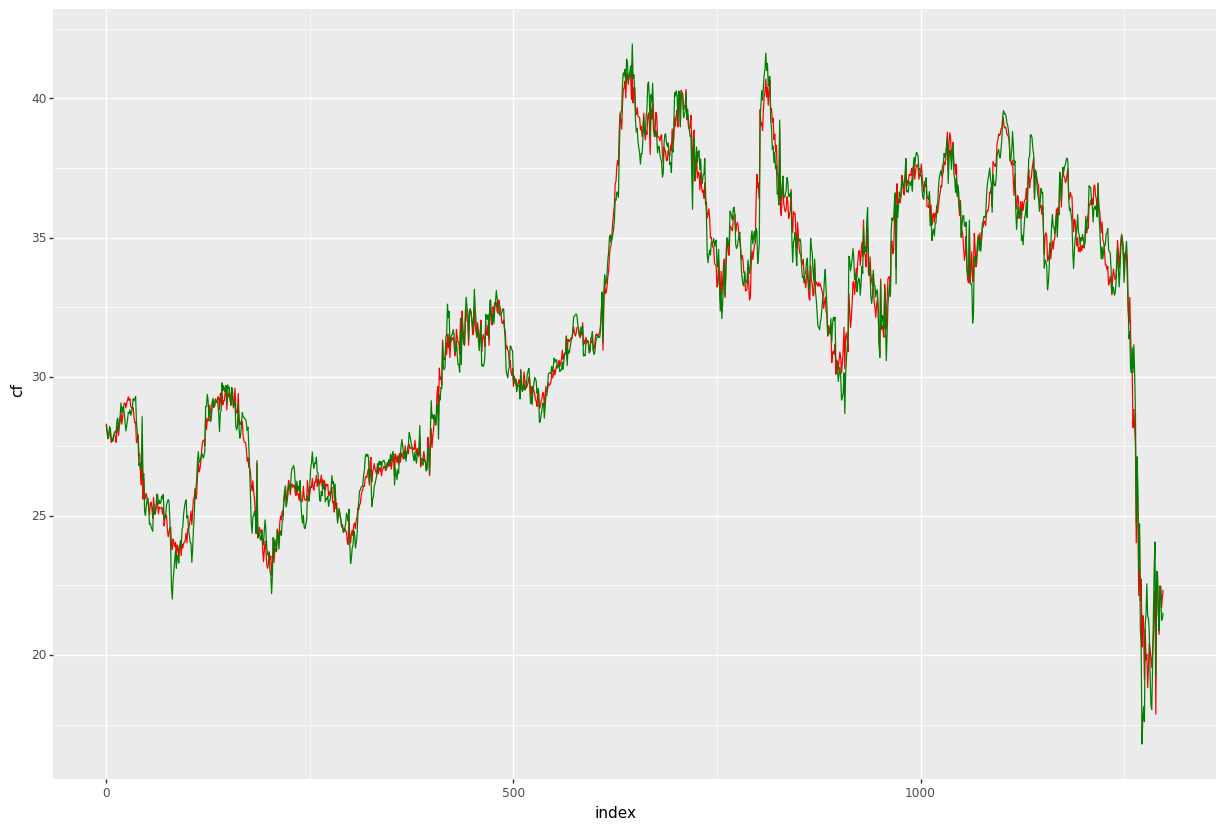

<ggplot: (-9223371915751711470)>

In [27]:
cf = stm.tsa.filters.cf_filter.cffilter(ts[ts_var_1], low=6, high=32, drift=False)

x_comparision = pd.DataFrame({'cf':cf[1],'ts':ts[ts_var_1]})
x_comparision = x_comparision.reset_index(drop=True)
x_comparision = x_comparision.reset_index(drop=False)
ggplot(data=x_comparision) + geom_line(aes(x='index', y='cf'), color = 'red') + geom_line(aes(x='index', y='ts'), color = 'green')

### LOESS

https://blogs.sas.com/content/iml/2016/10/17/what-is-loess-regression.html (teoria) <br>
https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html (dokumentacja statsmodels)

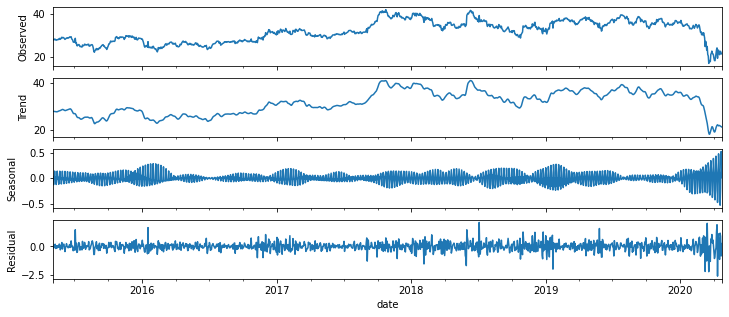

In [13]:
t1 = ts[ts_var_1]
t1.index = ts['date']

stl = stm.tsa.seasonal.STL(t1, seasonal=25)
res = stl.fit()


fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,5))
plot_small_statsmodels(res, axes)


# Model building

Global settings

In [6]:
pred_len = 5
pred_n  = 4
aggregation = 'day' # day
fig_w = 15
fig_h = 5 

## Smoothing

### Exponentian smoothing

1.0
1.0
1.0
1.0
1
1.0
1.0
1.0
1.0
2
1.0
1.0
1.0
1.0
3


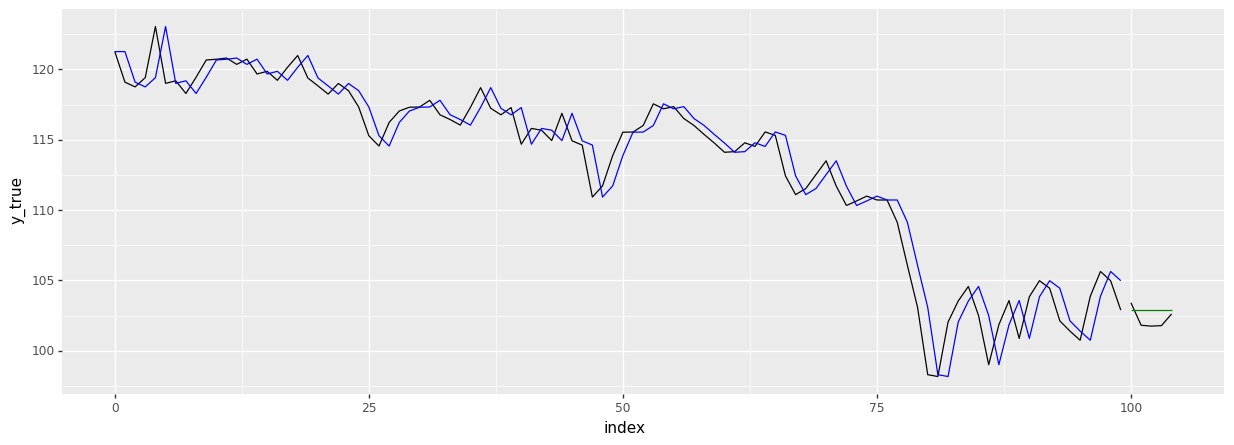

<ggplot: (161994301851)>

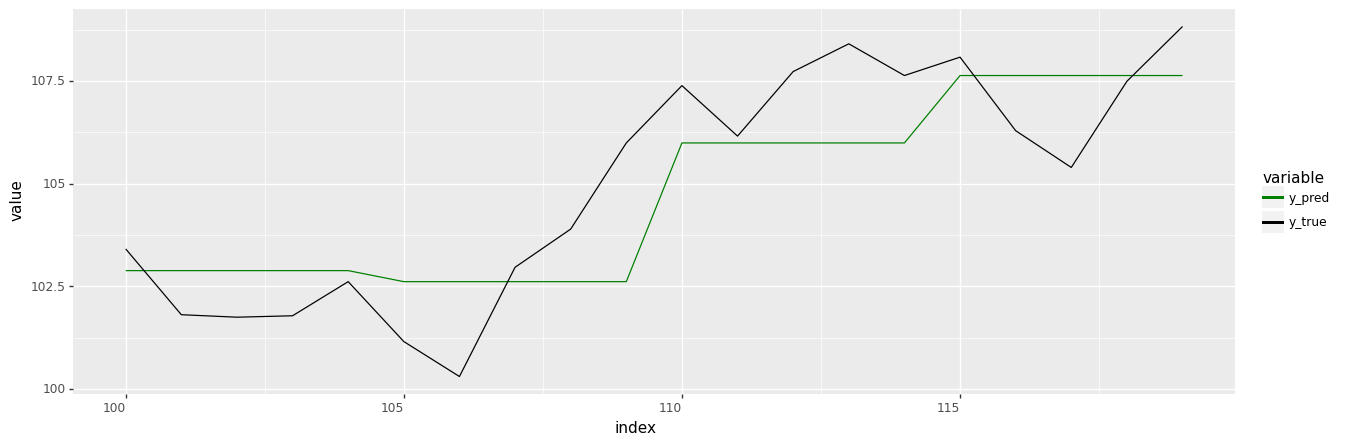

<ggplot: (161868135709)>

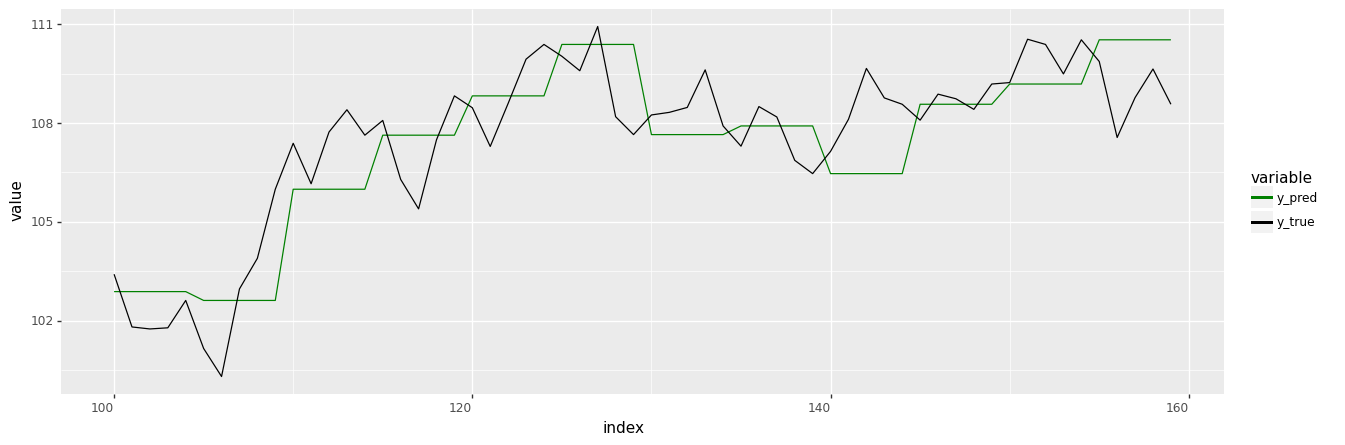

<ggplot: (161997356352)>

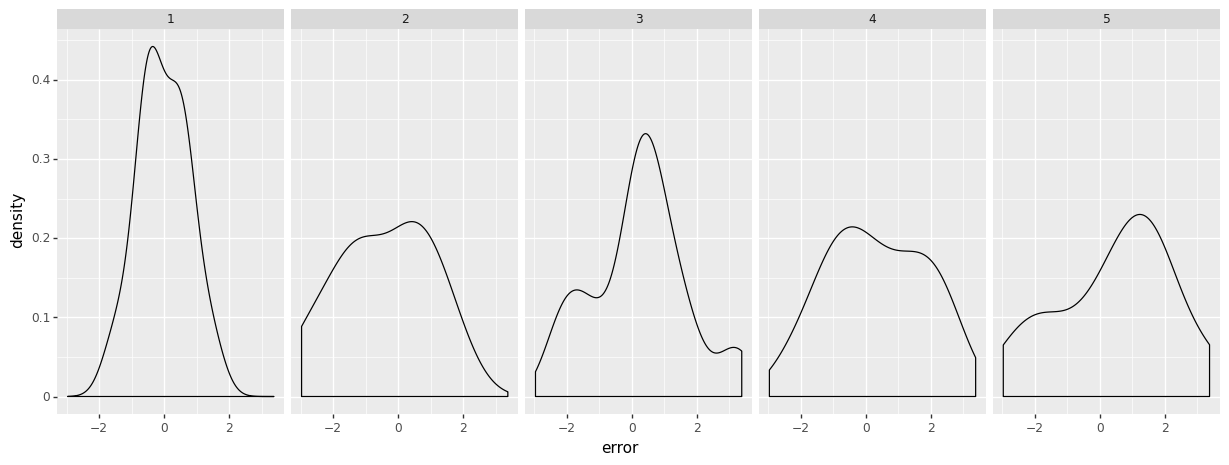

<ggplot: (-9223371874860605373)>

index    metric
0    mean_absolute_error_  1.157967
1  median_absolute_error_  1.086659
2     mean_squared_error_  2.027899

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  12.80661
1  p-value for Lagrange multiplier test   0.30615
2                 fstatistic for F test   1.19018
3                     pvalue for F test   0.32711

Null hypothesis: residuals are not autocorrelated
Statistic values:
[16.84389 17.22913 17.25215 18.00836 19.38    21.32814 25.17078 26.99826
 27.36962 30.37405 32.44917 32.58624 35.58272 39.1002  44.58807 49.74715
 50.37992 50.93528 51.09068 51.09485 51.12444 51.17766 51.27213 51.29848
 53.72299 57.44341 57.63816 59.86691]
p-values:
[4.00e-05 1.80e-04 6.30e-04 1.23e-03 1.63e-03 1.60e-03 7.10e-04 7.10e-04
 1.21e-03 7.40e-04 6.50e-04 1.12e-03 6.90e-04 3.50e-04 9.00e-05 3.00e-05
 4.00e-05 5.00e-05 9.00e-05 1.50e-04 2.50e-04 4.10e-04 6.30e-04 9.60e-04
 7.20e-04 3.70e-04 5.30e-04 4.20e-04]


Null hypothesis: residuals are independent


stats                   value
0  BDS statistic        4.75058143953661
1       p-values  2.0283258458539606e-06

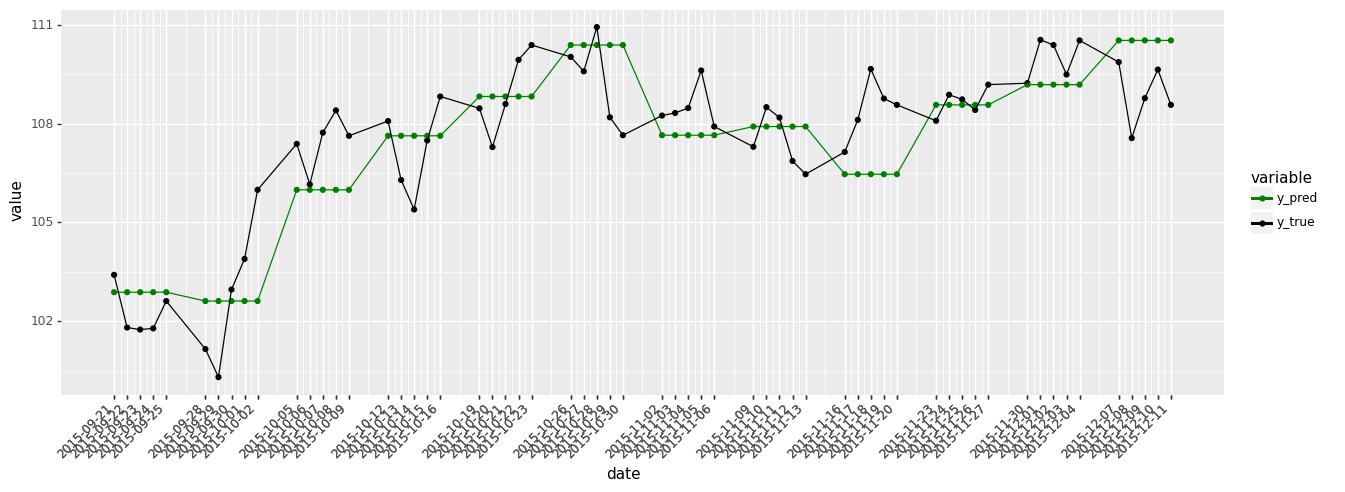

<ggplot: (161997212280)>

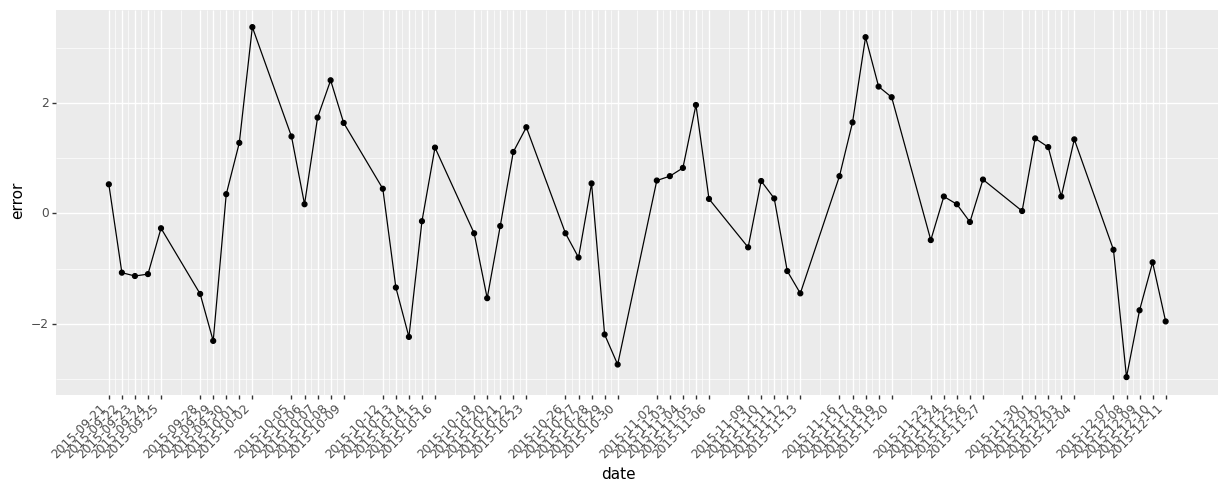

<ggplot: (161867173317)>

0
mean_error_true                0.010790
mean_error_pred                0.010808
mean_error_true_weighted_true  0.010771
mean_error_pred_weighted_pred  0.010783
median_error_true              0.010344
median_error_pred              0.010341
std_error                      0.007732
mean_error_squared             0.010783

In [47]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min




# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = pred_len           # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )

# MODEL
res = smoothing(   ts               = ts
                 , var_y            = ts_var_1
                 , method           = 'simple_exponential' # other values: 'holt', 'holt_winters'
                 , TS_idx           = TS_idx
                 , smoothing_level  = None
                 , optimized        = True
                 , model_name       = 'SIMPLE_SMOOTH_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S")
                 , damped           = False
                 , trend            = 'add'
                 , seasonal         = 'add'
                 , seasonal_periods = 5
                )

# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')
test_BSD(res)


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]



### Holt

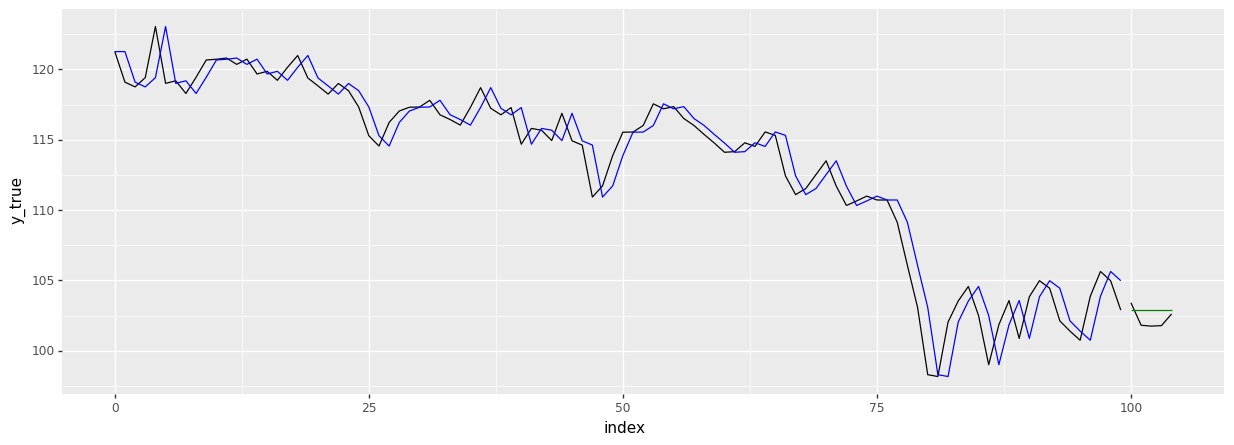

<ggplot: (161867204935)>

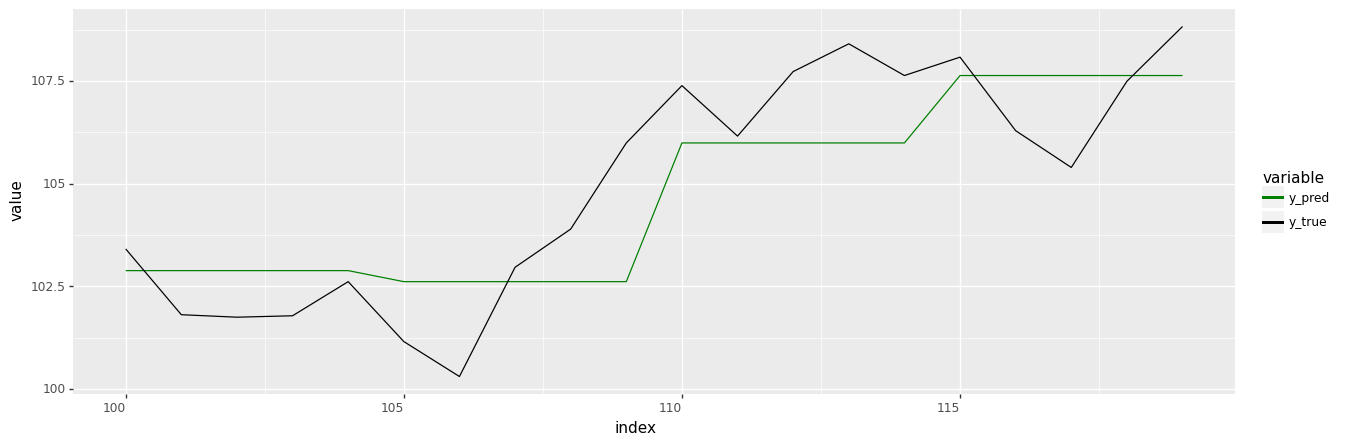

<ggplot: (-9223371874987275534)>

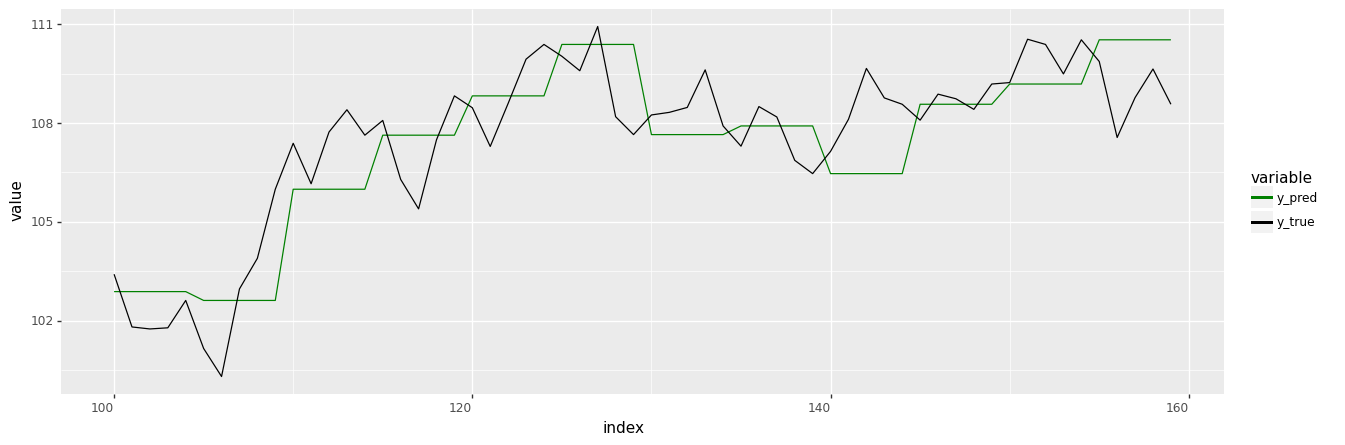

<ggplot: (161994100172)>

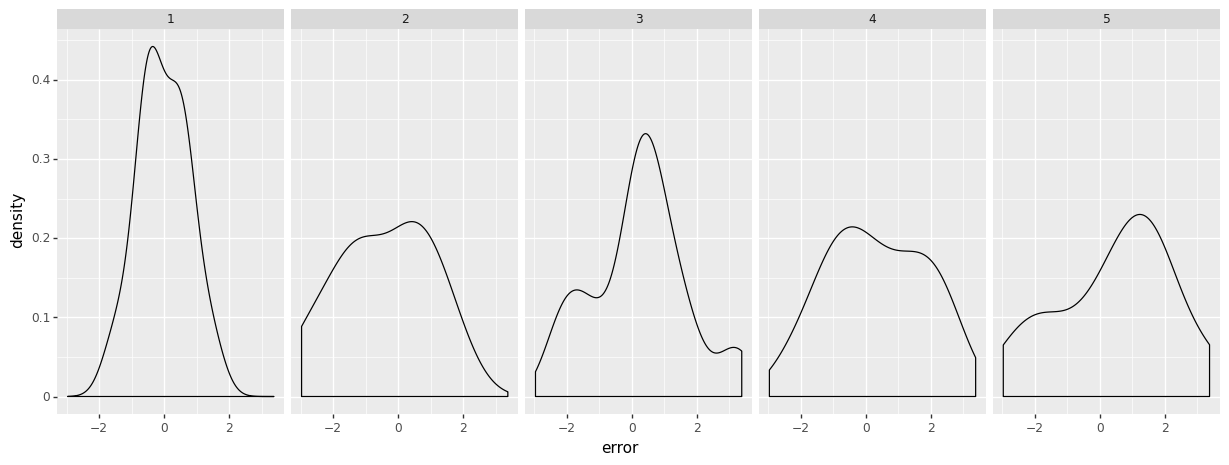

<ggplot: (-9223371874863021494)>

index    metric
0    mean_absolute_error_  1.157967
1  median_absolute_error_  1.086659
2     mean_squared_error_  2.027899

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  12.80661
1  p-value for Lagrange multiplier test   0.30615
2                 fstatistic for F test   1.19018
3                     pvalue for F test   0.32711

Null hypothesis: residuals are not autocorrelated
Statistic values:
[16.84389 17.22913 17.25215 18.00836 19.38    21.32814 25.17078 26.99826
 27.36962 30.37405 32.44917 32.58624 35.58272 39.1002  44.58807 49.74715
 50.37992 50.93528 51.09068 51.09485 51.12444 51.17766 51.27213 51.29848
 53.72299 57.44341 57.63816 59.86691]
p-values:
[4.00e-05 1.80e-04 6.30e-04 1.23e-03 1.63e-03 1.60e-03 7.10e-04 7.10e-04
 1.21e-03 7.40e-04 6.50e-04 1.12e-03 6.90e-04 3.50e-04 9.00e-05 3.00e-05
 4.00e-05 5.00e-05 9.00e-05 1.50e-04 2.50e-04 4.10e-04 6.30e-04 9.60e-04
 7.20e-04 3.70e-04 5.30e-04 4.20e-04]


Null hypothesis: residuals are independent


stats                   value
0  BDS statistic        4.75058143953661
1       p-values  2.0283258458539606e-06

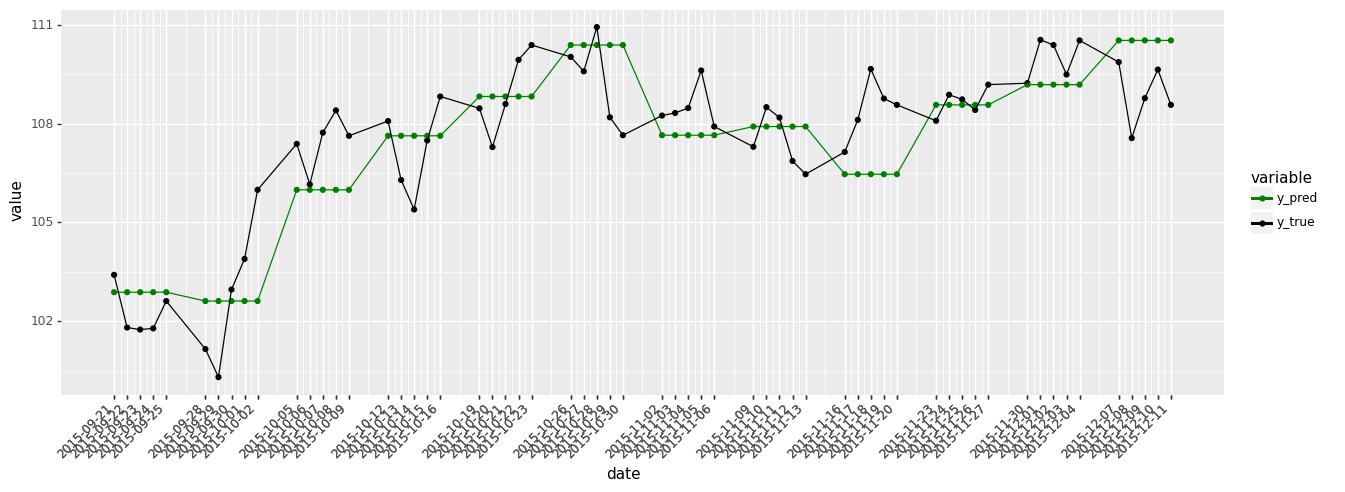

<ggplot: (161997218845)>

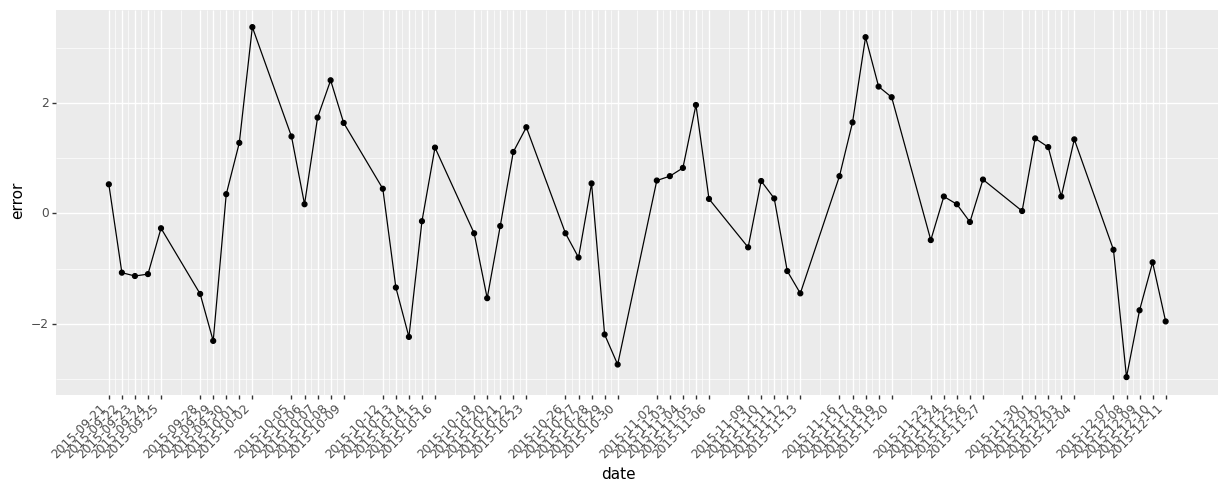

<ggplot: (161991823382)>

0
mean_error_true                0.010790
mean_error_pred                0.010808
mean_error_true_weighted_true  0.010771
mean_error_pred_weighted_pred  0.010783
median_error_true              0.010344
median_error_pred              0.010341
std_error                      0.007732
mean_error_squared             0.010783

In [48]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min




# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = pred_len           # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )

  
    
# MODEL
res = smoothing(   ts               = ts
                 , var_y            = ts_var_1
                 , method           = 'holt' # other values: 'holt', 'holt_winters'
                 , TS_idx           = TS_idx
                 , smoothing_level  = None
                 , optimized        = True
                 , model_name       = 'HOLT_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S")
                 , damped           = False
                 , trend            = 'add'
                 , seasonal         = 'add'
                 , seasonal_periods = 5
                )


# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')
test_BSD(res)


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]

### Holt-winters

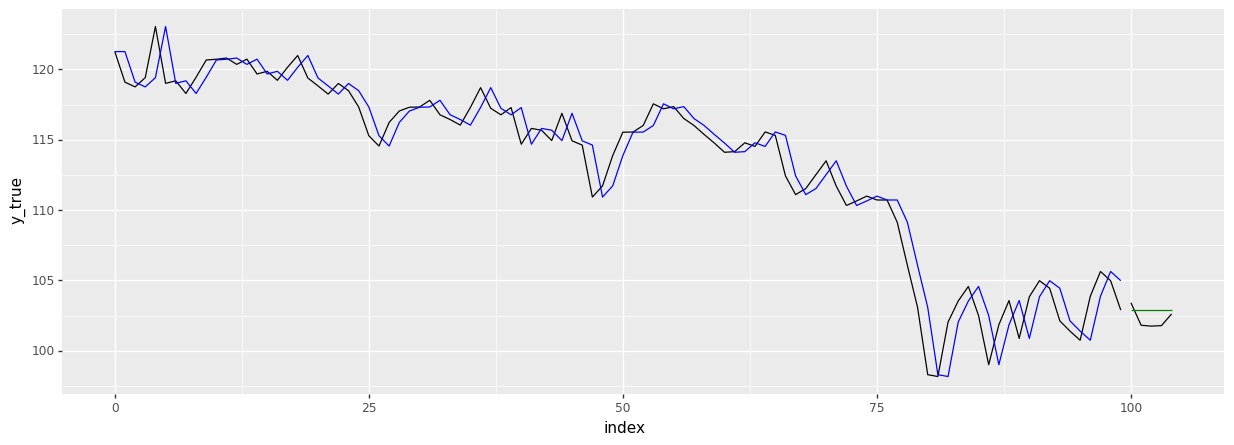

<ggplot: (-9223371874860721895)>

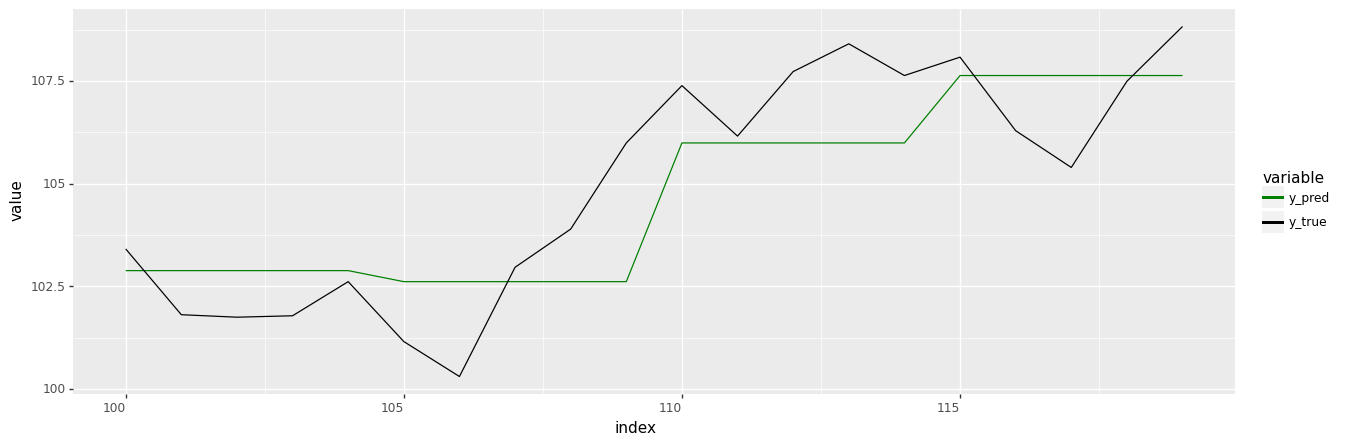

<ggplot: (161993944275)>

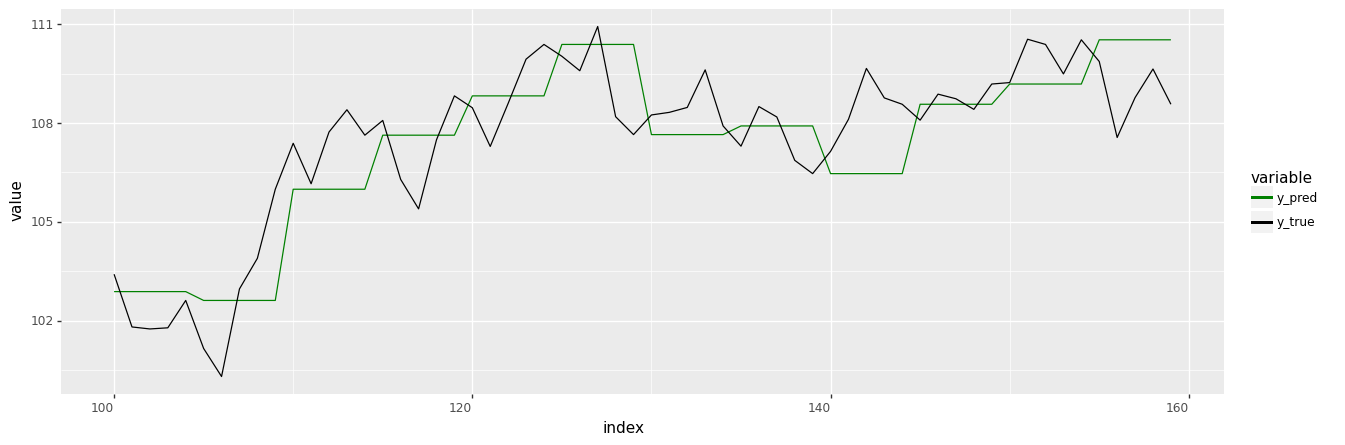

<ggplot: (-9223371874857030126)>

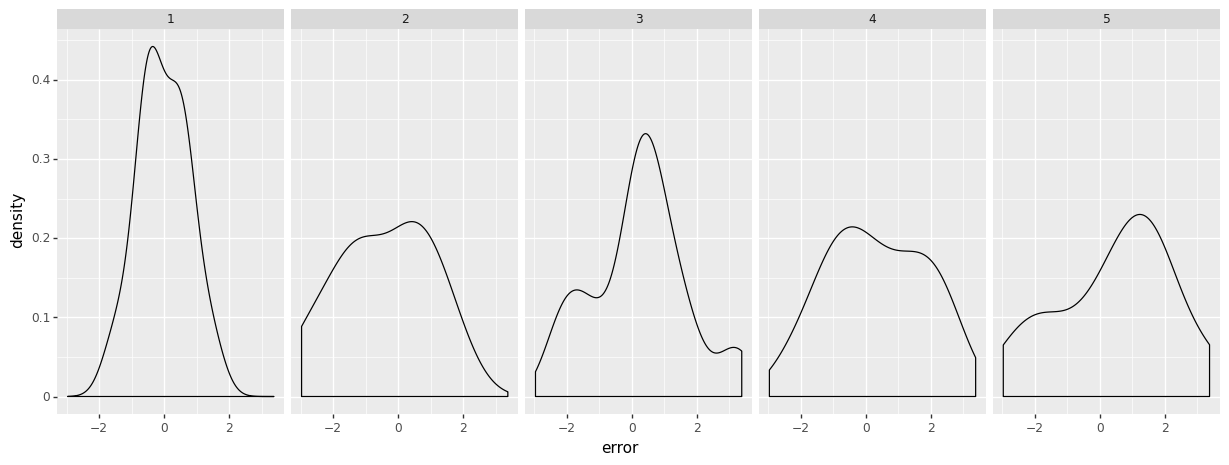

<ggplot: (-9223371874860836955)>

index    metric
0    mean_absolute_error_  1.157967
1  median_absolute_error_  1.086659
2     mean_squared_error_  2.027899

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  12.80661
1  p-value for Lagrange multiplier test   0.30615
2                 fstatistic for F test   1.19018
3                     pvalue for F test   0.32711

Null hypothesis: residuals are not autocorrelated
Statistic values:
[16.84389 17.22913 17.25215 18.00836 19.38    21.32814 25.17078 26.99826
 27.36962 30.37405 32.44917 32.58624 35.58272 39.1002  44.58807 49.74715
 50.37992 50.93528 51.09068 51.09485 51.12444 51.17766 51.27213 51.29848
 53.72299 57.44341 57.63816 59.86691]
p-values:
[4.00e-05 1.80e-04 6.30e-04 1.23e-03 1.63e-03 1.60e-03 7.10e-04 7.10e-04
 1.21e-03 7.40e-04 6.50e-04 1.12e-03 6.90e-04 3.50e-04 9.00e-05 3.00e-05
 4.00e-05 5.00e-05 9.00e-05 1.50e-04 2.50e-04 4.10e-04 6.30e-04 9.60e-04
 7.20e-04 3.70e-04 5.30e-04 4.20e-04]


Null hypothesis: residuals are independent


stats                   value
0  BDS statistic        4.75058143953661
1       p-values  2.0283258458539606e-06

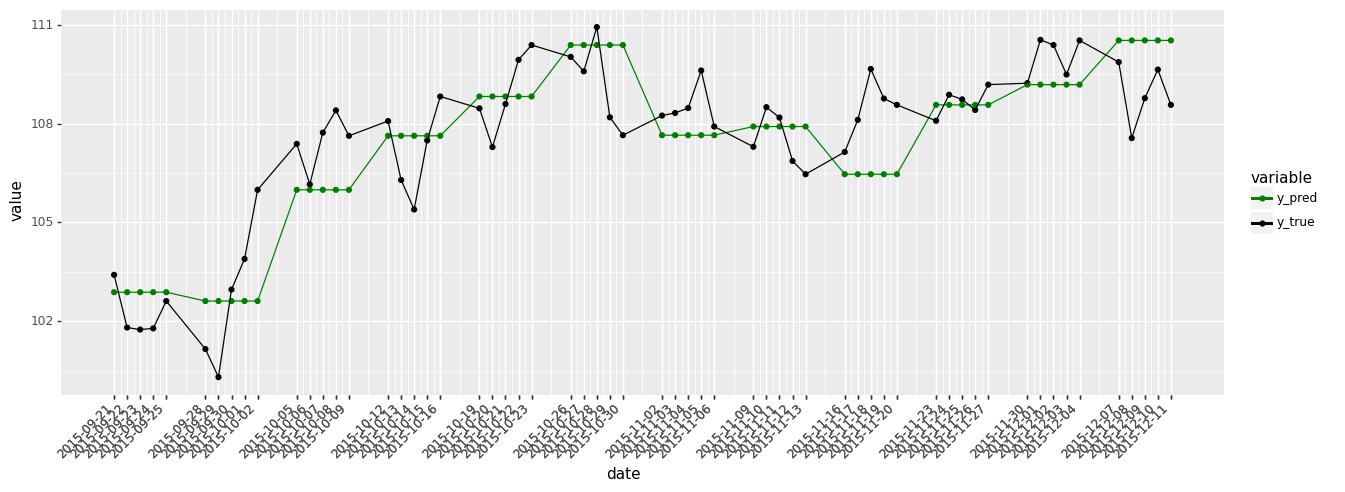

<ggplot: (161867375536)>

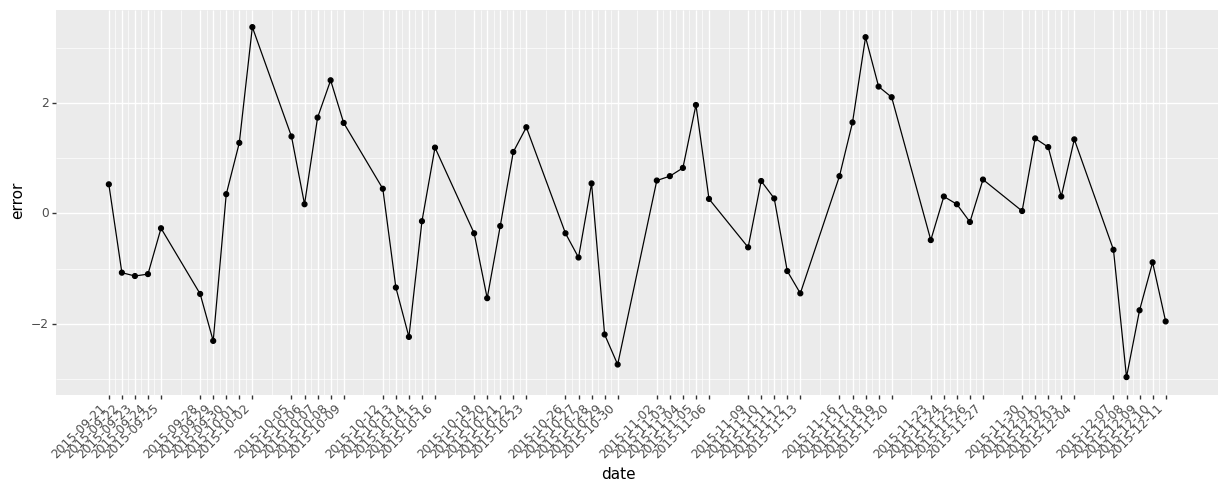

<ggplot: (161867373544)>

0
mean_error_true                0.010790
mean_error_pred                0.010808
mean_error_true_weighted_true  0.010771
mean_error_pred_weighted_pred  0.010783
median_error_true              0.010344
median_error_pred              0.010341
std_error                      0.007732
mean_error_squared             0.010783

In [49]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min




# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = pred_len           # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )


# MODEL
res = smoothing(   ts               = ts
                 , var_y            = ts_var_1
                 , method           = 'holt_winters' # other values: 'holt', 'holt_winters'
                 , TS_idx           = TS_idx
                 , smoothing_level  = None
                 , optimized        = True
                 , model_name       = 'HOLT_WINTERS' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S")
                 , damped           = False
                 , trend            = 'add'
                 , seasonal         = 'add'
                 , seasonal_periods = 5
                )


# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')
test_BSD(res)


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]

## Sarimax

C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.


Optimization terminated successfully.
         Current function value: 1.753418
         Iterations: 252
         Function evaluations: 396


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inf

1
var_2    -0.000001
ar.L1     0.148081
ar.L2    -0.193899
ma.L1     0.000004
ma.L2    -0.999996
sigma2    2.264968
dtype: float64
Optimization terminated successfully.
         Current function value: 1.774197
         Iterations: 255
         Function evaluations: 409


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inf

2
var_2    -0.000001
ar.L1     0.175878
ar.L2    -0.015283
ma.L1    -0.000007
ma.L2    -1.000007
sigma2    2.384985
dtype: float64
Optimization terminated successfully.
         Current function value: 1.742483
         Iterations: 258
         Function evaluations: 405


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inf

3
var_2    -0.000001
ar.L1     0.210157
ar.L2    -0.279010
ma.L1    -0.014769
ma.L2    -0.985203
sigma2    2.238317
dtype: float64


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.


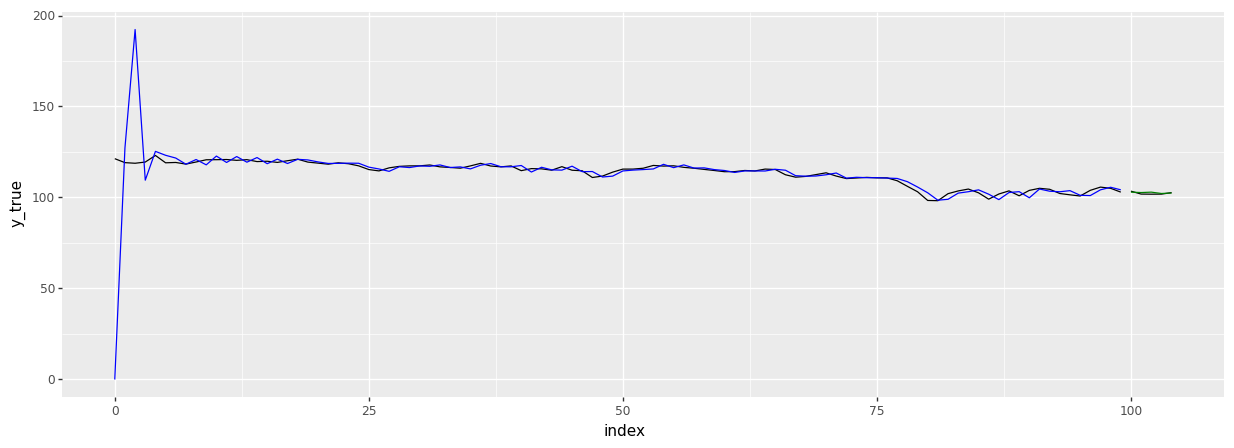

<ggplot: (-9223371874862970329)>

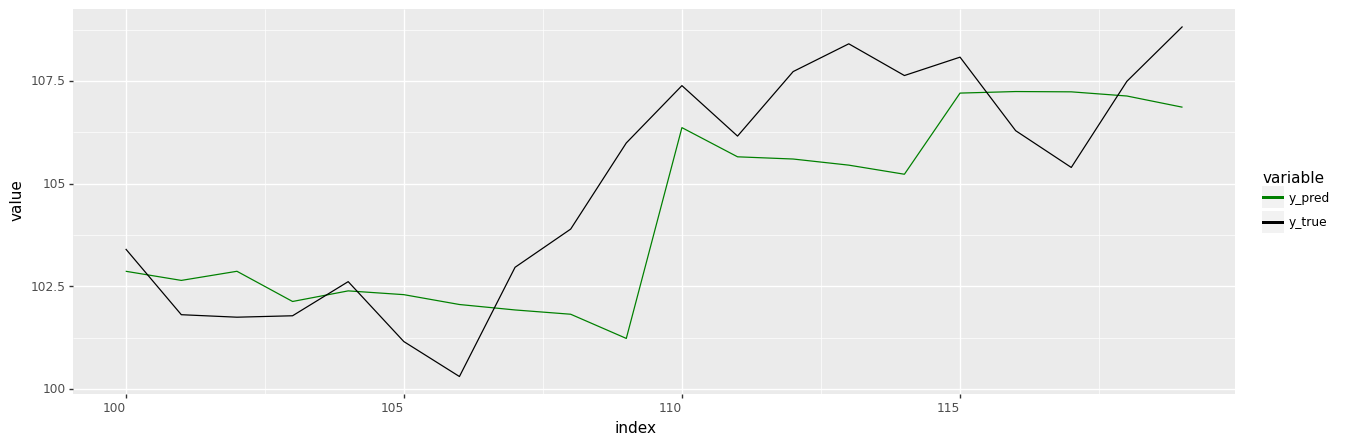

<ggplot: (161868352141)>

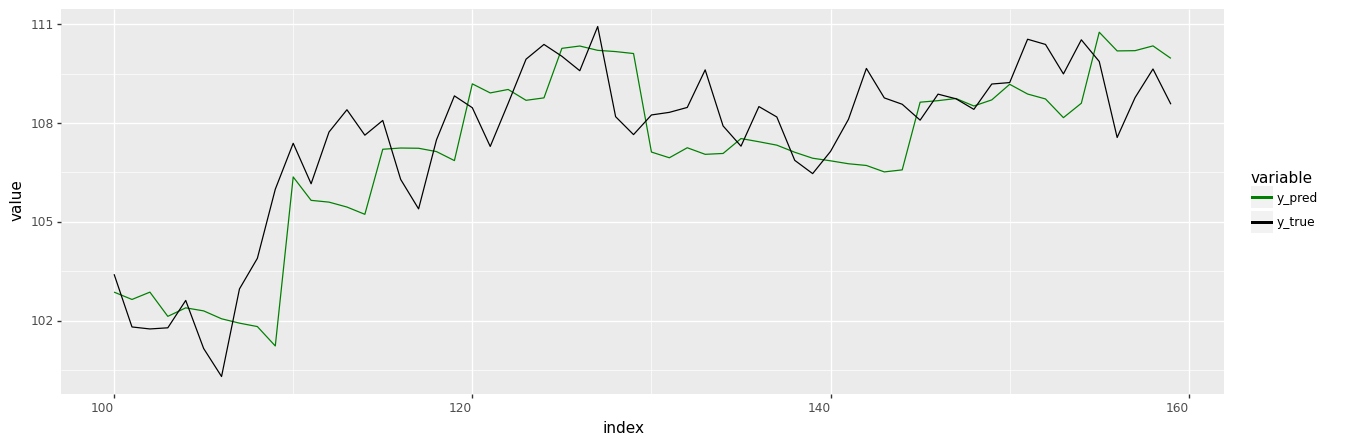

<ggplot: (161994365802)>

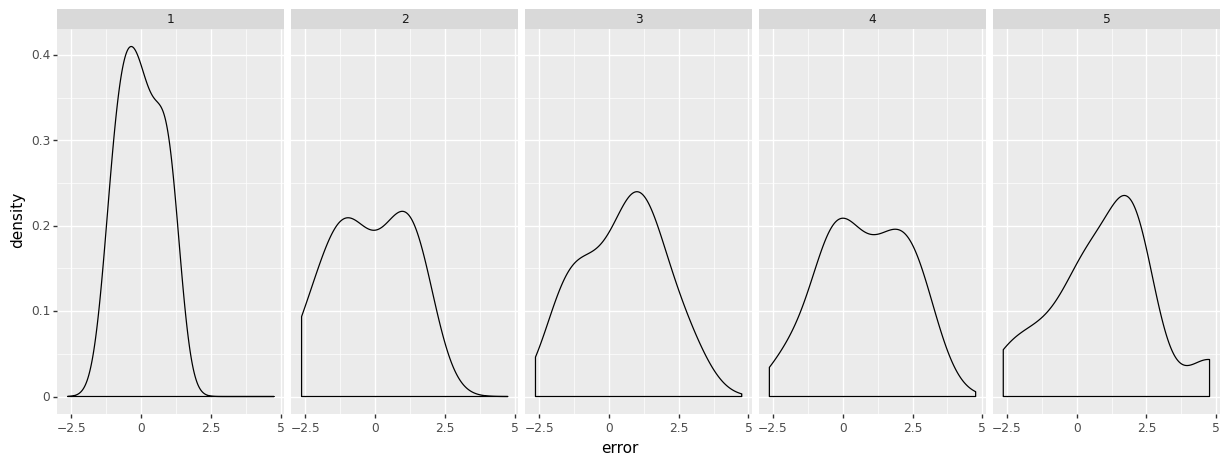

<ggplot: (-9223371874987350773)>

index    metric
0    mean_absolute_error_  1.241446
1  median_absolute_error_  1.093351
2     mean_squared_error_  2.340899

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  13.70321
1  p-value for Lagrange multiplier test   0.24985
2                 fstatistic for F test   1.30586
3                     pvalue for F test   0.25985

Null hypothesis: residuals are not autocorrelated
Statistic values:
[15.10977 15.11566 15.50246 15.86925 16.06829 16.87977 20.80717 23.5907
 23.71587 26.11342 27.43434 27.79864 32.5648  36.14427 38.81732 41.8585
 42.4895  43.25431 43.72433 43.73039 43.768   43.77046 43.94745 44.27369
 45.89864 48.53335 48.87532 50.89023]
p-values:
[0.0001  0.00052 0.00143 0.0032  0.00665 0.00974 0.00407 0.00268 0.00477
 0.00359 0.00395 0.00592 0.00198 0.00099 0.00068 0.00041 0.00057 0.00074
 0.00103 0.00164 0.00251 0.00379 0.00534 0.00709 0.00659 0.00468 0.00612
 0.00514]


Null hypothesis: residuals are independent


stats                  value
0  BDS statistic      4.426462843762455
1       p-values  9.579087339174847e-06

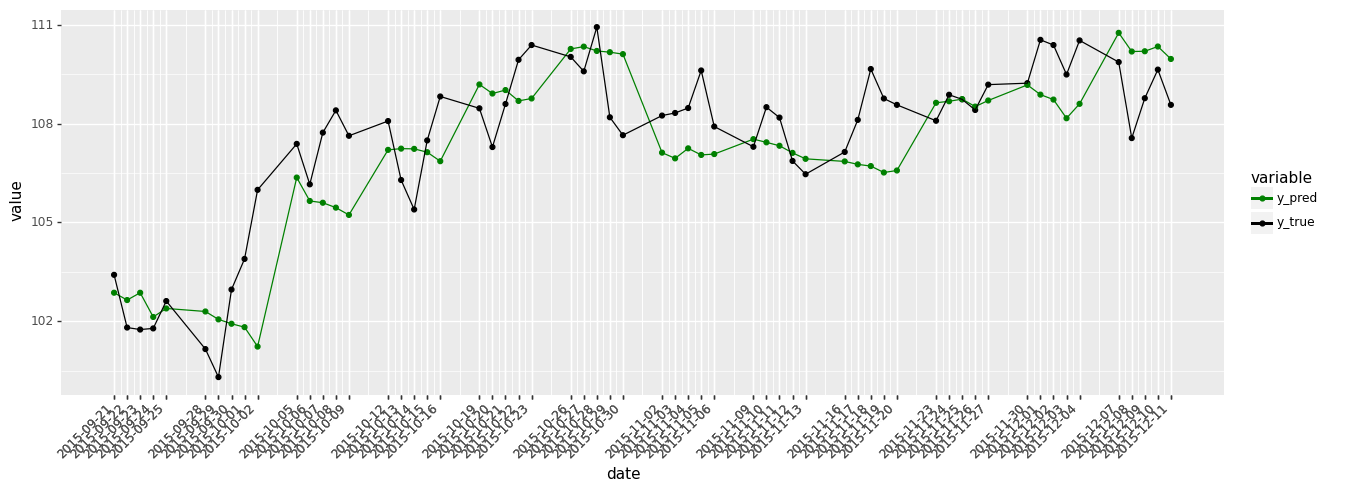

<ggplot: (161994331887)>

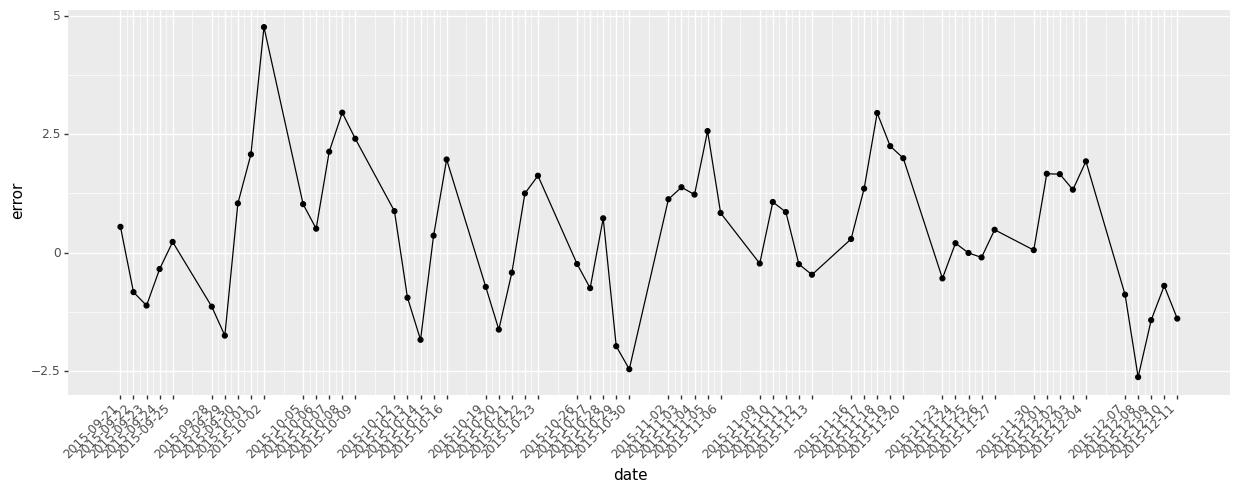

<ggplot: (161997375713)>

0
mean_error_true                0.011541
mean_error_pred                0.011638
mean_error_true_weighted_true  0.011548
mean_error_pred_weighted_pred  0.011593
median_error_true              0.010250
median_error_pred              0.010356
std_error                      0.008318
mean_error_squared             0.011593

In [52]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = pred_len           # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )


# MODEL
res = SARIMAX(  ts    = ts
               ,var_y = [ts_var_1]
               ,var_x = [ts_var_2]
               ,order = (2,1,2)
               ,seasonal_order        = (0,1,0,2)
               ,enforce_stationarity  = False
               ,enforce_invertibility = False
               ,max_iterations = 500
               ,TS_idx = TS_idx
               ,model_name    = 'SARIMAX_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S")
               )



# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')
test_BSD(res)


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]




## Narmax

C:\Users\memy\AppData\Roaming\Python\Python37\site-packages\sysidentpy\polynomial_basis\narmax.py:227: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 


fitted
(100, 1)
real
(100, 1)
1
fitted
(100, 1)
real
(100, 1)
2
fitted
(100, 1)
real
(100, 1)
3


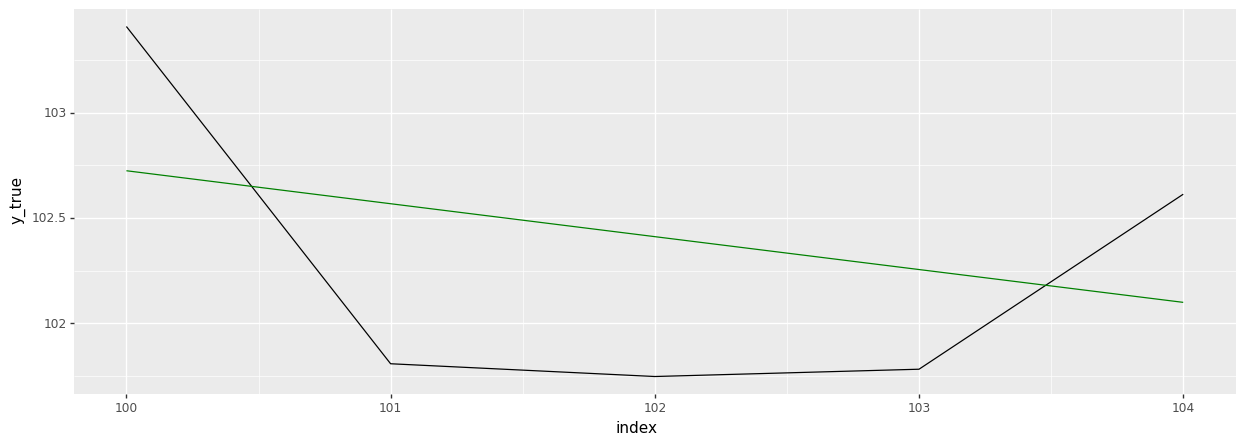

<ggplot: (161866750191)>

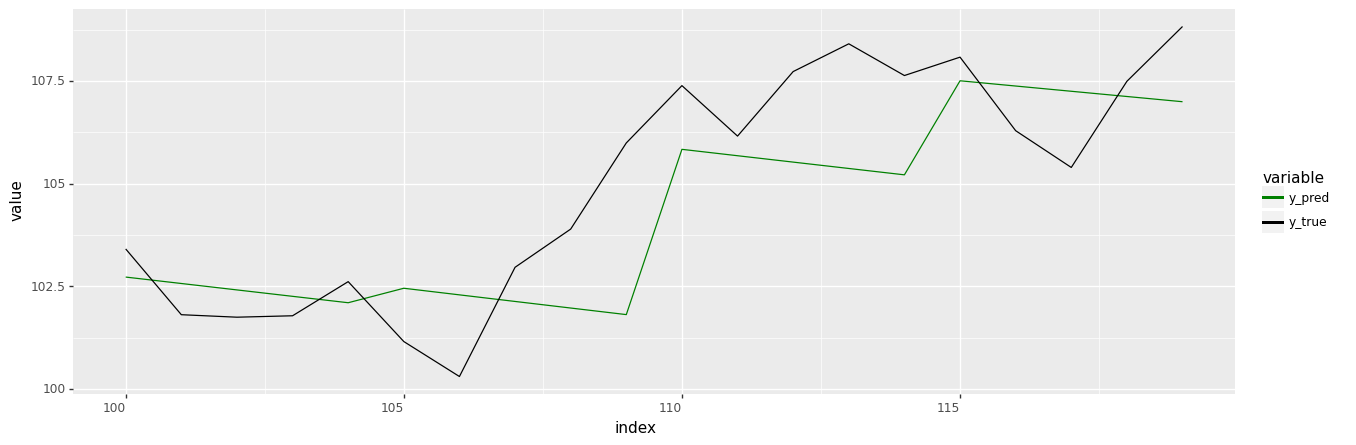

<ggplot: (161993944261)>

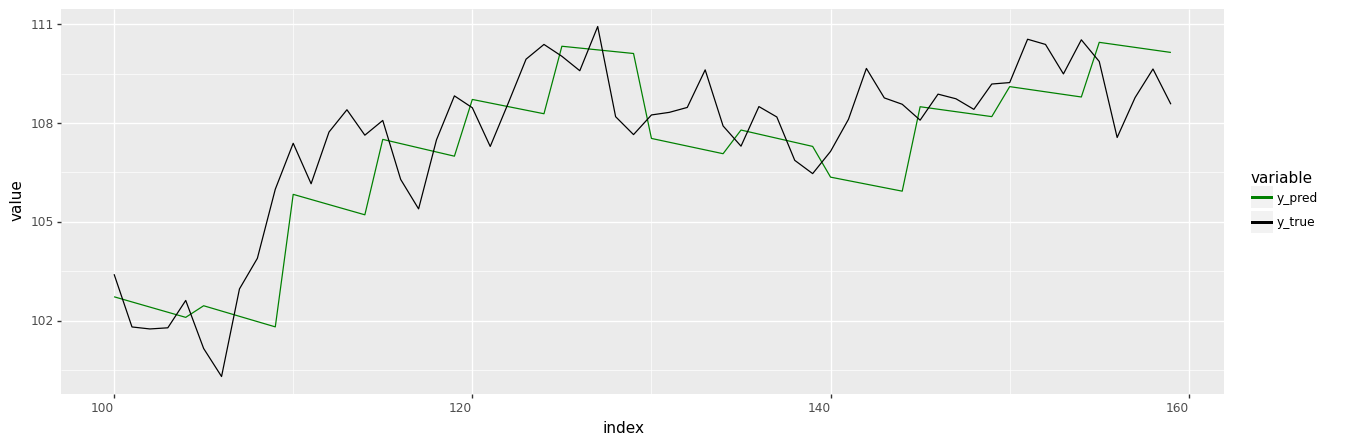

<ggplot: (161994032339)>

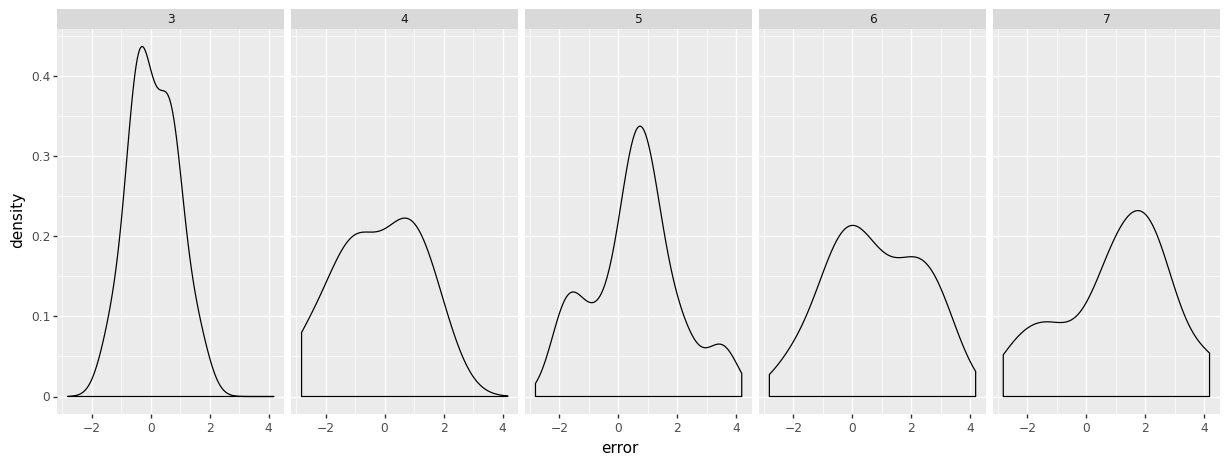

<ggplot: (161867235234)>

index    metric
0    mean_absolute_error_  1.267426
1  median_absolute_error_  0.875987
2     mean_squared_error_  2.423895

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  14.44549
1  p-value for Lagrange multiplier test   0.20931
2                 fstatistic for F test   1.40617
3                     pvalue for F test   0.21121

Null hypothesis: residuals are not autocorrelated
Statistic values:
[15.97125 16.08329 16.25017 16.74991 17.14019 18.40883 22.4028  24.57004
 25.01045 28.82944 30.68916 31.10983 35.17955 38.78581 43.60628 49.01116
 50.26423 50.47153 50.68295 50.72519 50.72733 50.72898 50.80837 50.998
 52.49735 55.83925 55.96215 58.46952]
p-values:
[6.00e-05 3.20e-04 1.01e-03 2.16e-03 4.24e-03 5.29e-03 2.16e-03 1.84e-03
 2.96e-03 1.33e-03 1.23e-03 1.90e-03 7.90e-04 3.90e-04 1.30e-04 3.00e-05
 4.00e-05 6.00e-05 1.00e-04 1.70e-04 2.90e-04 4.70e-04 7.20e-04 1.06e-03
 1.04e-03 5.90e-04 8.70e-04 6.40e-04]


Null hypothesis: residuals are independent


stats                   value
0  BDS statistic       4.193385864001963
1       p-values  2.7482138138736183e-05

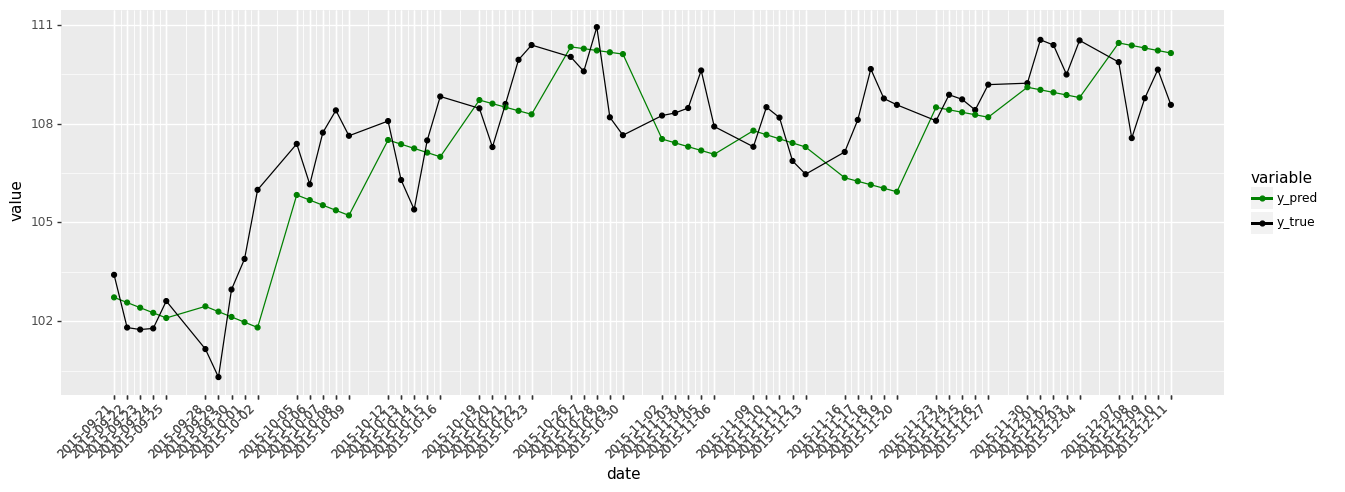

<ggplot: (161991752249)>

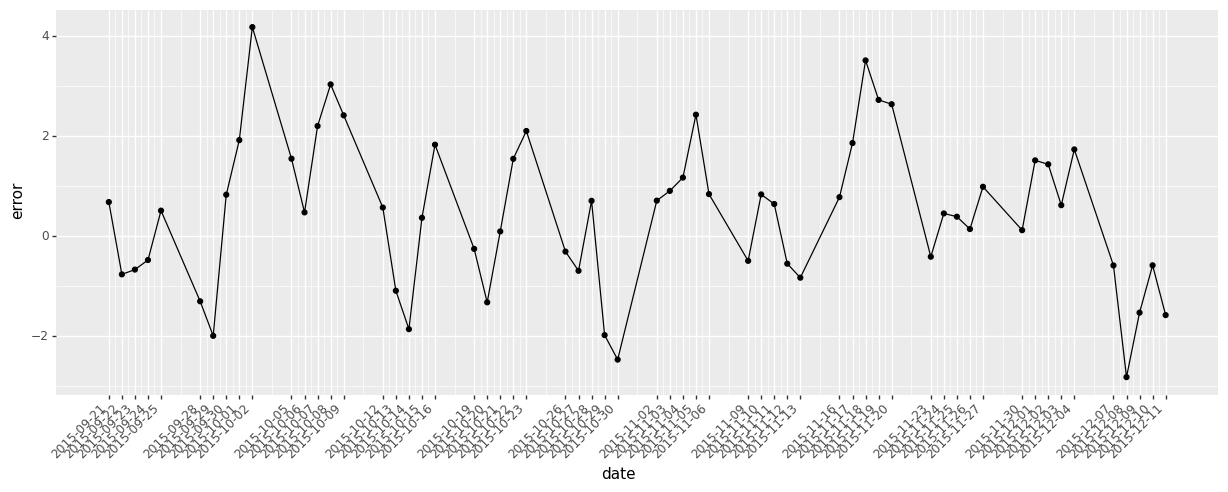

<ggplot: (161867173352)>

0
mean_error_true                0.011784
mean_error_pred                0.011884
mean_error_true_weighted_true  0.011790
mean_error_pred_weighted_pred  0.011839
median_error_true              0.008232
median_error_pred              0.008301
std_error                      0.008385
mean_error_squared             0.011839

In [84]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
y_max_lag = 2
x_max_lag = 2
max_lag = np.max([y_max_lag, x_max_lag])

# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min

train_back_pred_gap = -max_lag + 1 # niepotrzebne
test_back_pred_gap  = -max_lag + 1
train_back_len_min = train_len_min # nipotrzebne
test_back_len_min  = train_len_min

train_pred_len = pred_len + max_lag
test_pred_len  = pred_len + max_lag


# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = train_pred_len     # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = train_back_pred_gap # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = test_pred_len      # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = test_back_pred_gap # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )




# MODEL
model = PolynomialNarmax( non_degree = 1
                         ,ylag       = y_max_lag
                         ,xlag       = x_max_lag
                         ,order_selection = True
                         ,n_info_values   = 10
                         ,extended_least_squares = False
                         ,info_criteria = 'aic'
                         ,estimator = 'least_squares'
                         )

# %run "modules\\models2"
res = NARMAX(  ts    = ts
              ,var_y = [ts_var_1]
              ,var_x = [ts_var_2]
              ,model = model
              ,TS_idx     = TS_idx
              ,model_name = 'NARMAX_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))

# REMOVEING NON POSITIVE SHIFTS
res = res[res['index_rel_shift'] > 0]

# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')
test_BSD(res)


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]



## Hipo

2
110    107.387070
111    106.157974
112    107.729446
113    108.405441
114    107.632881
Name: var_1, dtype: float64
3
115    108.080612
116    106.289665
117    105.394188
118    107.492416
119    108.826843
Name: var_1, dtype: float64
4
120    108.466911
121    107.290482
122    108.598595
123    109.941818
124    110.389542
Name: var_1, dtype: float64
5
125    110.029594
126    109.590645
127    110.933853
128    108.194748
129    107.650444
Name: var_1, dtype: float64


C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1984: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


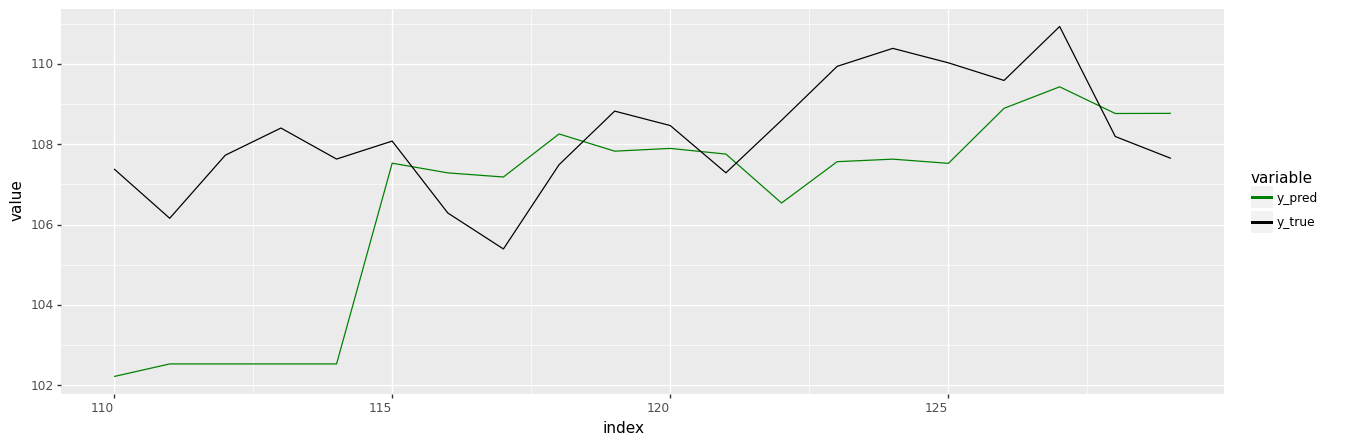

<ggplot: (-9223371874860716747)>

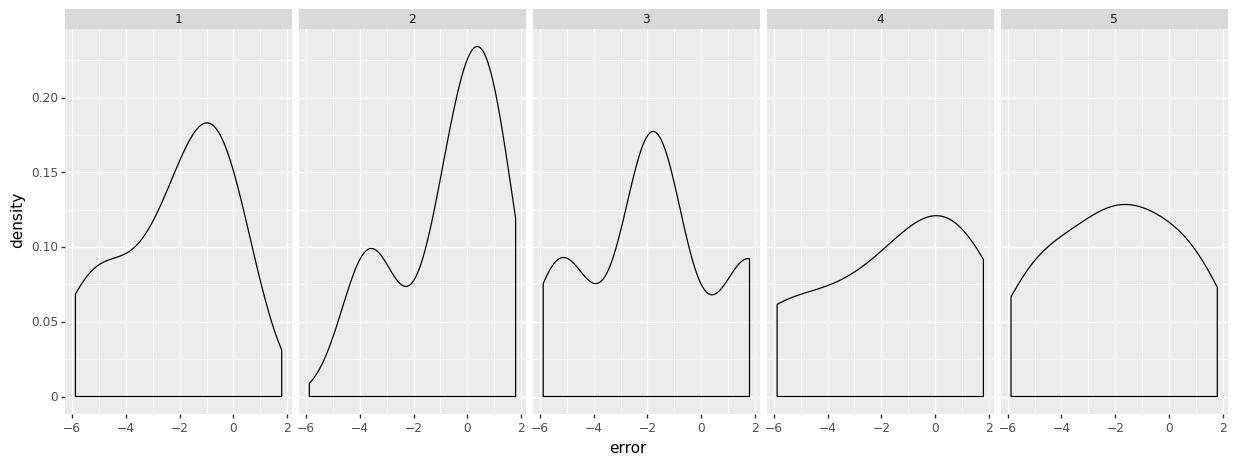

<ggplot: (161867331795)>

index    metric
0    mean_absolute_error_  2.234924
1  median_absolute_error_  1.646863
2     mean_squared_error_  8.108183

Null hypothesis: no conditional heterescedastity


stats      value
0    Lagrange multiplier test statistic   10.99756
1  p-value for Lagrange multiplier test    0.27588
2                 fstatistic for F test  501.12966
3                     pvalue for F test    0.03465

Null hypothesis: residuals are not autocorrelated
Statistic values:
[10.4208  13.22326 13.27627 14.35353 17.3884  21.1789  24.7813  25.71733]
p-values:
[0.00125 0.00134 0.00408 0.00625 0.00382 0.0017  0.00083 0.00117]


Null hypothesis: residuals are independent


stats                  value
0  BDS statistic      8.867478707826251
1       p-values  7.482067719772927e-19

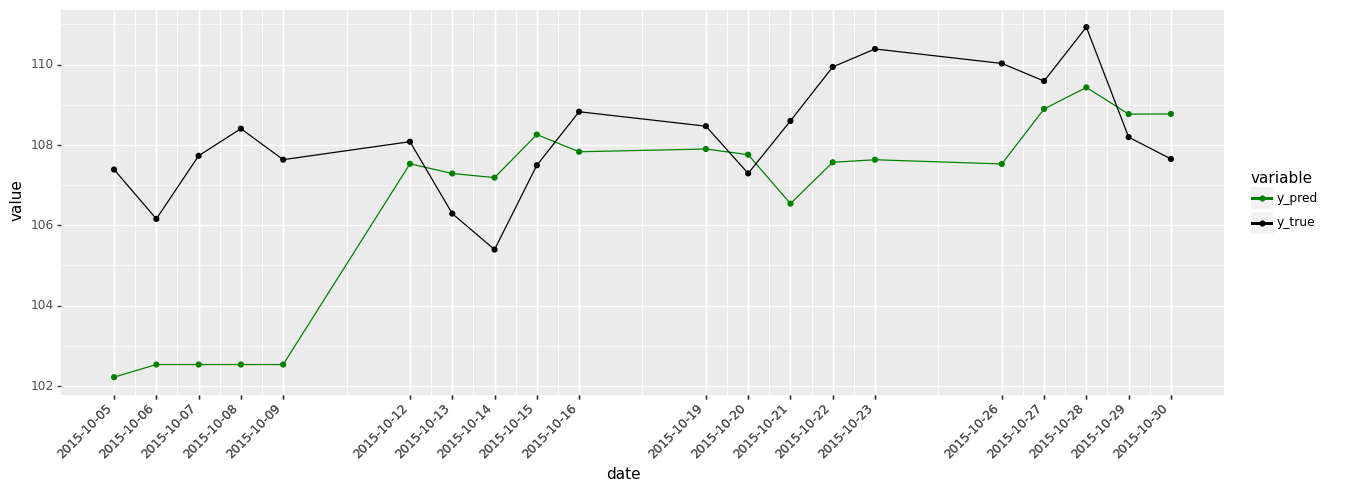

<ggplot: (-9223371874988032694)>

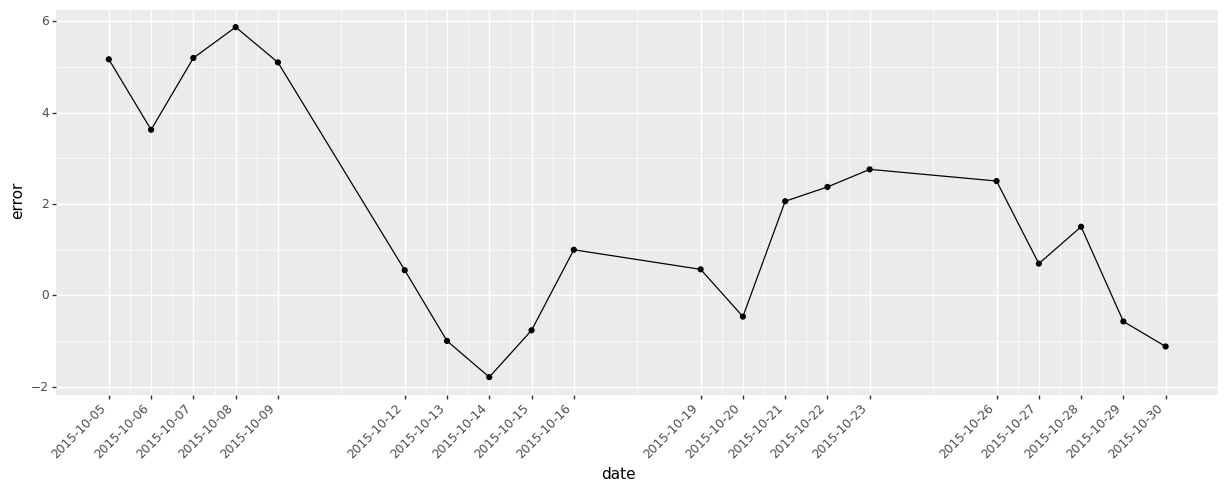

<ggplot: (161994138902)>

0
mean_error_true                0.020671
mean_error_pred                0.021339
mean_error_true_weighted_true  0.020651
mean_error_pred_weighted_pred  0.020973
median_error_true              0.015270
median_error_pred              0.015221
std_error                      0.016377
mean_error_squared             0.020973

In [112]:

# MODEL
res = Hipo(   ts    = ts
            , var_y = ts_var_1
            , freq  = 5
            , pred_length = 5 # dlugosc pojedynczej predykcji
            , rolling = 5
            , seasonality = 'add'
            , start  = 100
            , end    = 130
            , n_pred = 4 + 1)  # ilosc pojedynczych predykcji (+1 bo czesc danych idzie na traina)

res = pd.merge(res, ts['date'].reset_index(drop = False), on = 'index')


# VISUALISATION

# not aggregated results
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')
test_BSD(res)


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]



## Furier

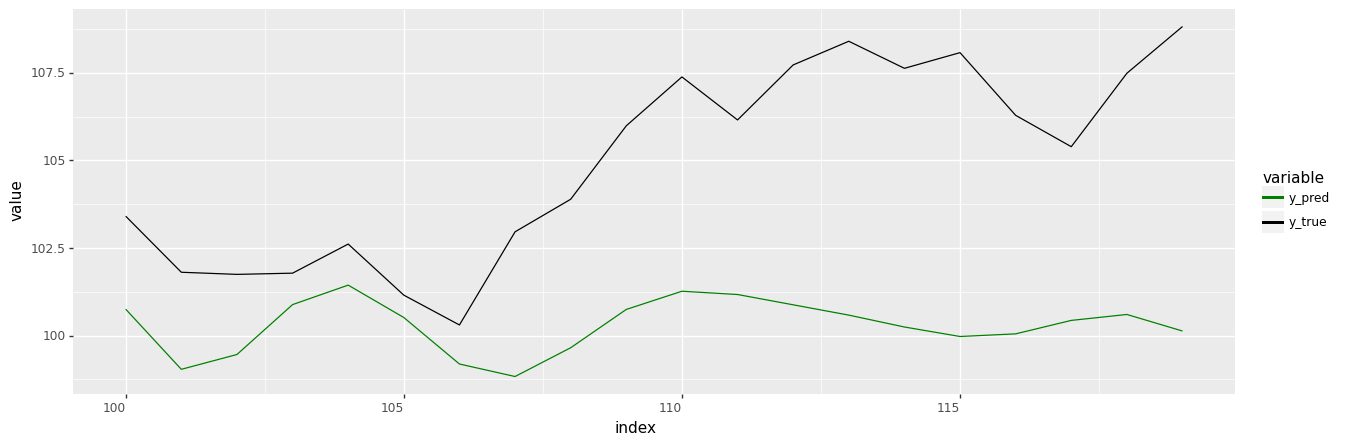

<ggplot: (121901509103)>

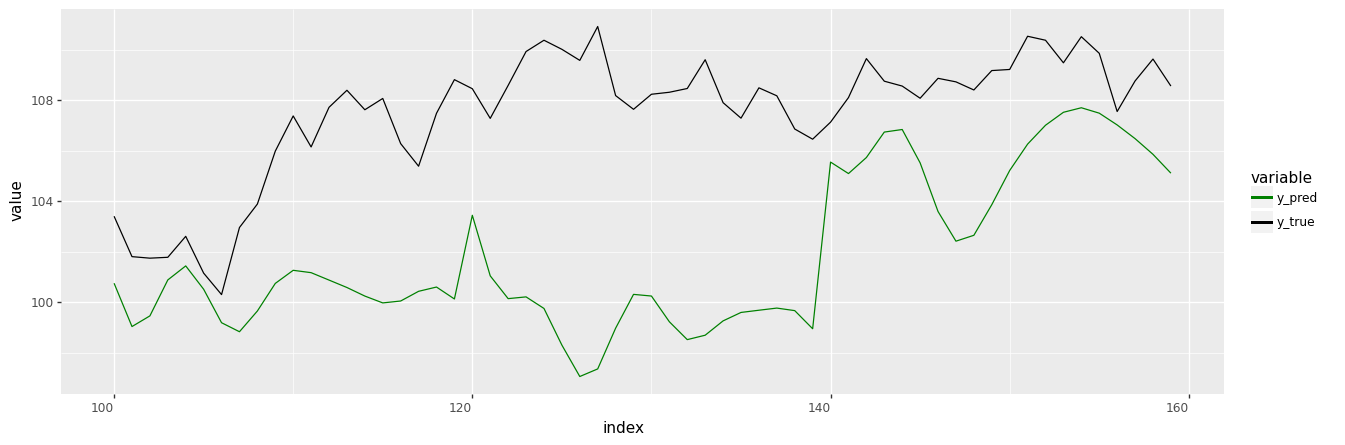

<ggplot: (-9223371914951184885)>

index     metric
0    mean_absolute_error_   5.673316
1  median_absolute_error_   5.300868
2     mean_squared_error_  42.450156

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  36.42501
1  p-value for Lagrange multiplier test   0.00014
2                 fstatistic for F test   9.74319
3                     pvalue for F test   0.00000

Null hypothesis: residuals are not autocorrelated
Statistic values:
[ 46.65358  80.39504 107.04802 124.54936 136.67042 144.34829 148.00373
 151.11458 153.84337 155.93907 158.06353 159.8204  160.27006 160.30513
 160.578   162.81858 168.53948 178.00753 190.53912 204.5194  222.18197
 241.03598 257.50519 273.63073 292.62321 313.0921  333.40505 353.42683]
p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


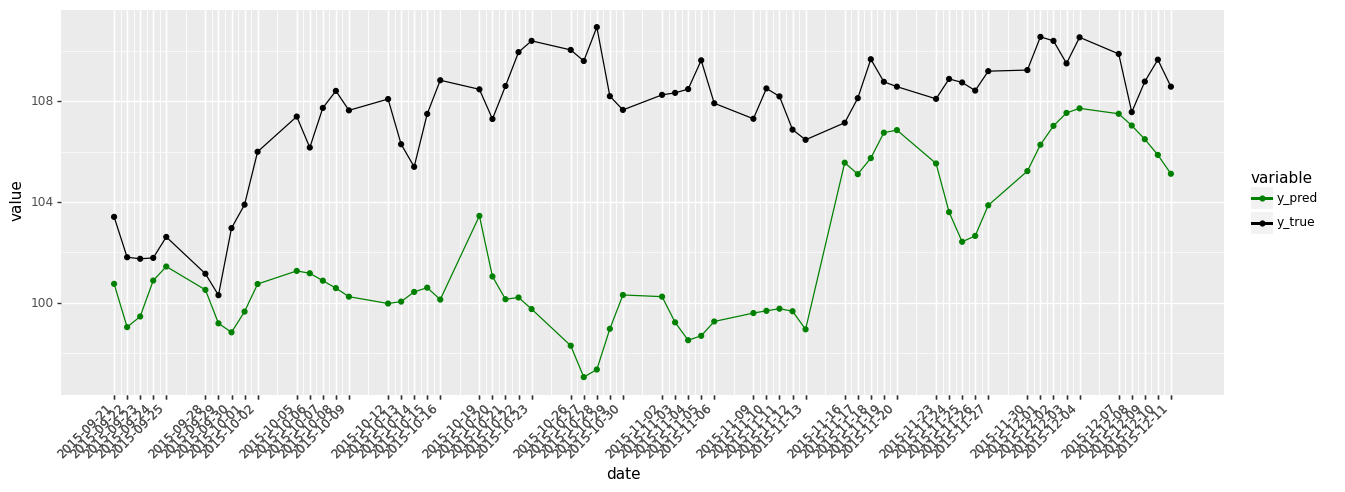

<ggplot: (121902528751)>

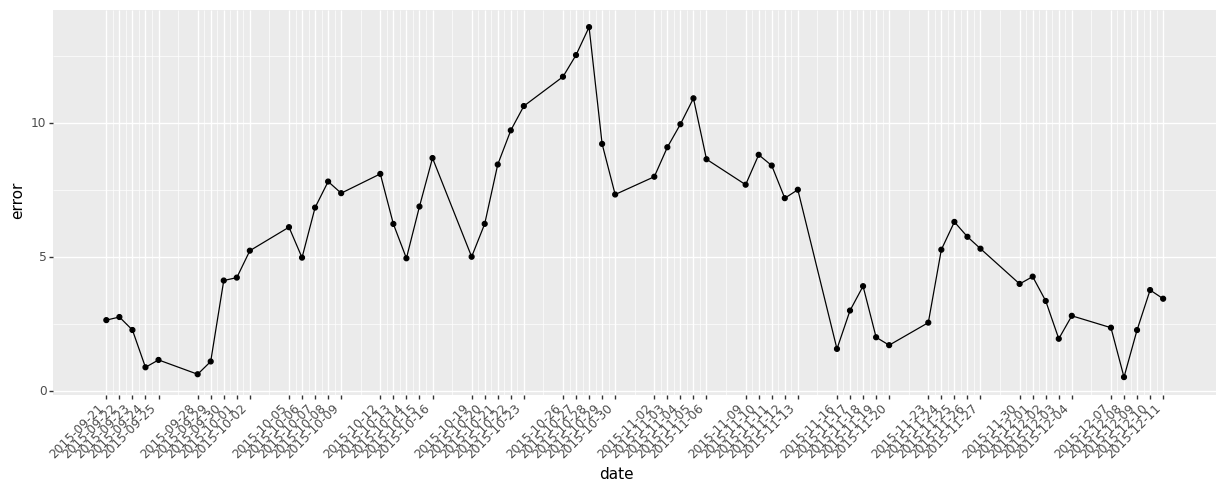

<ggplot: (-9223371914951360589)>

0
mean_error_true                0.052459
mean_error_pred                0.056375
mean_error_true_weighted_true  0.052773
mean_error_pred_weighted_pred  0.055713
median_error_true              0.049103
median_error_pred              0.051639
std_error                      0.029172
mean_error_squared             0.055713

In [46]:
# PARAMETERS
train_len_min  = 100 # dlugosc proby uczacej
fold_n         = 3   # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_n * pred_len  # przesuniecie folda (bo jaki okres bedzie uczenie modelu)
test_len_min   = fold_shift  # dlugosc okres wszyskich predykcji na kazdym foldzie (do ile lacznie okresow bedzie uzyty model do predykcji)
test_shift     = fold_shift   # dlugosc pojedynczej predykcji (dla furiera nie ma rekalkulacji wewnątrz)

train_len_min = train_len_min
test_len_min  = test_len_min


TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n     # ilosc foldow
  ,fold_shift = fold_shift # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = 0 # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = 0     # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1 # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = 0  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = test_len_min      # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = test_len_min           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1 # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )



# MODEL
res = Furier( ts
          , var_y = ts_var_1
          , TS_idx = TS_idx
          , n_harm = 20
          , remove_trend = True
          , model_name = 'FURIER_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S") )


# VISUALISATION

# not aggregated results
# plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, test = 1, if_pred = 1, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
#plot_density_error_pred_n(data_results = res, fold = None)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]


## Garch

C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.


Optimization terminated successfully.
         Current function value: 1.753418
         Iterations: 252
         Function evaluations: 396


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inf

1
var_2    -0.000001
ar.L1     0.148081
ar.L2    -0.193899
ma.L1     0.000004
ma.L2    -0.999996
sigma2    2.264968
dtype: float64
Optimization terminated successfully.
         Current function value: 1.774197
         Iterations: 255
         Function evaluations: 409


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inf

2
var_2    -0.000001
ar.L1     0.175878
ar.L2    -0.015283
ma.L1    -0.000007
ma.L2    -1.000007
sigma2    2.384985
dtype: float64


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.


Optimization terminated successfully.
         Current function value: 1.742483
         Iterations: 258
         Function evaluations: 405


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inf

3
var_2    -0.000001
ar.L1     0.210157
ar.L2    -0.279010
ma.L1    -0.014769
ma.L2    -0.985203
sigma2    2.238317
dtype: float64
Iteration:      1,   Func. Count:      8,   Neg. LLF: 615.0375538907924
Iteration:      2,   Func. Count:     16,   Neg. LLF: 614.7937068829798
Iteration:      3,   Func. Count:     24,   Neg. LLF: 614.789678686948
Iteration:      4,   Func. Count:     32,   Neg. LLF: 614.7846879989592
Iteration:      5,   Func. Count:     40,   Neg. LLF: 614.7804100512893
Iteration:      6,   Func. Count:     48,   Neg. LLF: 614.7783176694084
Iteration:      7,   Func. Count:     56,   Neg. LLF: 614.7773765356271
Iteration:      8,   Func. Count:     64,   Neg. LLF: 614.7769073481242
Iteration:      9,   Func. Count:     72,   Neg. LLF: 614.7762549735559
Iteration:     10,   Func. Count:     80,   Neg. LLF: 614.7755026037008
Iteration:     11,   Func. Count:     88,   Neg. LLF: 614.7752657966872
Iteration:     12,   Func. Count:     96,   Neg. LLF: 614.7751701831647
Iterat

Iteration:      6,   Func. Count:     48,   Neg. LLF: 611.6750165940643
Iteration:      7,   Func. Count:     56,   Neg. LLF: 611.6738538239256
Iteration:      8,   Func. Count:     64,   Neg. LLF: 611.6731774689091
Iteration:      9,   Func. Count:     72,   Neg. LLF: 611.6730831526594
Iteration:     10,   Func. Count:     80,   Neg. LLF: 611.6729035593079
Iteration:     11,   Func. Count:     88,   Neg. LLF: 611.6728841230363
Iteration:     12,   Func. Count:     96,   Neg. LLF: 611.6728810768175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 611.6728810768292
            Iterations: 12
            Function evaluations: 96
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      8,   Neg. LLF: 611.6640258135618
Iteration:      2,   Func. Count:     16,   Neg. LLF: 611.3913903408784
Iteration:      3,   Func. Count:     24,   Neg. LLF: 611.3844157524143
Iteration:      4,   Func. Count:     32,   Neg. LLF: 611.375423321017

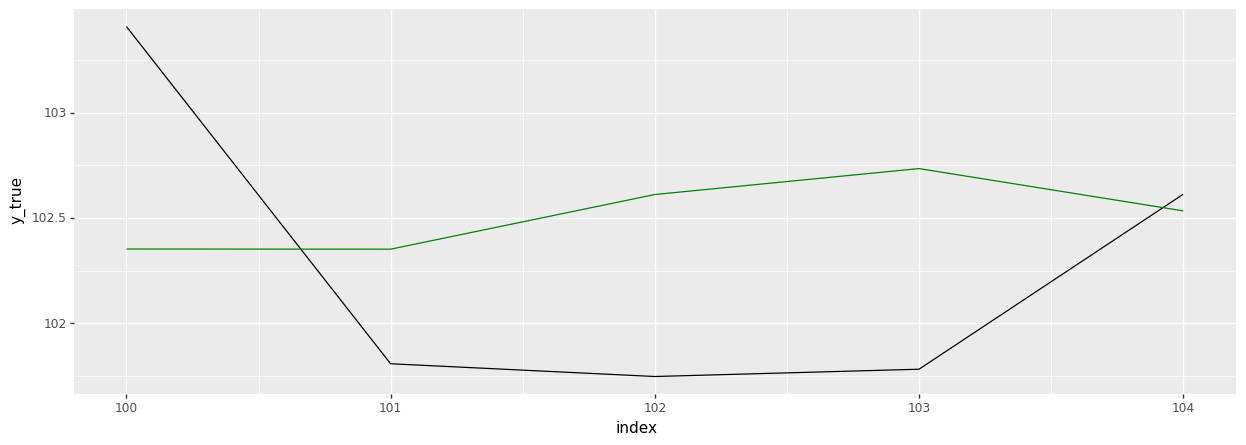

<ggplot: (161873241278)>

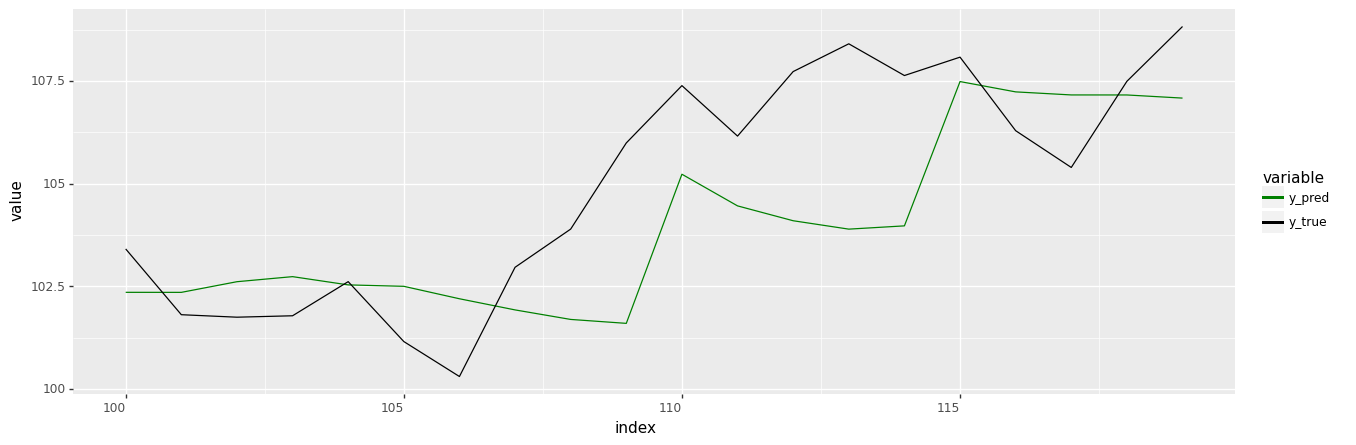

<ggplot: (161869324727)>

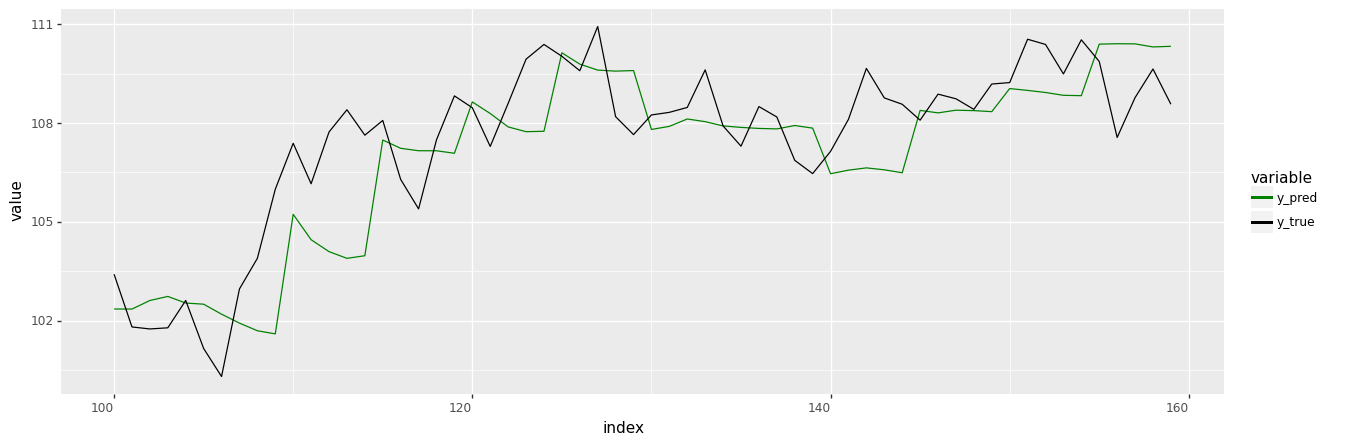

<ggplot: (-9223371874985237707)>

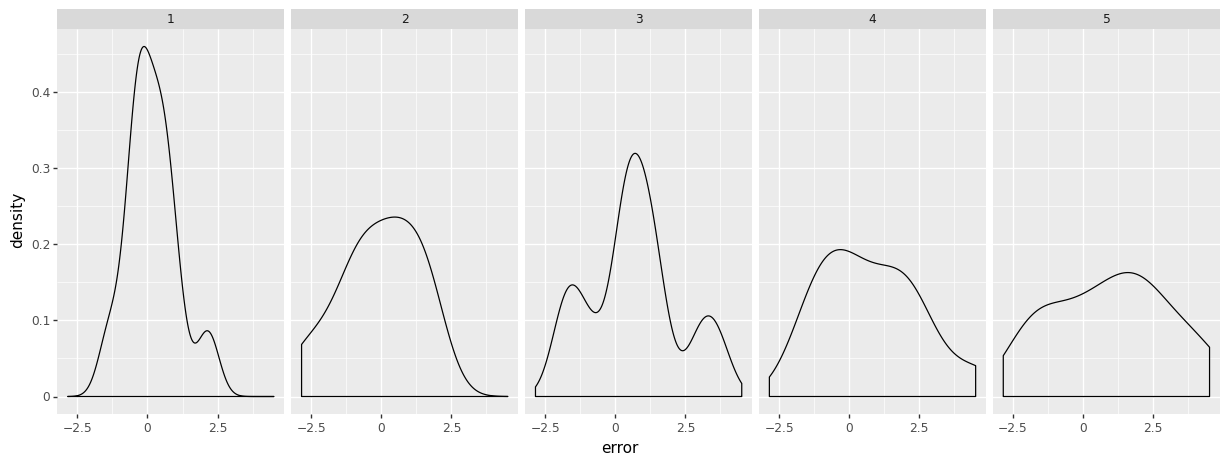

<ggplot: (-9223371874863166222)>

index    metric
0    mean_absolute_error_  1.308624
1  median_absolute_error_  1.047315
2     mean_squared_error_  2.804963

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  26.52720
1  p-value for Lagrange multiplier test   0.00541
2                 fstatistic for F test   3.97048
3                     pvalue for F test   0.00075

Null hypothesis: residuals are not autocorrelated
Statistic values:
[20.84791 22.56373 22.6918  22.72548 23.19136 26.03915 32.68749 37.05486
 37.05708 38.22174 38.88988 39.02363 39.75241 40.25008 42.24154 45.46691
 46.2194  46.41841 46.58108 46.58121 46.6867  46.70878 46.72537 46.73639
 48.33027 50.65522 50.84166 53.07151]
p-values:
[0.00e+00 1.00e-05 5.00e-05 1.40e-04 3.10e-04 2.20e-04 3.00e-05 1.00e-05
 3.00e-05 3.00e-05 6.00e-05 1.00e-04 1.50e-04 2.30e-04 2.10e-04 1.20e-04
 1.60e-04 2.60e-04 4.10e-04 6.70e-04 1.03e-03 1.60e-03 2.43e-03 3.61e-03
 3.40e-03 2.62e-03 3.63e-03 2.88e-03]


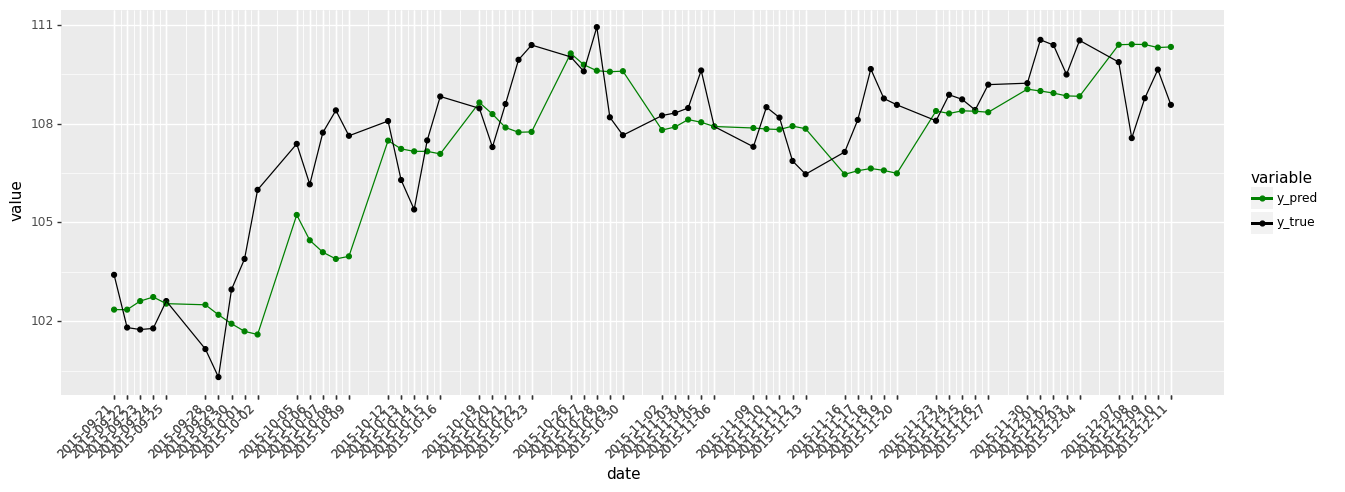

<ggplot: (161866960546)>

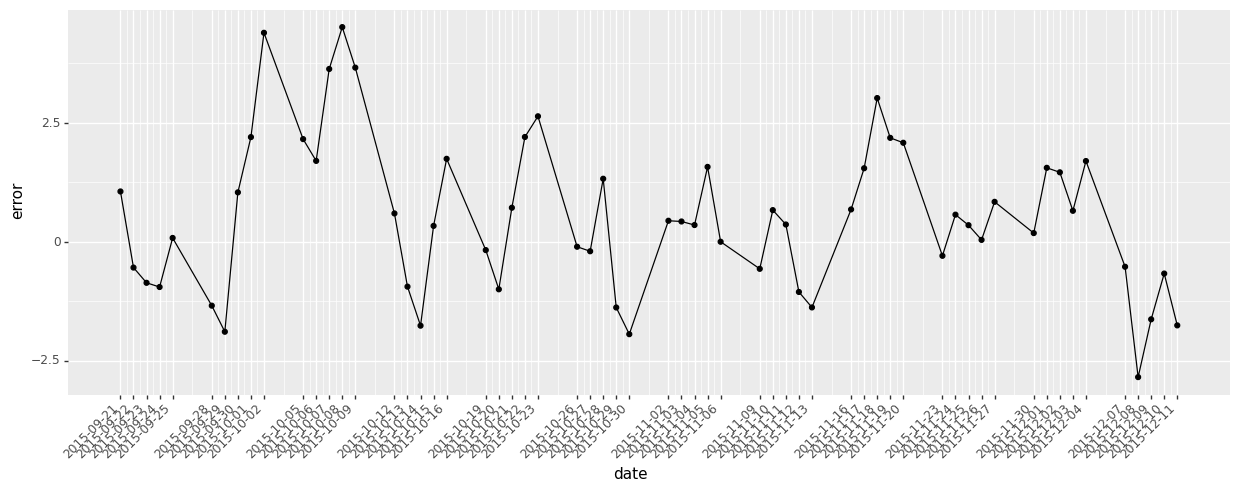

<ggplot: (161867940437)>

0
mean_error_true                0.012177
mean_error_pred                0.012319
mean_error_true_weighted_true  0.012173
mean_error_pred_weighted_pred  0.012231
median_error_true              0.009985
median_error_pred              0.009988
std_error                      0.009706
mean_error_squared             0.012231

In [205]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = pred_len           # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )



# MODEL
res = GARCH( ts = ts
        ,var_y = [ts_var_1]
        ,mean = 'Zero'
        ,vol = 'ARCH'
        ,p = 5
        ,q = None
        ,TS_idx = TS_idx
        ,model_name = 'GARCH_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S")
        )



# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]

## Mars

1.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
0      0          1              1.0 2015-05-04     1                    1
0      5          1              1.0 2015-05-11     1                    1
0     10          1              1.0 2015-05-18     1                    1
0     15          1              1.0 2015-05-25     1                    1
0     20          1              1.0 2015-06-01     1                    1
0     25          1              1.0 2015-06-08     1                    1
0     30          1              1.0 2015-06-15     1                    1
0     35          1              1.0 2015-06-22     1                    1
0     40          1              1.0 2015-06-29     1                    1
0     45          1              1.0 2015-07-06     1                    1
0     50          1              1.0 2015-07-13     1                    1
0     55          1              1.0 2015-07-20     1                    1
0     60     

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep usin

   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
0     20          1              1.0 2015-06-01     1                    1
0     25          1              1.0 2015-06-08     1                    1
0     30          1              1.0 2015-06-15     1                    1
0     35          1              1.0 2015-06-22     1                    1
0     40          1              1.0 2015-06-29     1                    1
0     45          1              1.0 2015-07-06     1                    1
0     50          1              1.0 2015-07-13     1                    1
0     55          1              1.0 2015-07-20     1                    1
0     60          1              1.0 2015-07-27     1                    1
0     65          1              1.0 2015-08-03     1                    1
0     70          1              1.0 2015-08-10     1                    1
0     75          1              1.0 2015-08-17     1                    1
0     80          1      

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep usi


2.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
1      1          2              2.0 2015-05-05     1                    2
1      6          2              2.0 2015-05-12     1                    2
1     11          2              2.0 2015-05-19     1                    2
1     16          2              2.0 2015-05-26     1                    2
1     21          2              2.0 2015-06-02     1                    2
1     26          2              2.0 2015-06-09     1                    2
1     31          2              2.0 2015-06-16     1                    2
1     36          2              2.0 2015-06-23     1                    2
1     41          2              2.0 2015-06-30     1                    2
1     46          2              2.0 2015-07-07     1                    2
1     51          2              2.0 2015-07-14     1                    2
1     56          2              2.0 2015-07-21     1                    2
1     61    

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep usin

   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
1     21          2              2.0 2015-06-02     1                    2
1     26          2              2.0 2015-06-09     1                    2
1     31          2              2.0 2015-06-16     1                    2
1     36          2              2.0 2015-06-23     1                    2
1     41          2              2.0 2015-06-30     1                    2
1     46          2              2.0 2015-07-07     1                    2
1     51          2              2.0 2015-07-14     1                    2
1     56          2              2.0 2015-07-21     1                    2
1     61          2              2.0 2015-07-28     1                    2
1     66          2              2.0 2015-08-04     1                    2
1     71          2              2.0 2015-08-11     1                    2
1     76          2              2.0 2015-08-18     1                    2
1     81          2      

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


3.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
2      2          3              3.0 2015-05-06     1                    3
2      7          3              3.0 2015-05-13     1                    3
2     12          3              3.0 2015-05-20     1                    3
2     17          3              3.0 2015-05-27     1                    3
2     22          3              3.0 2015-06-03     1                    3
2     27          3              3.0 2015-06-10     1                    3
2     32          3              3.0 2015-06-17     1                    3
2     37          3              3.0 2015-06-24     1                    3
2     42          3              3.0 2015-07-01     1                    3
2     47          3              3.0 2015-07-08     1                    3
2     52          3              3.0 2015-07-15     1                    3
2     57          3              3.0 2015-07-22     1                    3
2     62     

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep usin

2f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
2     22          3              3.0 2015-06-03     1                    3
2     27          3              3.0 2015-06-10     1                    3
2     32          3              3.0 2015-06-17     1                    3
2     37          3              3.0 2015-06-24     1                    3
2     42          3              3.0 2015-07-01     1                    3
2     47          3              3.0 2015-07-08     1                    3
2     52          3              3.0 2015-07-15     1                    3
2     57          3              3.0 2015-07-22     1                    3
2     62          3              3.0 2015-07-29     1                    3
2     67          3              3.0 2015-08-05     1                    3
2     72          3              3.0 2015-08-12     1                    3
2     77          3              3.0 2015-08-19     1                    3
2     82          3 

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep usin


2f
b


C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
3     23          4              4.0 2015-06-04     1                    4
3     28          4              4.0 2015-06-11     1                    4
3     33          4              4.0 2015-06-18     1                    4
3     38          4              4.0 2015-06-25     1                    4
3     43          4              4.0 2015-07-02     1                    4
3     48          4              4.0 2015-07-09     1                    4
3     53          4              4.0 2015-07-16     1                    4
3     58          4              4.0 2015-07-23     1                    4
3     63          4              4.0 2015-07-30     1                    4
3     68          4              4.0 2015-08-06     1                    4
3     73          4              4.0 2015-08-13     1                    4
3     78          4              4.0 2015-08-20     1                    4
3     83          4      

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
3     43          4              4.0 2015-07-02     1                    4
3     48          4              4.0 2015-07-09     1                    4
3     53          4              4.0 2015-07-16     1                    4
3     58          4              4.0 2015-07-23     1                    4
3     63          4              4.0 2015-07-30     1                    4
3     68          4              4.0 2015-08-06     1                    4
3     73          4              4.0 2015-08-13     1                    4
3     78          4              4.0 2015-08-20     1                    4
3     83          4              4.0 2015-08-27     1                    4
3     88          4              4.0 2015-09-03     1                    4
3     93          4              4.0 2015-09-10     1                    4
3     98          4              4.0 2015-09-17     1                    4
3    103          4      

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
4      4          5              5.0 2015-05-08     1                    5
4      9          5              5.0 2015-05-15     1                    5
4     14          5              5.0 2015-05-22     1                    5
4     19          5              5.0 2015-05-29     1                    5
4     24          5              5.0 2015-06-05     1                    5
4     29          5              5.0 2015-06-12     1                    5
4     34          5              5.0 2015-06-19     1                    5
4     39          5              5.0 2015-06-26     1                    5
4     44          5              5.0 2015-07-03     1                    5
4     49          5              5.0 2015-07-10     1                    5
4     54          5              5.0 2015-07-17     1                    5
4     59          5              5.0 2015-07-24     1                    5
4     64          5      

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
4     24          5              5.0 2015-06-05     1                    5
4     29          5              5.0 2015-06-12     1                    5
4     34          5              5.0 2015-06-19     1                    5
4     39          5              5.0 2015-06-26     1                    5
4     44          5              5.0 2015-07-03     1                    5
4     49          5              5.0 2015-07-10     1                    5
4     54          5              5.0 2015-07-17     1                    5
4     59          5              5.0 2015-07-24     1                    5
4     64          5              5.0 2015-07-31     1                    5
4     69          5              5.0 2015-08-07     1                    5
4     74          5              5.0 2015-08-14     1                    5
4     79          5              5.0 2015-08-21     1                    5
4     84          5      

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
4     44          5              5.0 2015-07-03     1                    5
4     49          5              5.0 2015-07-10     1                    5
4     54          5              5.0 2015-07-17     1                    5
4     59          5              5.0 2015-07-24     1                    5
4     64          5              5.0 2015-07-31     1                    5
4     69          5              5.0 2015-08-07     1                    5
4     74          5              5.0 2015-08-14     1                    5
4     79          5              5.0 2015-08-21     1                    5
4     84          5              5.0 2015-08-28     1                    5
4     89          5              5.0 2015-09-04     1                    5
4     94          5              5.0 2015-09-11     1                    5
4     99          5              5.0 2015-09-18     1                    5
4    104          5      

C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\memy\Anaconda3\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


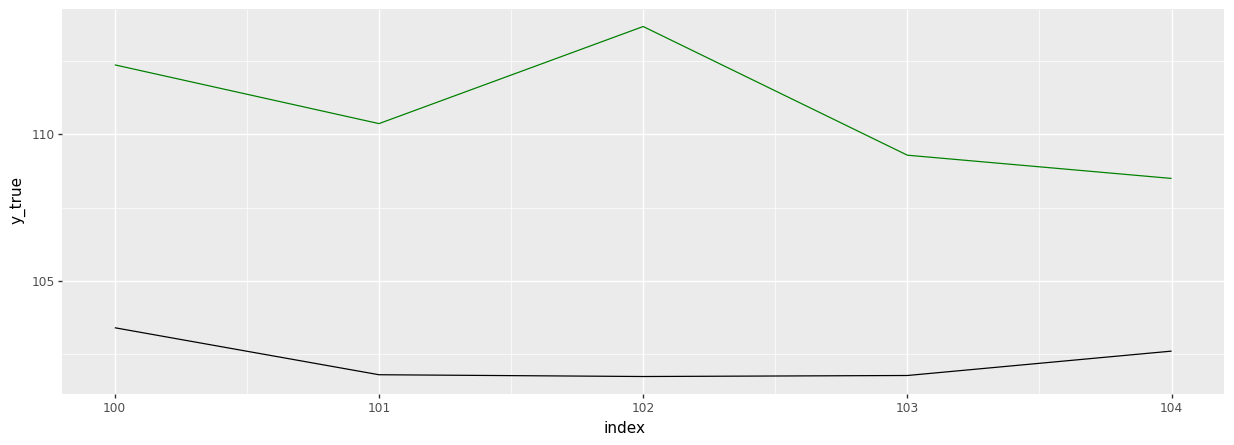

<ggplot: (-9223371874985435830)>

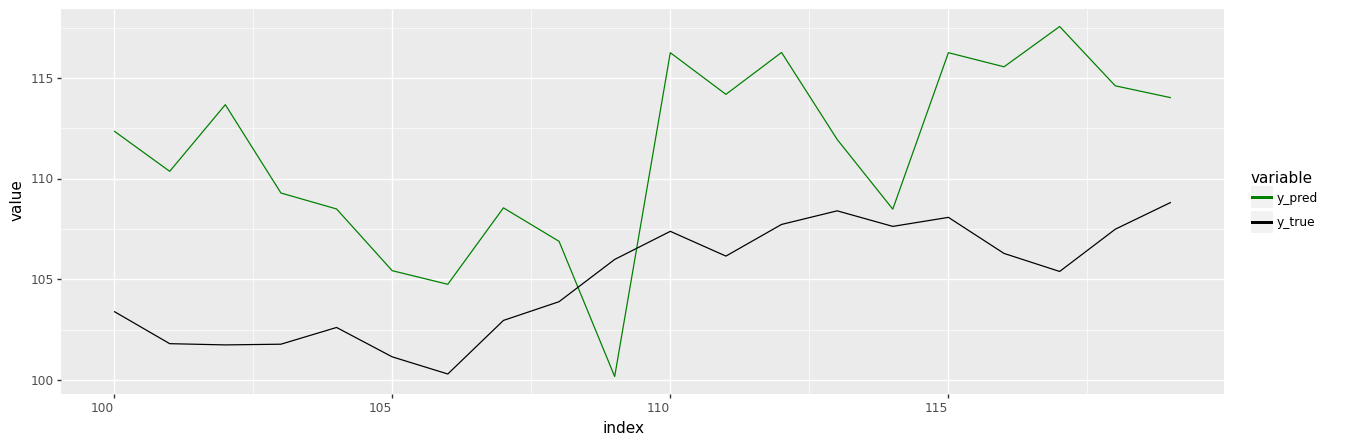

<ggplot: (-9223371874987625903)>

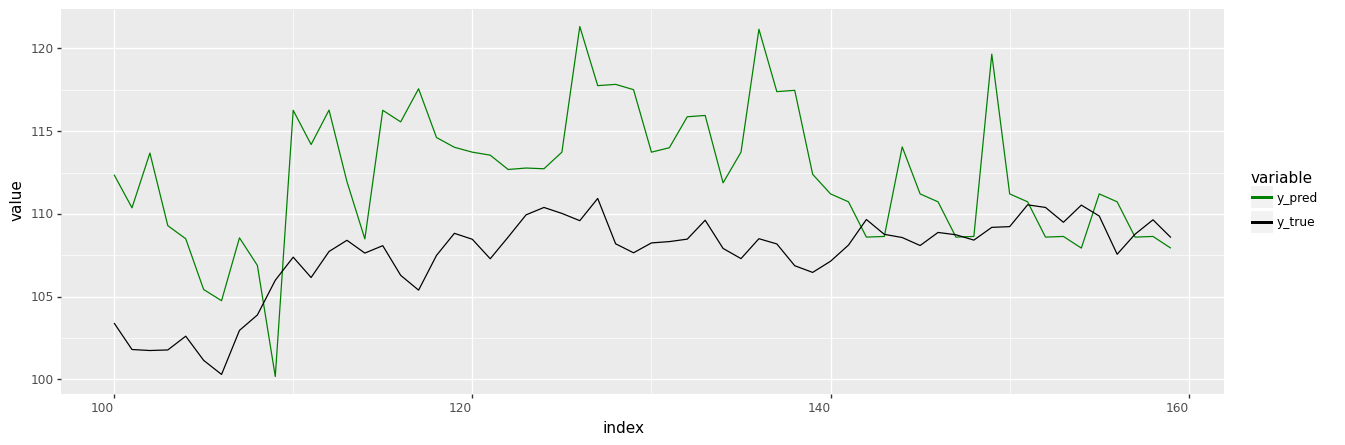

<ggplot: (-9223371874987817689)>

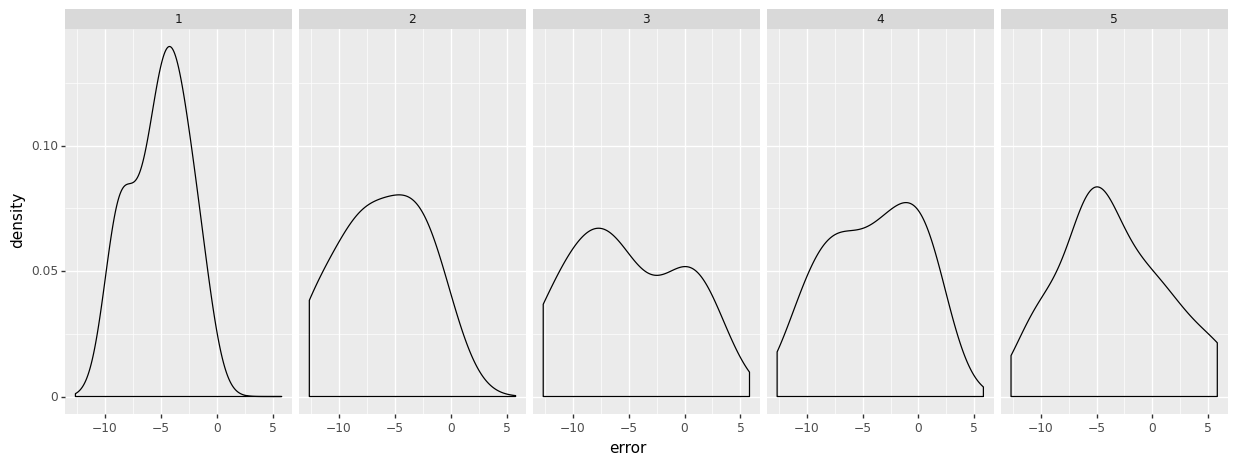

<ggplot: (161875828081)>

index     metric
0    mean_absolute_error_   5.279391
1  median_absolute_error_   5.369549
2     mean_squared_error_  40.045326

Null hypothesis: no conditional heterescedastity


stats    value
0    Lagrange multiplier test statistic  8.51514
1  p-value for Lagrange multiplier test  0.66655
2                 fstatistic for F test  0.70747
3                     pvalue for F test  0.72349

Null hypothesis: residuals are not autocorrelated
Statistic values:
[ 2.69074  5.73672  5.90137  6.60424  6.60499 11.14067 11.97295 18.31014
 18.35843 19.314   19.87915 43.21559 44.41196 49.26533 49.92833 50.07198
 50.32475 53.91956 56.06374 62.99647 64.57564 65.053   65.45977 75.99407
 76.00949 78.8995  80.02714 80.35166]
p-values:
[1.0093e-01 5.6790e-02 1.1651e-01 1.5834e-01 2.5171e-01 8.4120e-02
 1.0145e-01 1.9020e-02 3.1240e-02 3.6450e-02 4.7030e-02 2.0000e-05
 3.0000e-05 1.0000e-05 1.0000e-05 2.0000e-05 4.0000e-05 2.0000e-05
 2.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-05 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


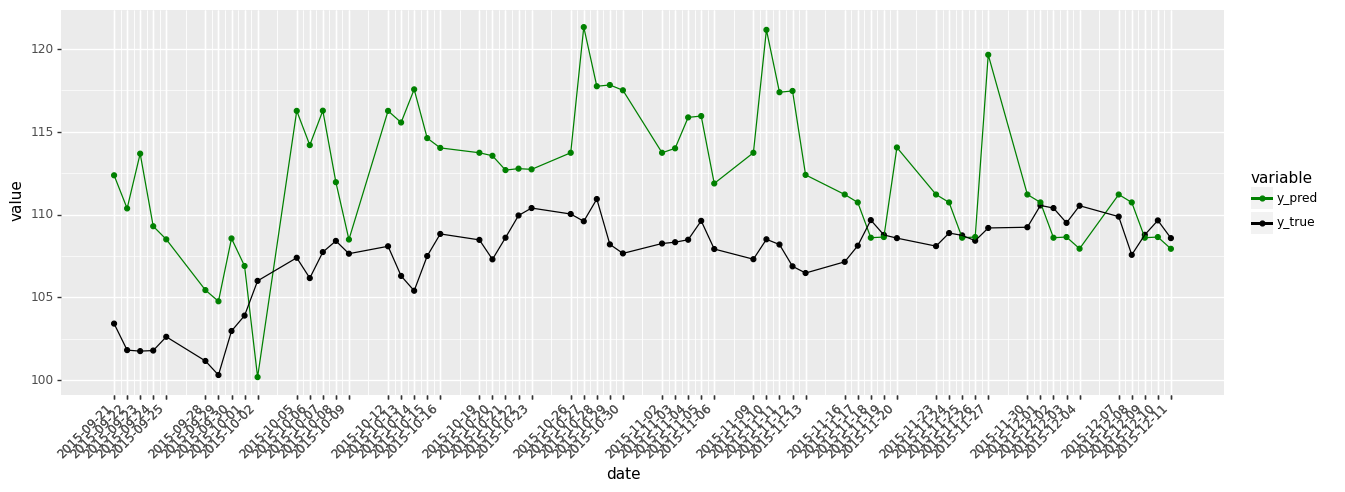

<ggplot: (161869331453)>

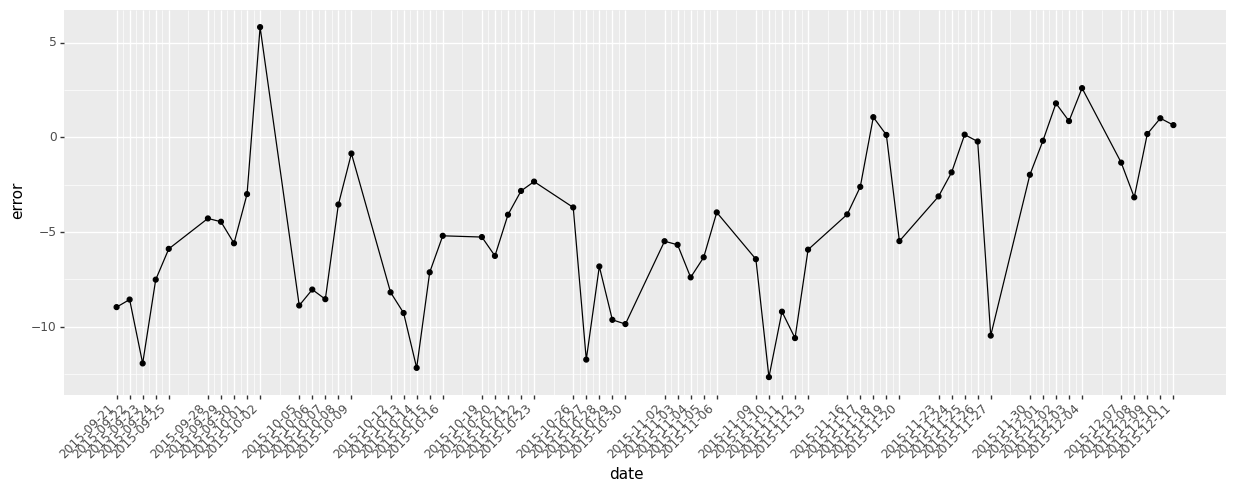

<ggplot: (-9223371874986218587)>

0
mean_error_true                0.049405
mean_error_pred                0.046290
mean_error_true_weighted_true  0.049109
mean_error_pred_weighted_pred  0.047008
median_error_true              0.049480
median_error_pred              0.047146
std_error                      0.032833
mean_error_squared             0.047008

In [204]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100
test_len_min   = pred_len * pred_n 

train_back_len_min = 0
test_back_len_min  = 0

%run "modules\\models2"

# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
    # general
    ts          = ts     # szereg czasowy
    ,start_point = 0      # indeks pierwszej obserwacji
    ,var_date    = 'date' # nazwa kolumny z datą

    # fold
    ,fold_n     = fold_n      # ilosc foldow
    ,fold_shift = pred_len * pred_n  # przesuniecie miedzy kolejnymi foldami

    # train_test 
    ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
    ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
    ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
    ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
    ,train_test_gap    = 1              # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False

    # train
    ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
    ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
    ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
    ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
    ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start

    # test
    ,test_back_len_min    = test_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
    ,test_pred_len        = pred_len          # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
    ,test_back_pred_shift = pred_len          # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
    ,test_back_pred_gap   = 1                 # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
    ,test_back_pred_fixed_start = False       # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )



# MODEL

import pyearth
from pyearth import Earth

model_mars = Earth(max_degree=1, penalty=1.0, endspan=5)

res = regression(   ts = ts
                  , var_y          = [ts_var_1]
                  , var_x_shift    = [ts_var_3, ts_var_4]
                  , var_x_no_shift = [ts_var_2]
                  , TS_idx         = TS_idx
                  , forecast_start_shift = 0
                  , model          = model_mars
                  , model_name     = 'REG_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))



# VISUALISATION

# no aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')



# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]

## Gaussian Process

1.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
0      0          1              1.0 2015-05-04     1                    1
0      5          1              1.0 2015-05-11     1                    1
0     10          1              1.0 2015-05-18     1                    1
0     15          1              1.0 2015-05-25     1                    1
0     20          1              1.0 2015-06-01     1                    1
0     25          1              1.0 2015-06-08     1                    1
0     30          1              1.0 2015-06-15     1                    1
0     35          1              1.0 2015-06-22     1                    1
0     40          1              1.0 2015-06-29     1                    1
0     45          1              1.0 2015-07-06     1                    1
0     50          1              1.0 2015-07-13     1                    1
0     55          1              1.0 2015-07-20     1                    1
0     60     

3.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
2      2          3              3.0 2015-05-06     1                    3
2      7          3              3.0 2015-05-13     1                    3
2     12          3              3.0 2015-05-20     1                    3
2     17          3              3.0 2015-05-27     1                    3
2     22          3              3.0 2015-06-03     1                    3
2     27          3              3.0 2015-06-10     1                    3
2     32          3              3.0 2015-06-17     1                    3
2     37          3              3.0 2015-06-24     1                    3
2     42          3              3.0 2015-07-01     1                    3
2     47          3              3.0 2015-07-08     1                    3
2     52          3              3.0 2015-07-15     1                    3
2     57          3              3.0 2015-07-22     1                    3
2     62     

5.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
4      4          5              5.0 2015-05-08     1                    5
4      9          5              5.0 2015-05-15     1                    5
4     14          5              5.0 2015-05-22     1                    5
4     19          5              5.0 2015-05-29     1                    5
4     24          5              5.0 2015-06-05     1                    5
4     29          5              5.0 2015-06-12     1                    5
4     34          5              5.0 2015-06-19     1                    5
4     39          5              5.0 2015-06-26     1                    5
4     44          5              5.0 2015-07-03     1                    5
4     49          5              5.0 2015-07-10     1                    5
4     54          5              5.0 2015-07-17     1                    5
4     59          5              5.0 2015-07-24     1                    5
4     64     

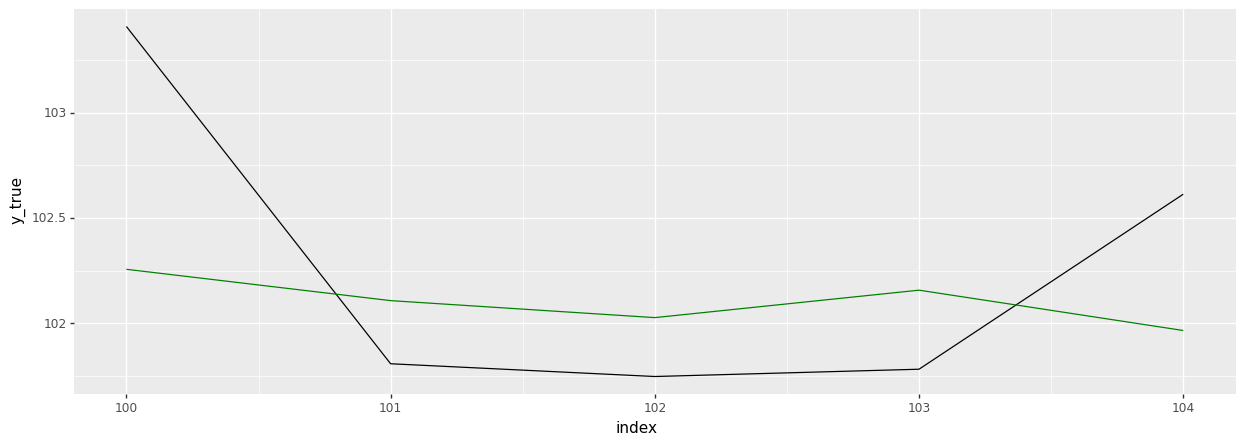

<ggplot: (121897392276)>

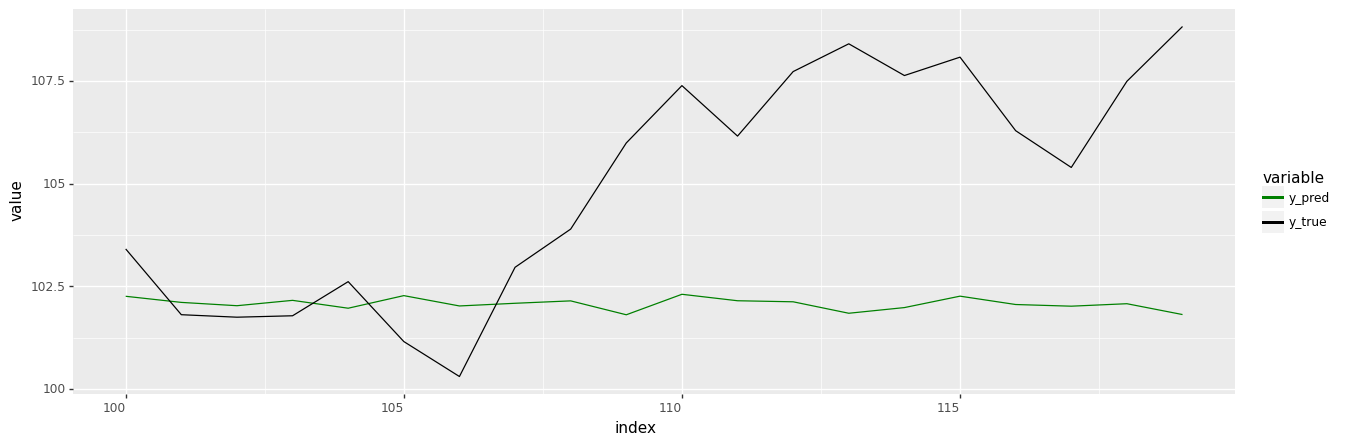

<ggplot: (121901714738)>

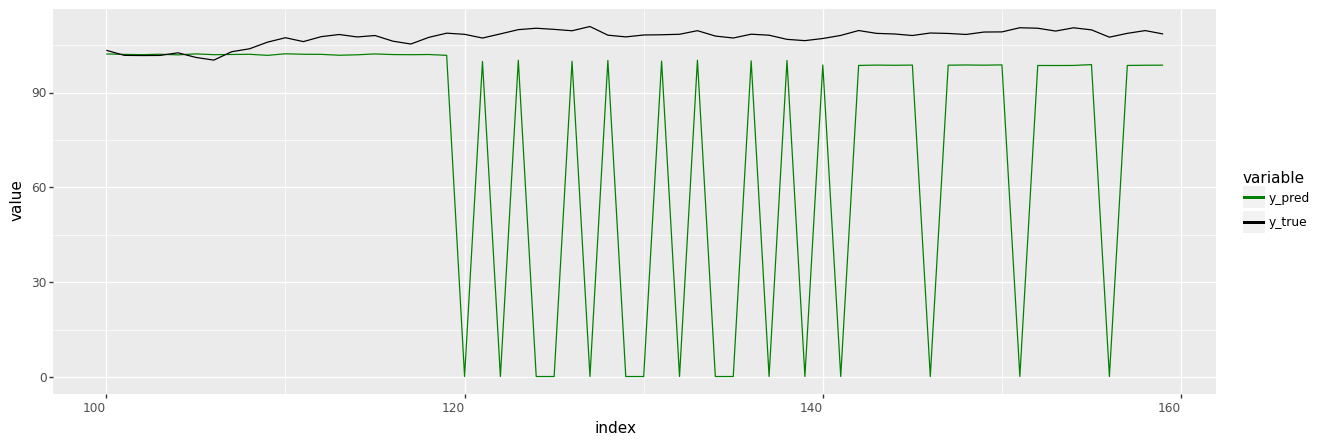

<ggplot: (-9223371914968182584)>

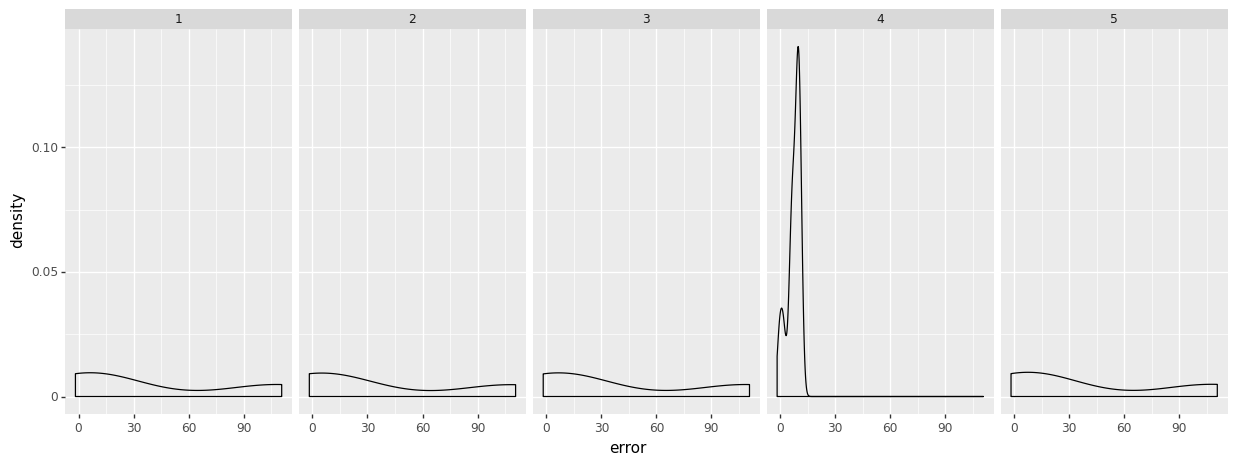

<ggplot: (121898527636)>

index       metric
0    mean_absolute_error_    33.892732
1  median_absolute_error_     9.676513
2     mean_squared_error_  3179.350728

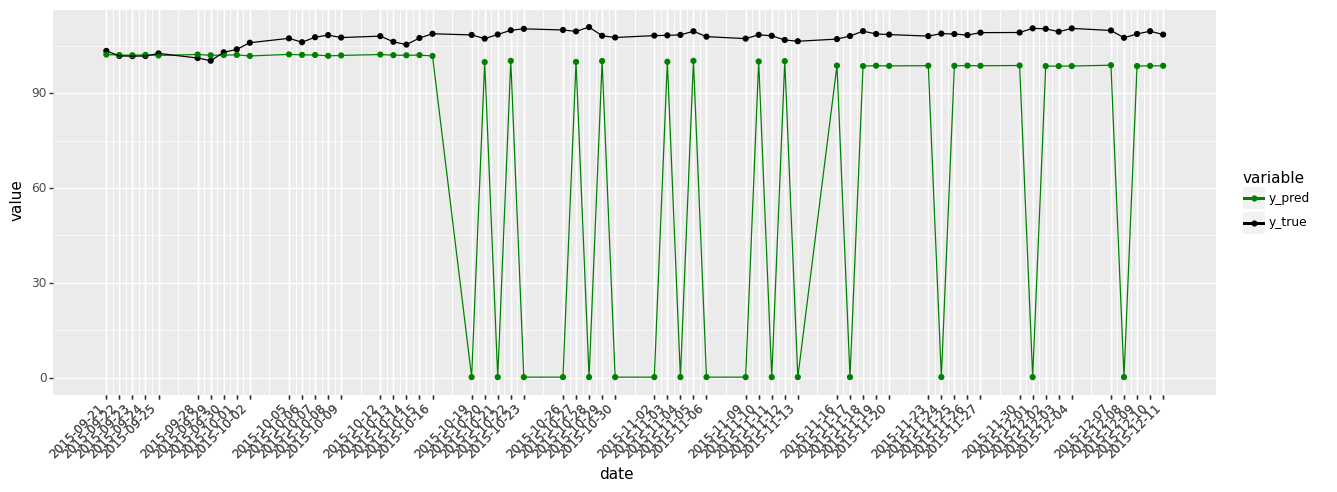

<ggplot: (-9223371914957842295)>

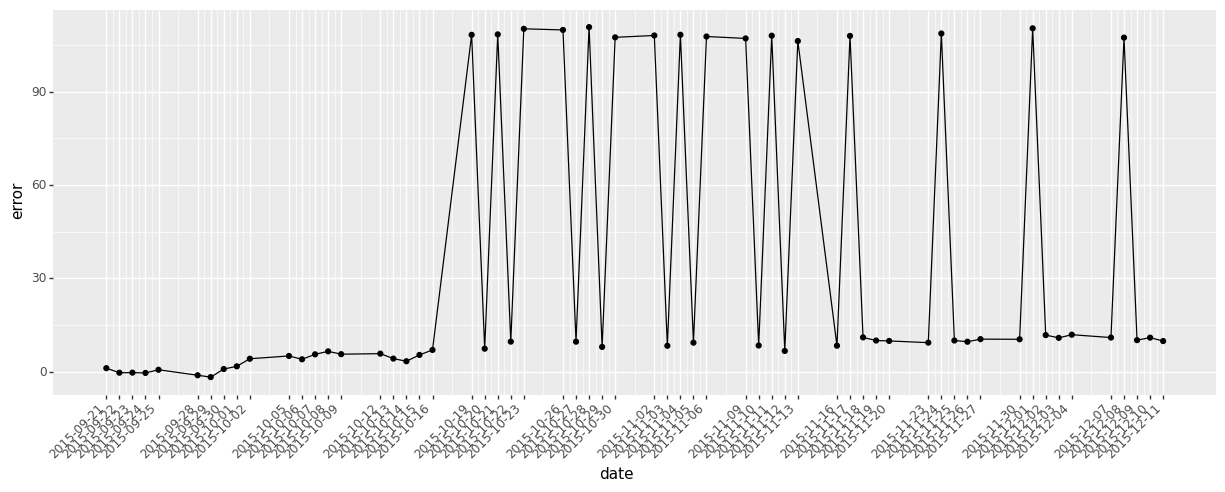

<ggplot: (121898617215)>

0
mean_error_true                  0.312108
mean_error_pred                159.096605
mean_error_true_weighted_true    0.315270
mean_error_pred_weighted_pred    0.459640
median_error_true                0.088639
median_error_pred                0.097260
std_error                        0.414802
mean_error_squared               0.459640

In [48]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100
test_len_min   = pred_len * pred_n 

train_back_len_min = 0
test_back_len_min  = 0

%run "modules\\models2"

# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
    # general
    ts          = ts     # szereg czasowy
    ,start_point = 0      # indeks pierwszej obserwacji
    ,var_date    = 'date' # nazwa kolumny z datą

    # fold
    ,fold_n     = fold_n      # ilosc foldow
    ,fold_shift = pred_len * pred_n  # przesuniecie miedzy kolejnymi foldami

    # train_test 
    ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
    ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
    ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
    ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
    ,train_test_gap    = 1              # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False

    # train
    ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
    ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
    ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
    ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
    ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start

    # test
    ,test_back_len_min    = test_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
    ,test_pred_len        = pred_len          # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
    ,test_back_pred_shift = pred_len          # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
    ,test_back_pred_gap   = 1                 # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
    ,test_back_pred_fixed_start = False       # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )

# MODEL
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, DotProduct

# definiowanie kernela
kernel = 1.0 * RBF(length_scale=20) + ExpSineSquared(periodicity=5, length_scale=15) + WhiteKernel()

# kernel = 1.0 * RBF(length_scale=50) + ExpSineSquared(periodicity=6, length_scale=25)

# okreslenie modelu
model_ = GaussianProcessRegressor(kernel=kernel)

ts[ts_var_1 + '_dp'] = ts[ts_var_1]

res = regression(   ts = ts
                  , var_y          = [ts_var_1]
                  , var_x_shift    = [ts_var_3, ts_var_4, ts_var_1 + '_dp']
                  , var_x_no_shift = [ts_var_2]
                  , TS_idx         = TS_idx
                  , forecast_start_shift = 0
                  , model          = model_
                  , model_name     = 'REG_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))



# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)

# not aggregated residuals diagnostics
h('Arch test')
# test_HET_ARCH(res)
# h('Ljung box autocorrelation test')
# test_LJUNG(res)
# h('BDS test')
# test_BSD(res)

# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]


## Regression sklearn

1.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
0      0          1              1.0 2015-05-04     1                    1
0      5          1              1.0 2015-05-11     1                    1
0     10          1              1.0 2015-05-18     1                    1
0     15          1              1.0 2015-05-25     1                    1
0     20          1              1.0 2015-06-01     1                    1
0     25          1              1.0 2015-06-08     1                    1
0     30          1              1.0 2015-06-15     1                    1
0     35          1              1.0 2015-06-22     1                    1
0     40          1              1.0 2015-06-29     1                    1
0     45          1              1.0 2015-07-06     1                    1
0     50          1              1.0 2015-07-13     1                    1
0     55          1              1.0 2015-07-20     1                    1
0     60     

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
0     20          1              1.0 2015-06-01     1                    1
0     25          1              1.0 2015-06-08     1                    1
0     30          1              1.0 2015-06-15     1                    1
0     35          1              1.0 2015-06-22     1                    1
0     40          1              1.0 2015-06-29     1                    1
0     45          1              1.0 2015-07-06     1                    1
0     50          1              1.0 2015-07-13     1                    1
0     55          1              1.0 2015-07-20     1                    1
0     60          1              1.0 2015-07-27     1                    1
0     65          1              1.0 2015-08-03     1                    1
0     70          1              1.0 2015-08-10     1                    1
0     75          1              1.0 2015-08-17     1                    1
0     80          1 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
0     40          1              1.0 2015-06-29     1                    1
0     45          1              1.0 2015-07-06     1                    1
0     50          1              1.0 2015-07-13     1                    1
0     55          1              1.0 2015-07-20     1                    1
0     60          1              1.0 2015-07-27     1                    1
0     65          1              1.0 2015-08-03     1                    1
0     70          1              1.0 2015-08-10     1                    1
0     75          1              1.0 2015-08-17     1                    1
0     80          1              1.0 2015-08-24     1                    1
0     85          1              1.0 2015-08-31     1                    1
0     90          1              1.0 2015-09-07     1                    1
0     95          1              1.0 2015-09-14     1                    1
0    100          1 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
1      1          2              2.0 2015-05-05     1                    2
1      6          2              2.0 2015-05-12     1                    2
1     11          2              2.0 2015-05-19     1                    2
1     16          2              2.0 2015-05-26     1                    2
1     21          2              2.0 2015-06-02     1                    2
1     26          2              2.0 2015-06-09     1                    2
1     31          2              2.0 2015-06-16     1                    2
1     36          2              2.0 2015-06-23     1                    2
1     41          2              2.0 2015-06-30     1                    2
1     46          2              2.0 2015-07-07     1                    2
1     51          2              2.0 2015-07-14     1                    2
1     56          2              2.0 2015-07-21     1                    2
1     61     

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
1     21          2              2.0 2015-06-02     1                    2
1     26          2              2.0 2015-06-09     1                    2
1     31          2              2.0 2015-06-16     1                    2
1     36          2              2.0 2015-06-23     1                    2
1     41          2              2.0 2015-06-30     1                    2
1     46          2              2.0 2015-07-07     1                    2
1     51          2              2.0 2015-07-14     1                    2
1     56          2              2.0 2015-07-21     1                    2
1     61          2              2.0 2015-07-28     1                    2
1     66          2              2.0 2015-08-04     1                    2
1     71          2              2.0 2015-08-11     1                    2
1     76          2              2.0 2015-08-18     1                    2
1     81          2 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
1     41          2              2.0 2015-06-30     1                    2
1     46          2              2.0 2015-07-07     1                    2
1     51          2              2.0 2015-07-14     1                    2
1     56          2              2.0 2015-07-21     1                    2
1     61          2              2.0 2015-07-28     1                    2
1     66          2              2.0 2015-08-04     1                    2
1     71          2              2.0 2015-08-11     1                    2
1     76          2              2.0 2015-08-18     1                    2
1     81          2              2.0 2015-08-25     1                    2
1     86          2              2.0 2015-09-01     1                    2
1     91          2              2.0 2015-09-08     1                    2
1     96          2              2.0 2015-09-15     1                    2
1    101          2 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
2      2          3              3.0 2015-05-06     1                    3
2      7          3              3.0 2015-05-13     1                    3
2     12          3              3.0 2015-05-20     1                    3
2     17          3              3.0 2015-05-27     1                    3
2     22          3              3.0 2015-06-03     1                    3
2     27          3              3.0 2015-06-10     1                    3
2     32          3              3.0 2015-06-17     1                    3
2     37          3              3.0 2015-06-24     1                    3
2     42          3              3.0 2015-07-01     1                    3
2     47          3              3.0 2015-07-08     1                    3
2     52          3              3.0 2015-07-15     1                    3
2     57          3              3.0 2015-07-22     1                    3
2     62     

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
2     22          3              3.0 2015-06-03     1                    3
2     27          3              3.0 2015-06-10     1                    3
2     32          3              3.0 2015-06-17     1                    3
2     37          3              3.0 2015-06-24     1                    3
2     42          3              3.0 2015-07-01     1                    3
2     47          3              3.0 2015-07-08     1                    3
2     52          3              3.0 2015-07-15     1                    3
2     57          3              3.0 2015-07-22     1                    3
2     62          3              3.0 2015-07-29     1                    3
2     67          3              3.0 2015-08-05     1                    3
2     72          3              3.0 2015-08-12     1                    3
2     77          3              3.0 2015-08-19     1                    3
2     82          3 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
2     42          3              3.0 2015-07-01     1                    3
2     47          3              3.0 2015-07-08     1                    3
2     52          3              3.0 2015-07-15     1                    3
2     57          3              3.0 2015-07-22     1                    3
2     62          3              3.0 2015-07-29     1                    3
2     67          3              3.0 2015-08-05     1                    3
2     72          3              3.0 2015-08-12     1                    3
2     77          3              3.0 2015-08-19     1                    3
2     82          3              3.0 2015-08-26     1                    3
2     87          3              3.0 2015-09-02     1                    3
2     92          3              3.0 2015-09-09     1                    3
2     97          3              3.0 2015-09-16     1                    3
2    102          3 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


4.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
3      3          4              4.0 2015-05-07     1                    4
3      8          4              4.0 2015-05-14     1                    4
3     13          4              4.0 2015-05-21     1                    4
3     18          4              4.0 2015-05-28     1                    4
3     23          4              4.0 2015-06-04     1                    4
3     28          4              4.0 2015-06-11     1                    4
3     33          4              4.0 2015-06-18     1                    4
3     38          4              4.0 2015-06-25     1                    4
3     43          4              4.0 2015-07-02     1                    4
3     48          4              4.0 2015-07-09     1                    4
3     53          4              4.0 2015-07-16     1                    4
3     58          4              4.0 2015-07-23     1                    4
3     63     

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
3     23          4              4.0 2015-06-04     1                    4
3     28          4              4.0 2015-06-11     1                    4
3     33          4              4.0 2015-06-18     1                    4
3     38          4              4.0 2015-06-25     1                    4
3     43          4              4.0 2015-07-02     1                    4
3     48          4              4.0 2015-07-09     1                    4
3     53          4              4.0 2015-07-16     1                    4
3     58          4              4.0 2015-07-23     1                    4
3     63          4              4.0 2015-07-30     1                    4
3     68          4              4.0 2015-08-06     1                    4
3     73          4              4.0 2015-08-13     1                    4
3     78          4              4.0 2015-08-20     1                    4
3     83          4 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
3     43          4              4.0 2015-07-02     1                    4
3     48          4              4.0 2015-07-09     1                    4
3     53          4              4.0 2015-07-16     1                    4
3     58          4              4.0 2015-07-23     1                    4
3     63          4              4.0 2015-07-30     1                    4
3     68          4              4.0 2015-08-06     1                    4
3     73          4              4.0 2015-08-13     1                    4
3     78          4              4.0 2015-08-20     1                    4
3     83          4              4.0 2015-08-27     1                    4
3     88          4              4.0 2015-09-03     1                    4
3     93          4              4.0 2015-09-10     1                    4
3     98          4              4.0 2015-09-17     1                    4
3    103          4 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


5.0s
a
1f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
4      4          5              5.0 2015-05-08     1                    5
4      9          5              5.0 2015-05-15     1                    5
4     14          5              5.0 2015-05-22     1                    5
4     19          5              5.0 2015-05-29     1                    5
4     24          5              5.0 2015-06-05     1                    5
4     29          5              5.0 2015-06-12     1                    5
4     34          5              5.0 2015-06-19     1                    5
4     39          5              5.0 2015-06-26     1                    5
4     44          5              5.0 2015-07-03     1                    5
4     49          5              5.0 2015-07-10     1                    5
4     54          5              5.0 2015-07-17     1                    5
4     59          5              5.0 2015-07-24     1                    5
4     64     

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
4     24          5              5.0 2015-06-05     1                    5
4     29          5              5.0 2015-06-12     1                    5
4     34          5              5.0 2015-06-19     1                    5
4     39          5              5.0 2015-06-26     1                    5
4     44          5              5.0 2015-07-03     1                    5
4     49          5              5.0 2015-07-10     1                    5
4     54          5              5.0 2015-07-17     1                    5
4     59          5              5.0 2015-07-24     1                    5
4     64          5              5.0 2015-07-31     1                    5
4     69          5              5.0 2015-08-07     1                    5
4     74          5              5.0 2015-08-14     1                    5
4     79          5              5.0 2015-08-21     1                    5
4     84          5 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3f
b
   index  index_rel  index_rel_shift       date  pred  index_back_pred_rel
4     44          5              5.0 2015-07-03     1                    5
4     49          5              5.0 2015-07-10     1                    5
4     54          5              5.0 2015-07-17     1                    5
4     59          5              5.0 2015-07-24     1                    5
4     64          5              5.0 2015-07-31     1                    5
4     69          5              5.0 2015-08-07     1                    5
4     74          5              5.0 2015-08-14     1                    5
4     79          5              5.0 2015-08-21     1                    5
4     84          5              5.0 2015-08-28     1                    5
4     89          5              5.0 2015-09-04     1                    5
4     94          5              5.0 2015-09-11     1                    5
4     99          5              5.0 2015-09-18     1                    5
4    104          5 

C:\Users\memy\OneDrive\Pulpit\1_Programs_and_programing\DS_proj\time_series_python\modules\models2.py:1866: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


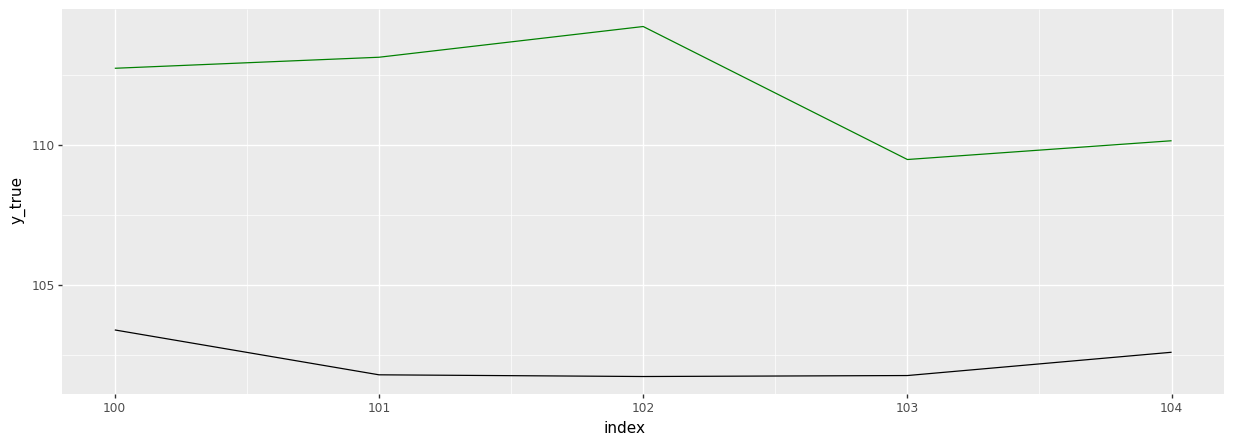

<ggplot: (161868805391)>

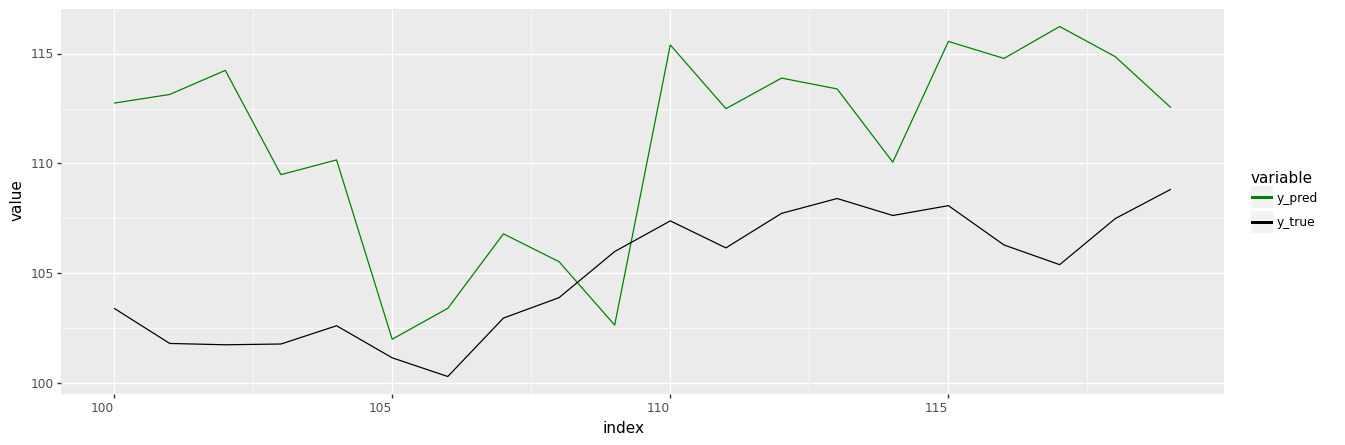

<ggplot: (-9223371874985975566)>

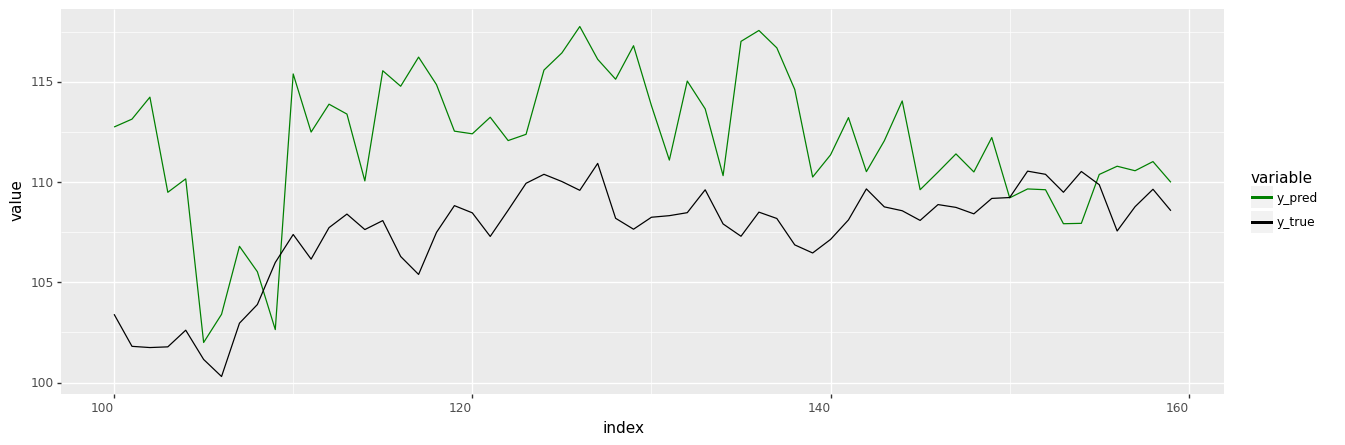

<ggplot: (161873689422)>

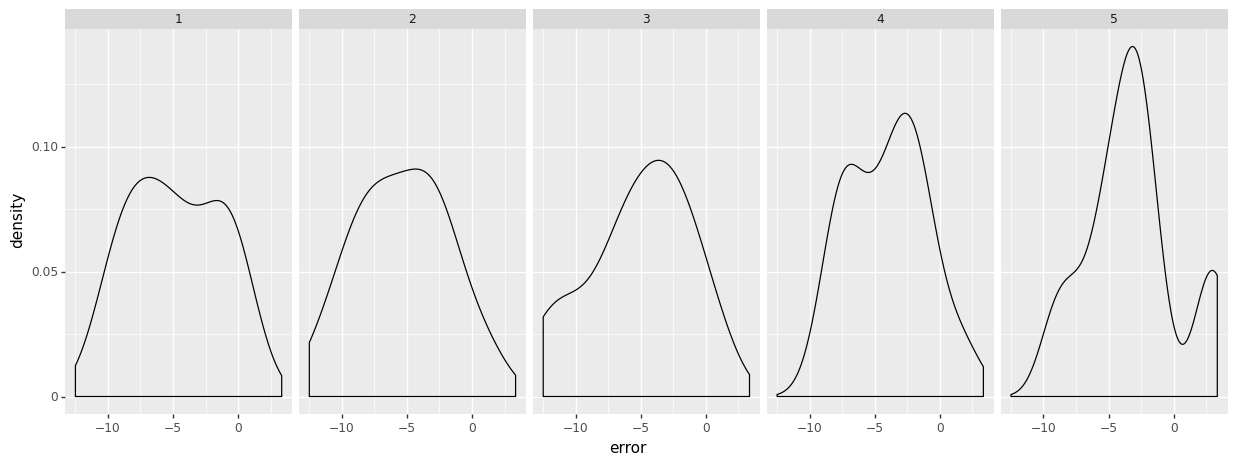

<ggplot: (161868837019)>

index     metric
0    mean_absolute_error_   4.802492
1  median_absolute_error_   3.990339
2     mean_squared_error_  32.394476

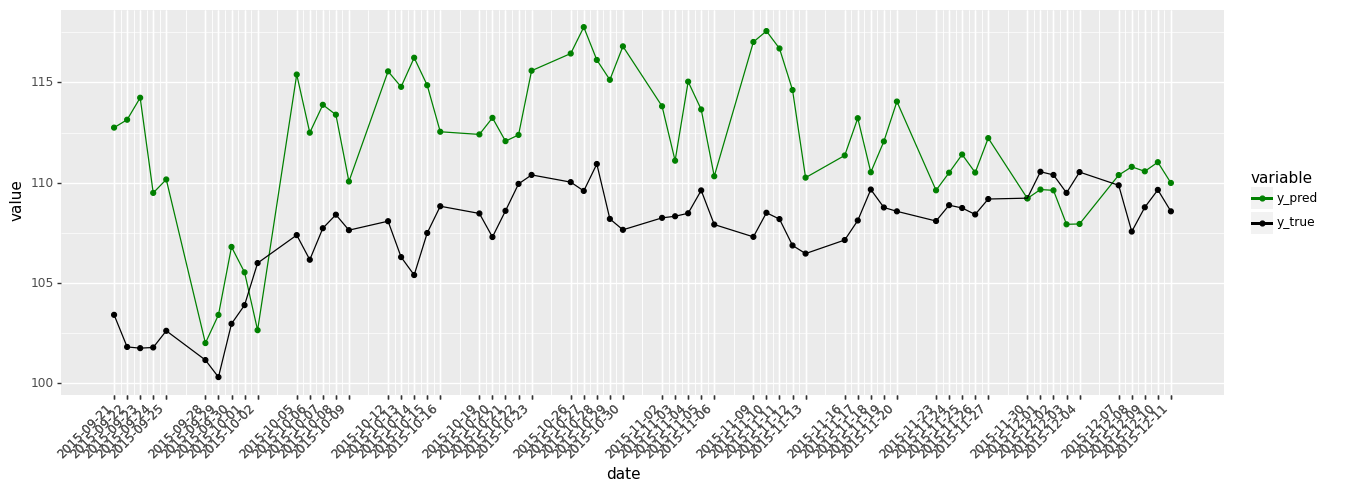

<ggplot: (161873661255)>

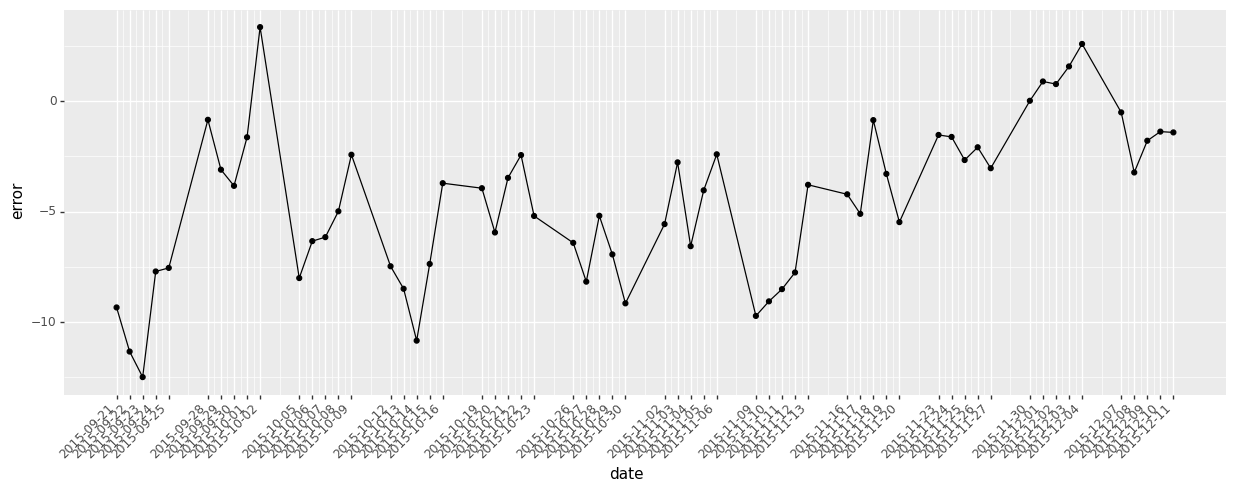

<ggplot: (161873661374)>

0
mean_error_true                0.044958
mean_error_pred                0.042351
mean_error_true_weighted_true  0.044673
mean_error_pred_weighted_pred  0.042879
median_error_true              0.037046
median_error_pred              0.035722
std_error                      0.029160
mean_error_squared             0.042879

In [154]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100
test_len_min   = pred_len * pred_n 

train_back_len_min = 0
test_back_len_min  = 0

%run "modules\\models2"

# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
    # general
    ts          = ts     # szereg czasowy
    ,start_point = 0      # indeks pierwszej obserwacji
    ,var_date    = 'date' # nazwa kolumny z datą

    # fold
    ,fold_n     = fold_n      # ilosc foldow
    ,fold_shift = pred_len * pred_n  # przesuniecie miedzy kolejnymi foldami

    # train_test 
    ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
    ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
    ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
    ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
    ,train_test_gap    = 1              # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False

    # train
    ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
    ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
    ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
    ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
    ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start

    # test
    ,test_back_len_min    = test_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
    ,test_pred_len        = pred_len          # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
    ,test_back_pred_shift = pred_len          # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
    ,test_back_pred_gap   = 1                 # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
    ,test_back_pred_fixed_start = False       # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )




# # PARAMETERS
# train_len  = 100 # dlugosc proby uczacej
# fold_n     = 3   # ilosc foldow (ile razy bedzie uczenie modelu)
# fold_shift = 10  # przesuniecie folda (bo jaki okres bedzie uczenie modelu)
# test_len   = fold_shift  # dlugosc okres wszyskich predykcji na kazdym foldzie (do ile lacznie okresow bedzie uzyty model do predykcji)
# test_shift = pred_len   # dlugosc pojedynczej predykcji

# # INDICIES
# TS_idx = TS_indicies( ts = ts
#                     ,var_date = 'date'
#                     #
#                     ,fold_n      = fold_n
#                     ,fold_shift  = fold_shift
#                     #
#                     ,train_len   = train_len
#                     ,test_len    = test_len
#                     ,train_test_shift = 1
#                     #
#                     ,train_back_len = 0 # brane tylko do odliczania index_rel_shift wzgledem back
#                     ,train_pred_len = test_shift 
#                     ,train_shift    = 1 # zazwyczaj na train daje co jeden zeby model mial wiecel obserwacji do wytrenowania
#                     ,train_back_pred_shift = 1 # zazwyczaj jeden
#                     #
#                     ,test_back_len = 0 # brane tylko do odliczania index_rel_shift wzgledem back
#                     ,test_pred_len = test_shift
#                     ,test_shift    = test_shift # zazwyczaj na test daje tak aby prognozy sie nie pokrywaly (test_pred_len = test_shift)
#                     ,test_back_pred_shift = 1 # zazwyczaj jeden
#                     #
#                     ,move_fold_start_point = True
#                     ,start_point = 0)

# MODEL
import sklearn as sklearn
model_ = sklearn.ensemble._forest.RandomForestRegressor()
# model_ = sklearn.ensemble.AdaBoostRegressor()
# model_ = sklearn.ensemble.GradientBoostingRegressor()
# import catboost
# model_ = catboost.CatBoostClassifier()
# import lightgbm
# model_ = lightgbm.LGBMClassifier()

res = regression(   ts = ts
                  , var_y          = [ts_var_1]
                  , var_x_shift    = [ts_var_3, ts_var_4]
                  , var_x_no_shift = [ts_var_2]
                  , TS_idx         = TS_idx
                  , forecast_start_shift = 0
                  , model          = model_
                  , model_name     = 'REG_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))



# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)



# not aggregated residuals diagnostics
h('Arch test')
# test_HET_ARCH(res)
# h('Ljung box autocorrelation test')
# test_LJUNG(res)
# h('BDS test')
# test_BSD(res)


# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]

## Neural network n1_n1

### LSTM

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 10851.0908
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 10444.7617
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 10063.8926
Epoch 4/1000
1/1 [==============================] - 0s 0s/step - loss: 9461.5527
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 8659.4277
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 7631.4233
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 6441.0073
Epoch 8/1000
1/1 [==============================] - 0s 1000us/step - loss: 5386.9043
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 4586.2202
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 3606.4785
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 2820.9353
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 2004.5206
Epoch 13

1/1 [==============================] - 0s 0s/step - loss: 8.0894
Epoch 200/1000
1/1 [==============================] - 0s 0s/step - loss: 8.0818
Epoch 201/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.0741
Epoch 202/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.0663
Epoch 203/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.0583
Epoch 204/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.0502
Epoch 205/1000
1/1 [==============================] - 0s 997us/step - loss: 8.0418
Epoch 206/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.0332
Epoch 207/1000
1/1 [==============================] - 0s 0s/step - loss: 8.0243
Epoch 208/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.0148
Epoch 209/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.0045
Epoch 210/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.9922
Epoch 211/1000
1/1 [========================

Epoch 300/1000
1/1 [==============================] - 0s 0s/step - loss: 6.3197
Epoch 301/1000
1/1 [==============================] - 0s 1000us/step - loss: 6.2889
Epoch 302/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.2808
Epoch 303/1000
1/1 [==============================] - 0s 1000us/step - loss: 6.2940
Epoch 304/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.2948
Epoch 305/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.2758
Epoch 306/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.2566
Epoch 307/1000
1/1 [==============================] - 0s 998us/step - loss: 6.2553
Epoch 308/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.2465
Epoch 309/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.2434
Epoch 310/1000
1/1 [==============================] - 0s 1000us/step - loss: 6.2403
Epoch 311/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.2360
Epoch 312/1000
1/1

1/1 [==============================] - 0s 1ms/step - loss: 5.6103
Epoch 501/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5847
Epoch 502/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.6621
Epoch 503/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5643
Epoch 504/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5757
Epoch 505/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.6175
Epoch 506/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5408
Epoch 507/1000
1/1 [==============================] - 0s 0s/step - loss: 5.5495
Epoch 508/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5875
Epoch 509/1000
1/1 [==============================] - 0s 0s/step - loss: 5.5319
Epoch 510/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5104
Epoch 511/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5515
Epoch 512/1000
1/1 [=========================

1/1 [==============================] - 0s 1ms/step - loss: 5.3893
Epoch 602/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.6260
Epoch 603/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.4534
Epoch 604/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.4194
Epoch 605/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.5604
Epoch 606/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.3943
Epoch 607/1000
1/1 [==============================] - 0s 0s/step - loss: 5.4296
Epoch 608/1000
1/1 [==============================] - 0s 1000us/step - loss: 5.4931
Epoch 609/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.3602
Epoch 610/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.4107
Epoch 611/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.4391
Epoch 612/1000
1/1 [==============================] - 0s 0s/step - loss: 5.3381
Epoch 613/1000
1/1 [======================

1/1 [==============================] - 0s 1ms/step - loss: 5.2854
Epoch 703/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2835
Epoch 704/1000
1/1 [==============================] - 0s 0s/step - loss: 5.2822
Epoch 705/1000
1/1 [==============================] - 0s 0s/step - loss: 5.2773
Epoch 706/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2719
Epoch 707/1000
1/1 [==============================] - 0s 0s/step - loss: 5.2673
Epoch 708/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2621
Epoch 709/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2578
Epoch 710/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2539
Epoch 711/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2496
Epoch 712/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2464
Epoch 713/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2438
Epoch 714/1000
1/1 [==========================

1/1 [==============================] - 0s 1ms/step - loss: 5.1350
Epoch 904/1000
1/1 [==============================] - 0s 0s/step - loss: 6.0616
Epoch 905/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.0878
Epoch 906/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.2960
Epoch 907/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.8572
Epoch 908/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.8017
Epoch 909/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.6653
Epoch 910/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.1964
Epoch 911/1000
1/1 [==============================] - 0s 0s/step - loss: 5.0847
Epoch 912/1000
1/1 [==============================] - 0s 1000us/step - loss: 5.8550
Epoch 913/1000
1/1 [==============================] - 0s 0s/step - loss: 4.7145
Epoch 914/1000
1/1 [==============================] - 0s 999us/step - loss: 5.6501
Epoch 915/1000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 4.3136
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.3157
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.2902
Epoch 4/1000
1/1 [==============================] - 0s 0s/step - loss: 4.2529
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.2277
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.2221
Epoch 7/1000
1/1 [==============================] - 0s 1000us/step - loss: 4.2624
Epoch 8/1000
1/1 [==============================] - 0s 0s/step - loss: 4.4764
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2254
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.7171
Epoch 11/1000
1/1 [==============================] - 0s 0s/step - loss: 10.3822
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 6.7634
Epoch 13/1000
1/1 [==============================] - 0s 1ms/s

Epoch 204/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.0308
Epoch 205/1000
1/1 [==============================] - 0s 0s/step - loss: 4.1017
Epoch 206/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.1537
Epoch 207/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.1314
Epoch 208/1000
1/1 [==============================] - 0s 998us/step - loss: 4.0567
Epoch 209/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9525
Epoch 210/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8943
Epoch 211/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9089
Epoch 212/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9595
Epoch 213/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9867
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9598
Epoch 215/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9101
Epoch 216/1000
1/1 [=======

1/1 [==============================] - 0s 1ms/step - loss: 5.3411
Epoch 405/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.3647
Epoch 406/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.4618
Epoch 407/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.3015
Epoch 408/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.3831
Epoch 409/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.3944
Epoch 410/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2745
Epoch 411/1000
1/1 [==============================] - 0s 1000us/step - loss: 5.3733
Epoch 412/1000
1/1 [==============================] - 0s 0s/step - loss: 5.3214
Epoch 413/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2593
Epoch 414/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.3393
Epoch 415/1000
1/1 [==============================] - 0s 2ms/step - loss: 5.2632
Epoch 416/1000
1/1 [=====================

1/1 [==============================] - 0s 3ms/step - loss: 4.9280
Epoch 506/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.7909
Epoch 507/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.8616
Epoch 508/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.8008
Epoch 509/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.7659
Epoch 510/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.8116
Epoch 511/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.7261
Epoch 512/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.7500
Epoch 513/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.7491
Epoch 514/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.6879
Epoch 515/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.7199
Epoch 516/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.6998
Epoch 517/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 3.8878
Epoch 708/1000
1/1 [==============================] - 0s 999us/step - loss: 3.8880
Epoch 709/1000
1/1 [==============================] - 0s 0s/step - loss: 3.8865
Epoch 710/1000
1/1 [==============================] - 0s 0s/step - loss: 3.8833
Epoch 711/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8807
Epoch 712/1000
1/1 [==============================] - 0s 0s/step - loss: 3.8797
Epoch 713/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8791
Epoch 714/1000
1/1 [==============================] - 0s 0s/step - loss: 3.8766
Epoch 715/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8744
Epoch 716/1000
1/1 [==============================] - 0s 0s/step - loss: 3.8728
Epoch 717/1000
1/1 [==============================] - 0s 0s/step - loss: 3.8724
Epoch 718/1000
1/1 [==============================] - 0s 1000us/step - loss: 3.8713
Epoch 719/1000
1/1 [========================

Epoch 909/1000
1/1 [==============================] - 0s 997us/step - loss: 3.8451
Epoch 910/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9931
Epoch 911/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9904
Epoch 912/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8537
Epoch 913/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7383
Epoch 914/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.7459
Epoch 915/1000
1/1 [==============================] - 0s 0s/step - loss: 3.8398
Epoch 916/1000
1/1 [==============================] - 0s 0s/step - loss: 3.9191
Epoch 917/1000
1/1 [==============================] - 0s 0s/step - loss: 3.9174
Epoch 918/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8435
Epoch 919/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7527
Epoch 920/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7125
Epoch 921/1000
1/1 [=========

1/1 [==============================] - 0s 0s/step - loss: 3.6584
Epoch 110/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5841
Epoch 111/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5339
Epoch 112/1000
1/1 [==============================] - 0s 0s/step - loss: 3.5212
Epoch 113/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5334
Epoch 114/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5527
Epoch 115/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5730
Epoch 116/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.6242
Epoch 117/1000
1/1 [==============================] - 0s 1000us/step - loss: 3.7792
Epoch 118/1000
1/1 [==============================] - 0s 1000us/step - loss: 3.8925
Epoch 119/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7643
Epoch 120/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.6374
Epoch 121/1000
1/1 [===================

1/1 [==============================] - 0s 1ms/step - loss: 3.3818
Epoch 311/1000
1/1 [==============================] - 0s 0s/step - loss: 3.4234
Epoch 312/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5020
Epoch 313/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7688
Epoch 314/1000
1/1 [==============================] - 0s 999us/step - loss: 3.8678
Epoch 315/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7531
Epoch 316/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7741
Epoch 317/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.0254
Epoch 318/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.2379
Epoch 319/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.2847
Epoch 320/1000
1/1 [==============================] - 0s 0s/step - loss: 4.0565
Epoch 321/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9230
Epoch 322/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 3.5939
Epoch 412/1000
1/1 [==============================] - 0s 999us/step - loss: 3.5434
Epoch 413/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5067
Epoch 414/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4804
Epoch 415/1000
1/1 [==============================] - 0s 998us/step - loss: 3.4666
Epoch 416/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.4600
Epoch 417/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.4607
Epoch 418/1000
1/1 [==============================] - 0s 0s/step - loss: 3.4686
Epoch 419/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4886
Epoch 420/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5262
Epoch 421/1000
1/1 [==============================] - 0s 1000us/step - loss: 3.5961
Epoch 422/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.7040
Epoch 423/1000
1/1 [=================

1/1 [==============================] - 0s 0s/step - loss: 3.4657
Epoch 614/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8168
Epoch 615/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9897
Epoch 616/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7211
Epoch 617/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.3725
Epoch 618/1000
1/1 [==============================] - 0s 1000us/step - loss: 3.5642
Epoch 619/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.2493
Epoch 620/1000
1/1 [==============================] - 0s 999us/step - loss: 4.7302
Epoch 621/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.2660
Epoch 622/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6009
Epoch 623/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.1275
Epoch 624/1000
1/1 [==============================] - 0s 0s/step - loss: 4.7027
Epoch 625/1000
1/1 [====================

1/1 [==============================] - 0s 1ms/step - loss: 3.4211
Epoch 815/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.6089
Epoch 816/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.3487
Epoch 817/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5013
Epoch 818/1000
1/1 [==============================] - 0s 0s/step - loss: 3.3456
Epoch 819/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.4267
Epoch 820/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.3233
Epoch 821/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.4075
Epoch 822/1000
1/1 [==============================] - 0s 1000us/step - loss: 3.2713
Epoch 823/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.3210
Epoch 824/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.2983
Epoch 825/1000
1/1 [==============================] - 0s 0s/step - loss: 3.2995
Epoch 826/1000
1/1 [======================

1/1 [==============================] - 0s 999us/step - loss: 7.6345
Epoch 916/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.1615
Epoch 917/1000
1/1 [==============================] - 0s 1000us/step - loss: 7.2851
Epoch 918/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.5638
Epoch 919/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.7520
Epoch 920/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.1816
Epoch 921/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.4864
Epoch 922/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.2585
Epoch 923/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.2542
Epoch 924/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.1583
Epoch 925/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.1485
Epoch 926/1000
1/1 [==============================] - 0s 1ms/step - loss: 7.0982
Epoch 927/1000
1/1 [==================

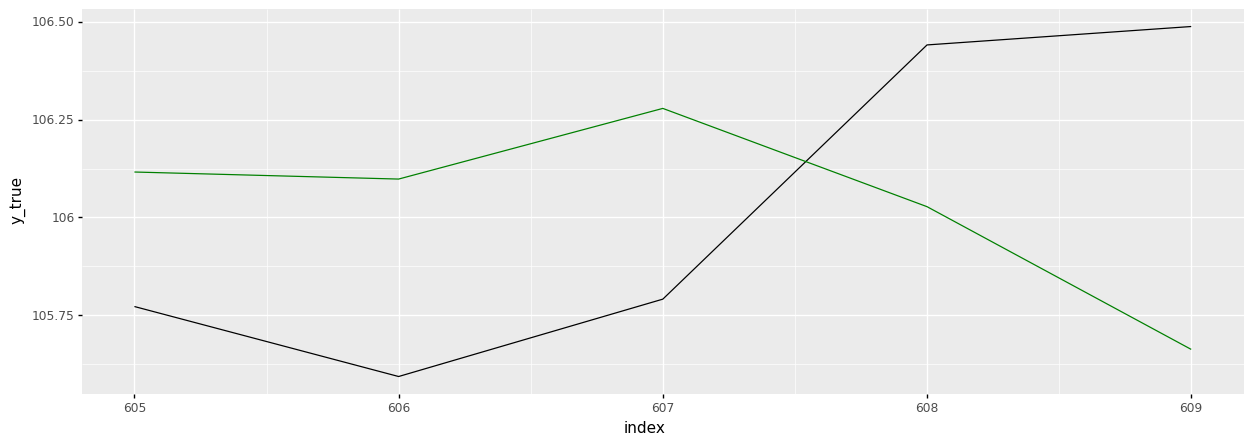

<ggplot: (-9223371884181494780)>

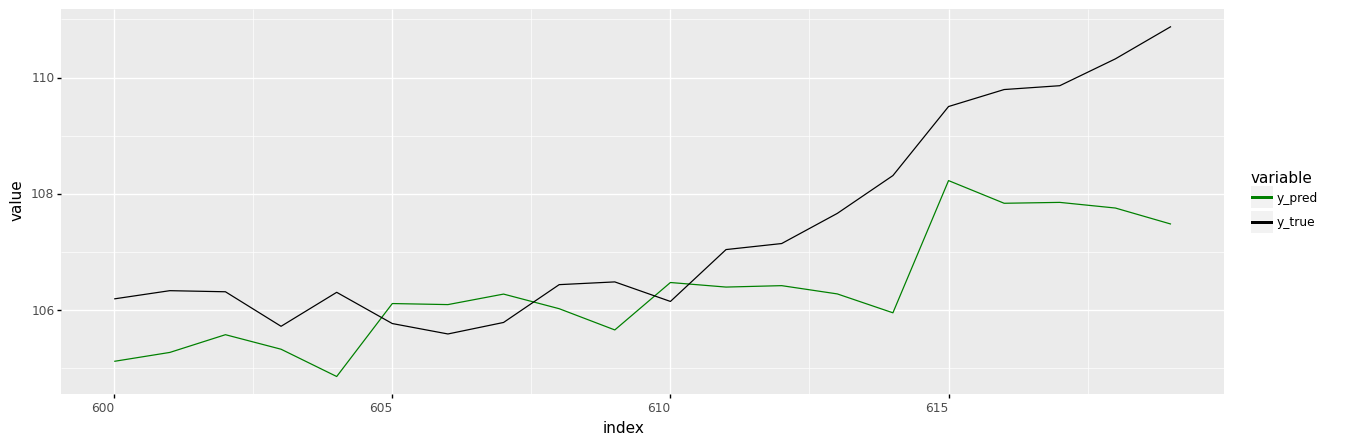

<ggplot: (-9223371884181452964)>

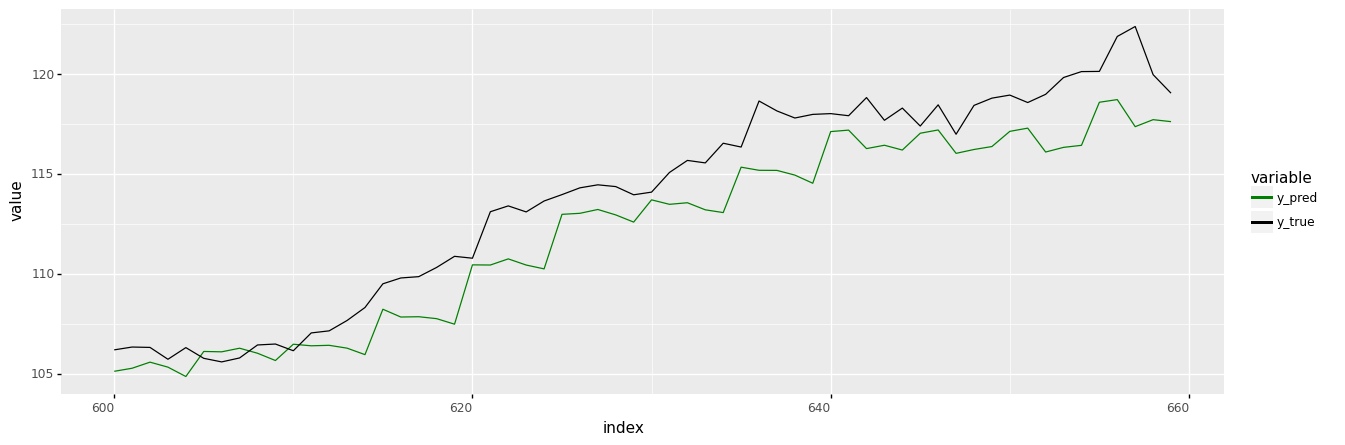

<ggplot: (-9223371884212276892)>

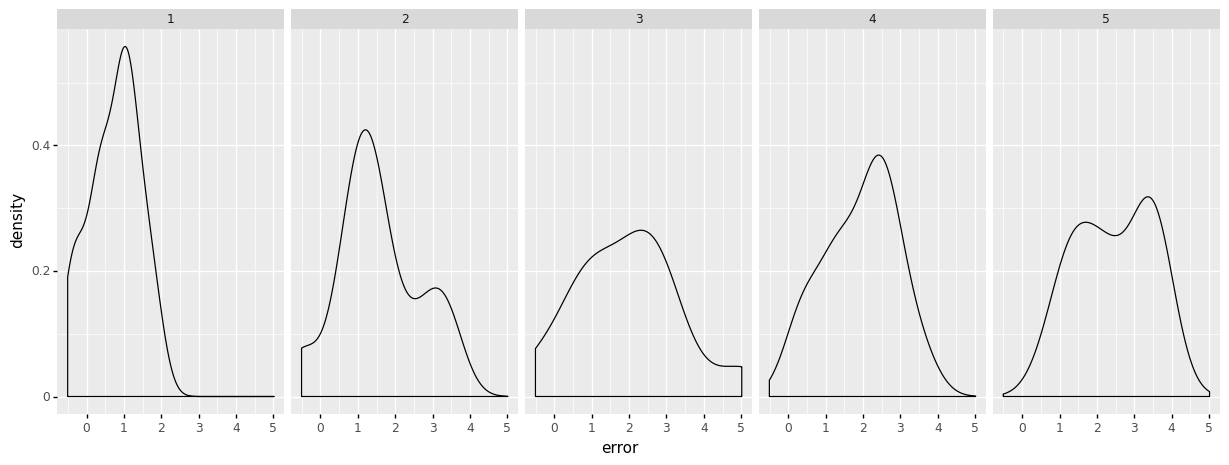

<ggplot: (-9223371884126496592)>

index    metric
0    mean_absolute_error_  1.781659
1  median_absolute_error_  1.436104
2     mean_squared_error_  4.353670

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  20.87712
1  p-value for Lagrange multiplier test   0.03467
2                 fstatistic for F test   2.49701
3                     pvalue for F test   0.01849

Null hypothesis: residuals are not autocorrelated
Statistic values:
[12.68961 20.80936 29.09882 34.36582 44.40939 44.4275  45.06941 45.34161
 47.16511 47.60908 50.60565 52.84355 53.51383 53.64136 58.20274 58.39365
 58.39409 60.42021 61.02058 69.1679  69.56729 69.9402  69.99787 70.29682
 70.44187 73.26744 78.84233 81.39873]
p-values:
[3.7e-04 3.0e-05 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00]


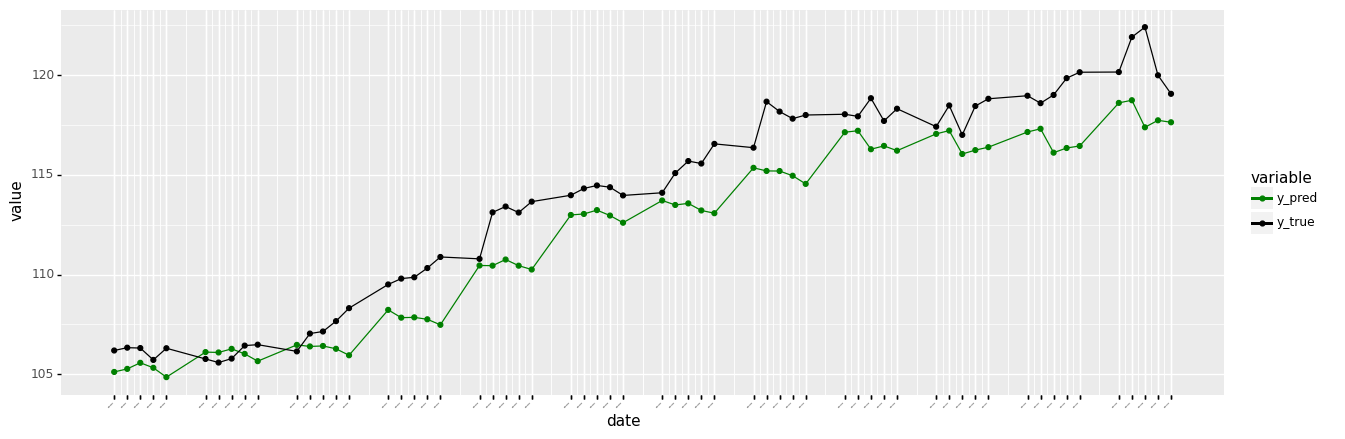

<ggplot: (-9223371883839736376)>

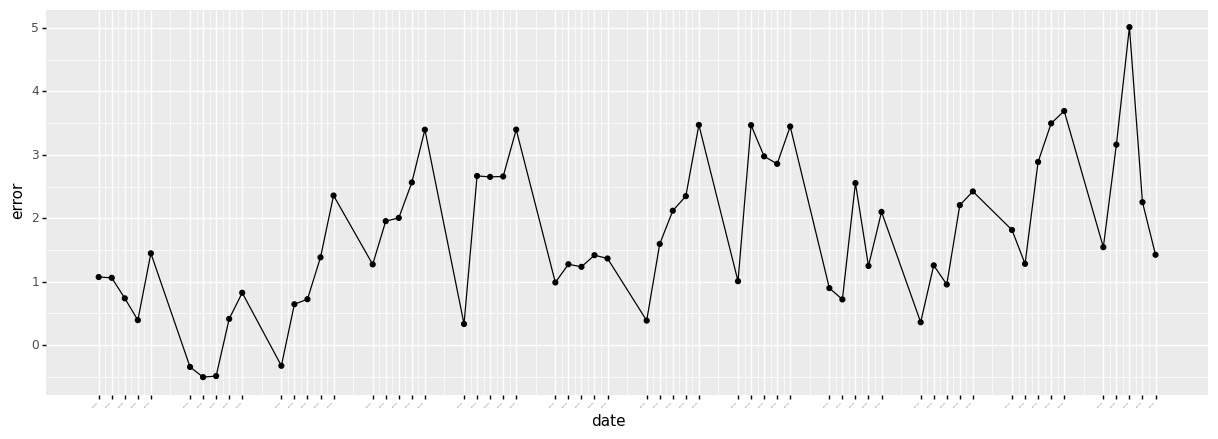

<ggplot: (-9223371883837485060)>

0
mean_error_true                0.015444
mean_error_pred                0.015771
mean_error_true_weighted_true  0.015653
mean_error_pred_weighted_pred  0.015894
median_error_true              0.012855
median_error_pred              0.013022
std_error                      0.009100
mean_error_squared             0.015894

In [5]:
# PARAMETERS  (parametry rozne of defaultowych ustawien)



input_len_f  = 10
features_n_f = 1
output_len_f = pred_len




# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)

train_len_min  = 600           # 
test_len_min   = input_len_f + pred_len * pred_n
train_test_gap = -input_len_f + 1 # test zachodzi o jeden zbior back na train-a

train_back_len_min = input_len_f 
test_back_len_min  = input_len_f 

train_pred_len = output_len_f
test_pred_len  = output_len_f



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = train_test_gap # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = train_pred_len     # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = test_pred_len      # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )



# MODEL
# 'lstm_vanilia'
model = keras.Sequential()
model.add(keras.layers.LSTM(100, activation='relu', input_shape = ( input_len_f, features_n_f ) ))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(output_len_f))
model.compile(loss='mse', optimizer='adam')


res = NN_n1_n1( ts = ts
  , var_y = [ts_var_1] #scalar no list !!!
  , var_x = [ts_var_1]
  , TS_idx = TS_idx
  , epochs = 1000
  , batch_size = 200
  , model_type = 'lstm_vanilia'
  , model = model
  , model_name = 'LSTM_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))



# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')

# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]


### LSTM encoder decoder

[[[24.368587]
  [50.51245 ]
  [50.51245 ]
  [50.51245 ]
  [50.51245 ]]

 [[16.902758]
  [51.68924 ]
  [51.68924 ]
  [51.68924 ]
  [51.68924 ]]

 [[18.56858 ]
  [49.160507]
  [49.160507]
  [49.160507]
  [49.160507]]

 [[23.568344]
  [47.626335]
  [47.626335]
  [47.626335]
  [47.626335]]]
[[[21.005062]
  [49.911007]
  [57.123314]
  [57.123314]
  [57.123314]]

 [[16.316292]
  [51.694168]
  [51.694168]
  [51.694168]
  [51.694168]]

 [[20.621283]
  [49.05138 ]
  [49.05138 ]
  [49.05138 ]
  [49.05138 ]]

 [[15.434466]
  [50.020653]
  [50.020653]
  [50.020653]
  [50.020653]]]
[[[19.634554]
  [49.615433]
  [49.615433]
  [49.615433]
  [49.615433]]

 [[12.09473 ]
  [52.071564]
  [52.071564]
  [52.071564]
  [52.071564]]

 [[26.599644]
  [46.142647]
  [50.649406]
  [50.649406]
  [50.649406]]

 [[17.81046 ]
  [51.088863]
  [52.70729 ]
  [52.70729 ]
  [52.70729 ]]]


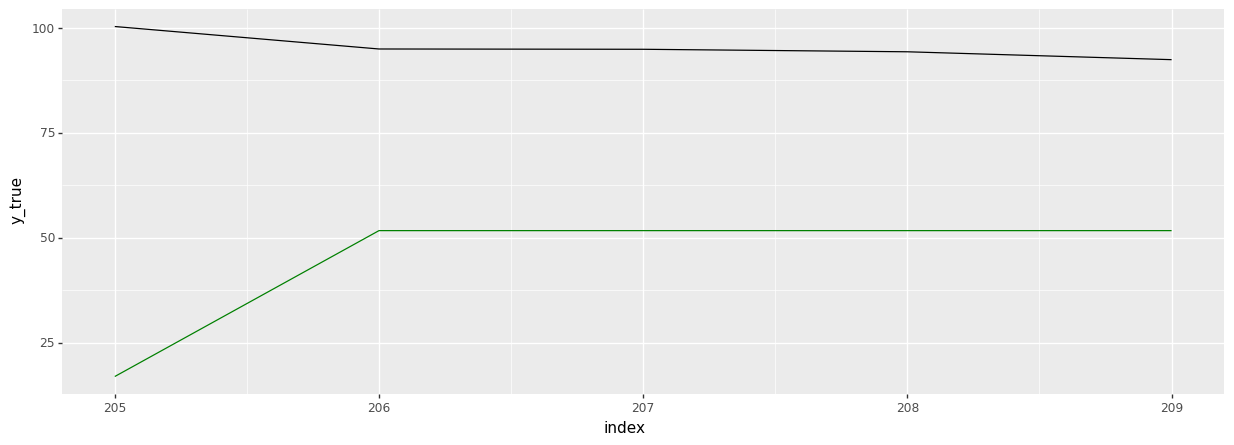

<ggplot: (-9223371914956651495)>

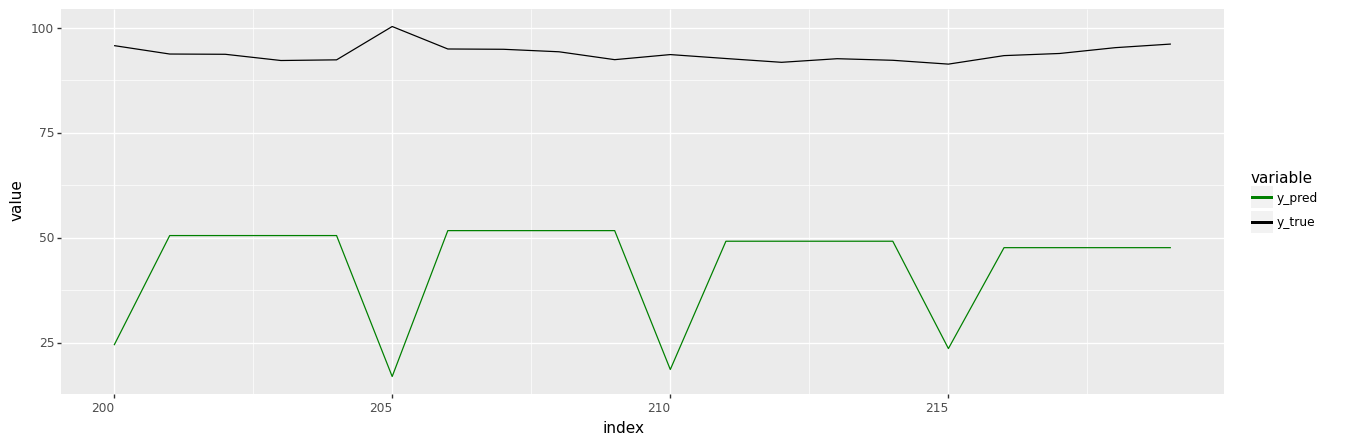

<ggplot: (-9223371914956641315)>

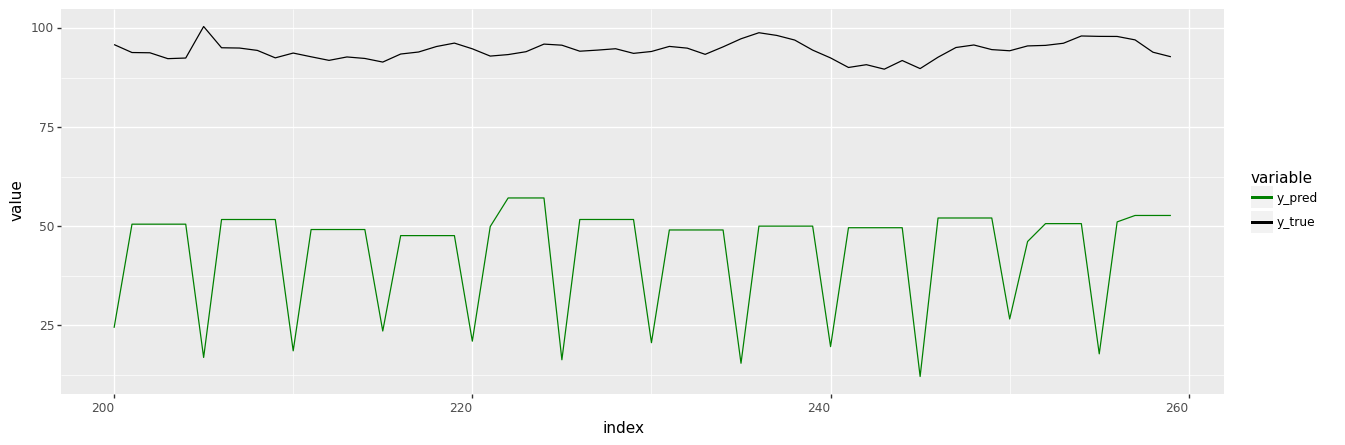

<ggplot: (-9223371914956608880)>

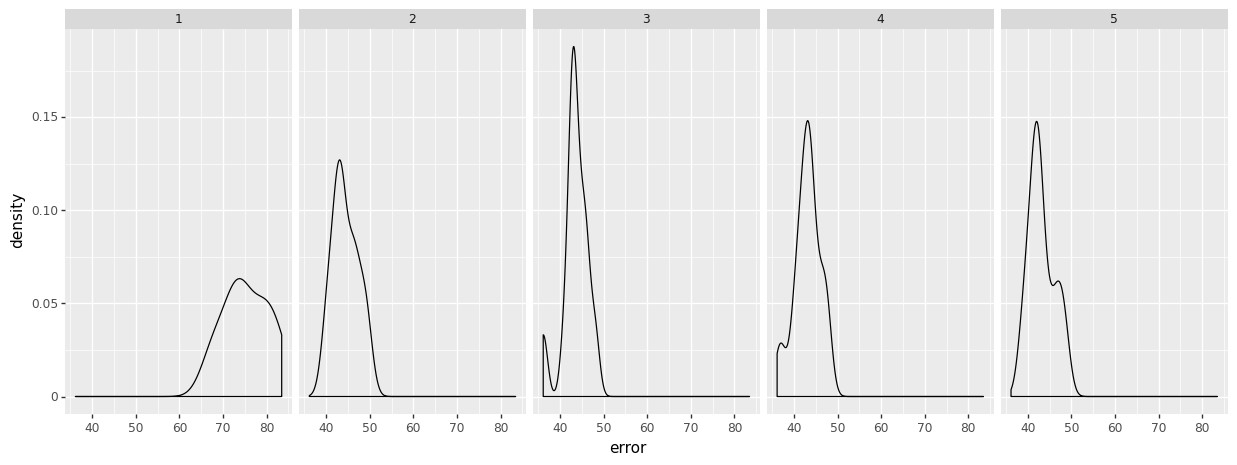

<ggplot: (-9223371914956641315)>

index       metric
0    mean_absolute_error_    49.899414
1  median_absolute_error_    43.954224
2     mean_squared_error_  2663.595202

Null hypothesis: no conditional heterescedastity


stats     value
0    Lagrange multiplier test statistic  43.98067
1  p-value for Lagrange multiplier test   0.00001
2                 fstatistic for F test  29.47304
3                     pvalue for F test   0.00000

Null hypothesis: residuals are not autocorrelated
Statistic values:
[  1.85839   5.26496   9.43335  13.12693  59.76484  61.96318  65.21295
  68.83092  71.94684 115.02608 117.04997 120.35204 123.79532 126.45395
 165.40454 166.94317 169.30489 171.8853  173.62551 214.10957 215.59132
 218.45405 222.12057 225.02335 255.60732 256.76161 258.51928 261.10284]
p-values:
[0.17281 0.0719  0.02405 0.01067 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.     ]


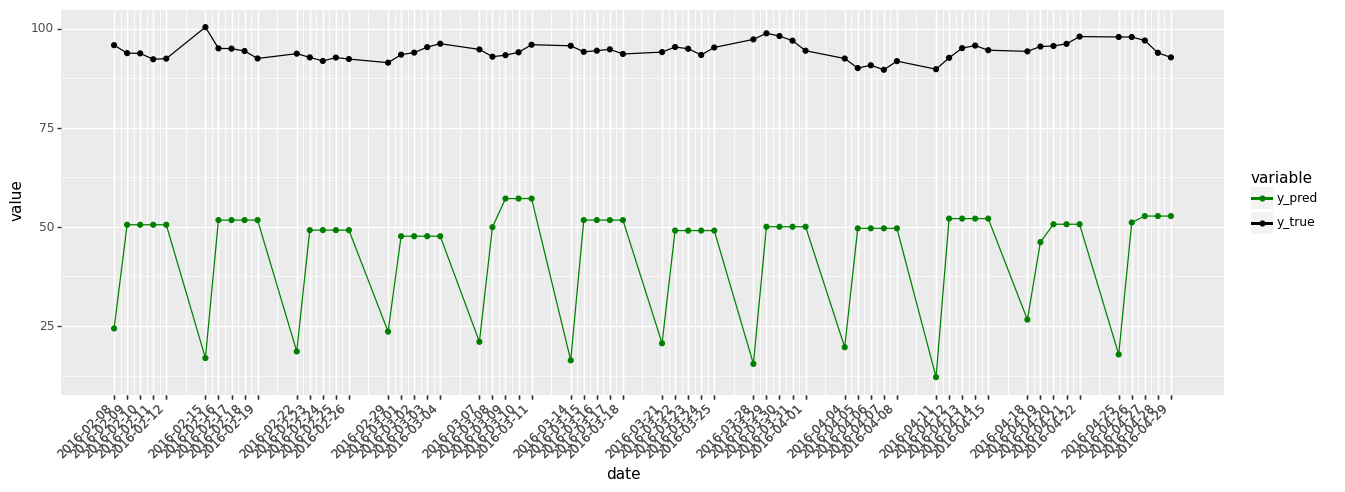

<ggplot: (-9223371914956124107)>

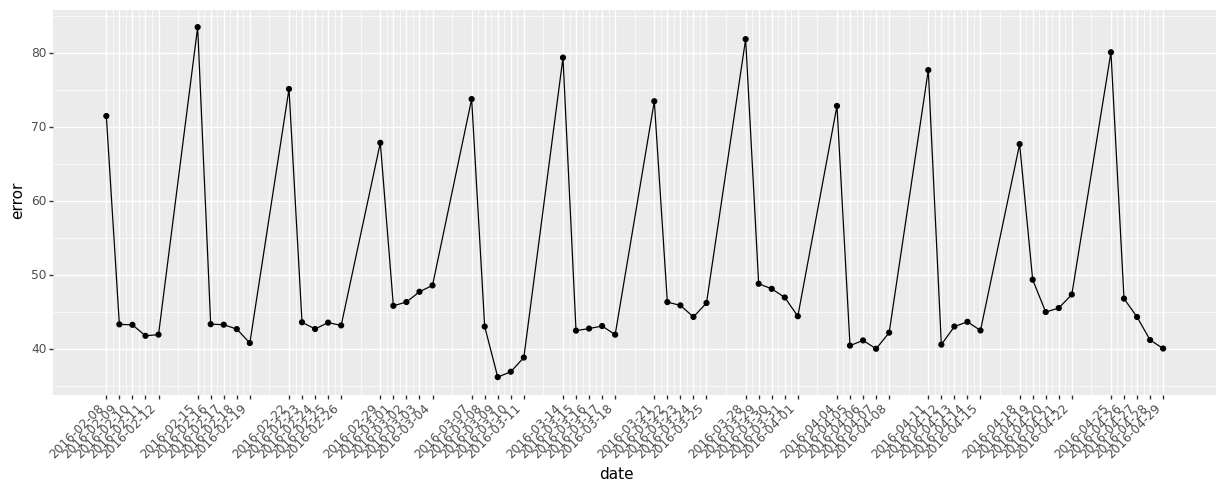

<ggplot: (121891724110)>

0
mean_error_true                0.528350
mean_error_pred                1.509267
mean_error_true_weighted_true  0.528853
mean_error_pred_weighted_pred  1.122481
median_error_true              0.469704
median_error_pred              0.885739
std_error                      0.136568
mean_error_squared             1.122481

In [41]:
# PARAMETERS  (parametry rozne of defaultowych ustawien)


input_len_f  = 10
features_n_f = 1
output_len_f = pred_len




# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)

train_len_min  = 200           # 
test_len_min   = input_len_f + pred_len * pred_n
train_test_gap = -input_len_f + 1 # test zachodzi o jeden zbior back na train-a

train_back_len_min = input_len_f 
test_back_len_min  = input_len_f 

train_pred_len = output_len_f
test_pred_len  = output_len_f



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = train_test_gap # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = train_pred_len     # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = test_pred_len      # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )


# MODEL
# 'ltsm_d_e'
model = keras.Sequential()
model.add(keras.layers.LSTM(20, activation='relu', input_shape=( input_len_f, features_n_f  ) ))
model.add(RepeatVector(output_len_f))
model.add(keras.layers.LSTM(5, activation='relu', return_sequences=True))
model.add(TimeDistributed(keras.layers.Dense(10, activation='relu')))
model.add(TimeDistributed(keras.layers.Dense(1)))
model.compile(loss='mse', optimizer='adam')



res = NN_n1_n1( ts = ts
  , var_y = [ts_var_1] #scalar no list !!!
  , var_x = [ts_var_1]
  , TS_idx = TS_idx
  , epochs = 500
  , batch_size = 20
  , model_type = 'ltsm_d_e'
  , model = model
  , model_name = 'LSTM_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))



# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)

# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')

# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]


### CNN LSTM encoder decoder

In [5]:
# PARAMETERS  (parametry rozne of defaultowych ustawien)


input_len_f  = 10
features_n_f = 1
output_len_f = pred_len




# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)

train_len_min  = 200           # 
test_len_min   = input_len_f + pred_len * pred_n
train_test_gap = -input_len_f + 1 # test zachodzi o jeden zbior back na train-a

train_back_len_min = input_len_f 
test_back_len_min  = input_len_f 

train_pred_len = output_len_f
test_pred_len  = output_len_f



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = train_test_gap # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = train_pred_len     # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = test_pred_len      # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )

# MODEL
# https://stackoverflow.com/questions/53013555/valueerror-negative-dimension-size-caused-by-subtracting-3-from-1-for-conv1d-1

# 'cnn_lstm_d_e'

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape= ( input_len_f, features_n_f  ) ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(RepeatVector(output_len_f))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')



# lstm attencton
# https://www.kaggle.com/residentmario/seq-to-seq-rnn-models-attention-teacher-forcing



# del res

res = NN_n1_n1( ts = ts
  , var_y = [ts_var_1] #scalar no list !!!
  , var_x = [ts_var_1]
  , TS_idx = TS_idx
  , epochs = 200
  , batch_size = 20
  , model_type = 'cnn_lstm_d_e'
  , model = model
  , model_name = 'LSTM_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))



# VISUALISATION


# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')

# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]





NameError: name 'pred_len' is not defined

## Neural networks nn_n1

## Varmax

C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.


C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\ts

1
intercept.var_1         1.023359e+00
intercept.var_2         1.552711e+06
L1.var_1.var_1          8.831455e-01
L1.var_2.var_1         -8.293723e-07
L2.var_1.var_1          2.145703e-02
L2.var_2.var_1         -1.457145e-07
L3.var_1.var_1         -9.080593e-02
L3.var_2.var_1          5.106099e-08
L4.var_1.var_1          1.485469e-01
L4.var_2.var_1          1.296841e-06
L1.var_1.var_2          1.559011e+04
L1.var_2.var_2          5.081167e-01
L2.var_1.var_2         -3.071257e+03
L2.var_2.var_2         -1.157186e-01
L3.var_1.var_2         -3.760092e+04
L3.var_2.var_2          5.471207e-03
L4.var_1.var_2          1.537455e+04
L4.var_2.var_2         -1.280787e-01
L1.e(var_1).var_1       1.224947e-01
L1.e(var_2).var_1       6.974602e-08
L2.e(var_1).var_1      -4.777052e-02
L2.e(var_2).var_1      -3.838706e-07
L3.e(var_1).var_1       7.925532e-03
L3.e(var_2).var_1      -1.247433e-07
L1.e(var_1).var_2      -5.108147e+03
L1.e(var_2).var_2      -5.170237e-02
L2.e(var_1).var_2       4.265258e+03

C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\ts

2
intercept.var_1         5.016002e-01
intercept.var_2         1.451158e+06
L1.var_1.var_1          1.015438e+00
L1.var_2.var_1         -3.573157e-07
L2.var_1.var_1         -2.298761e-01
L2.var_2.var_1         -6.860197e-07
L3.var_1.var_1          8.928668e-02
L3.var_2.var_1          2.367479e-07
L4.var_1.var_1          9.947127e-02
L4.var_2.var_1          1.277663e-06
L1.var_1.var_2          9.243268e+03
L1.var_2.var_2          4.434210e-01
L2.var_1.var_2          9.700410e+03
L2.var_2.var_2         -5.432628e-02
L3.var_1.var_2         -5.013797e+04
L3.var_2.var_2         -1.515404e-02
L4.var_1.var_2          2.469952e+04
L4.var_2.var_2         -9.898580e-02
L1.e(var_1).var_1       2.694200e-02
L1.e(var_2).var_1      -1.813619e-08
L2.e(var_1).var_1       5.743257e-03
L2.e(var_2).var_1      -1.337246e-07
L3.e(var_1).var_1      -2.522735e-02
L3.e(var_2).var_1      -7.192820e-08
L1.e(var_1).var_2       3.565482e+03
L1.e(var_2).var_2      -6.872715e-03
L2.e(var_1).var_2       7.479025e+03

C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\ts

3
intercept.var_1         1.159531e+00
intercept.var_2         1.609030e+06
L1.var_1.var_1          1.093317e+00
L1.var_2.var_1         -3.542658e-07
L2.var_1.var_1         -4.238267e-01
L2.var_2.var_1         -6.235291e-07
L3.var_1.var_1          2.731471e-01
L3.var_2.var_1          6.821209e-07
L4.var_1.var_1          3.175743e-02
L4.var_2.var_1          1.093870e-06
L1.var_1.var_2          5.338457e+03
L1.var_2.var_2          4.363097e-01
L2.var_1.var_2          1.547367e+03
L2.var_2.var_2         -9.470889e-02
L3.var_1.var_2         -9.120339e+03
L3.var_2.var_2          3.664132e-02
L4.var_1.var_2         -4.815444e+03
L4.var_2.var_2         -1.184819e-01
L1.e(var_1).var_1       2.694531e-02
L1.e(var_2).var_1      -6.417000e-08
L2.e(var_1).var_1       4.891682e-03
L2.e(var_2).var_1       6.142972e-08
L3.e(var_1).var_1      -8.843509e-04
L3.e(var_2).var_1      -9.985697e-08
L1.e(var_1).var_2       2.447631e+03
L1.e(var_2).var_2      -1.531640e-03
L2.e(var_1).var_2      -1.090818e+03

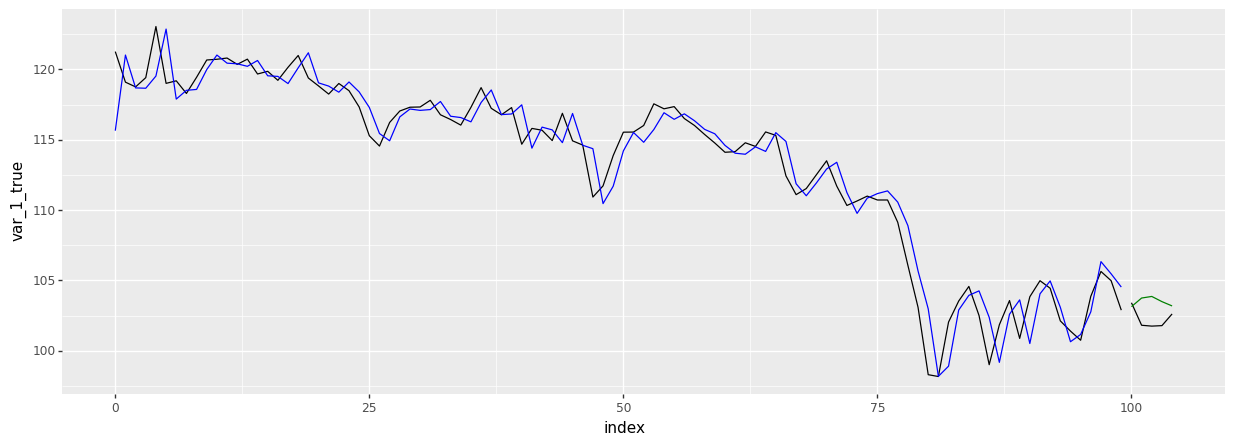

<ggplot: (121874615367)>

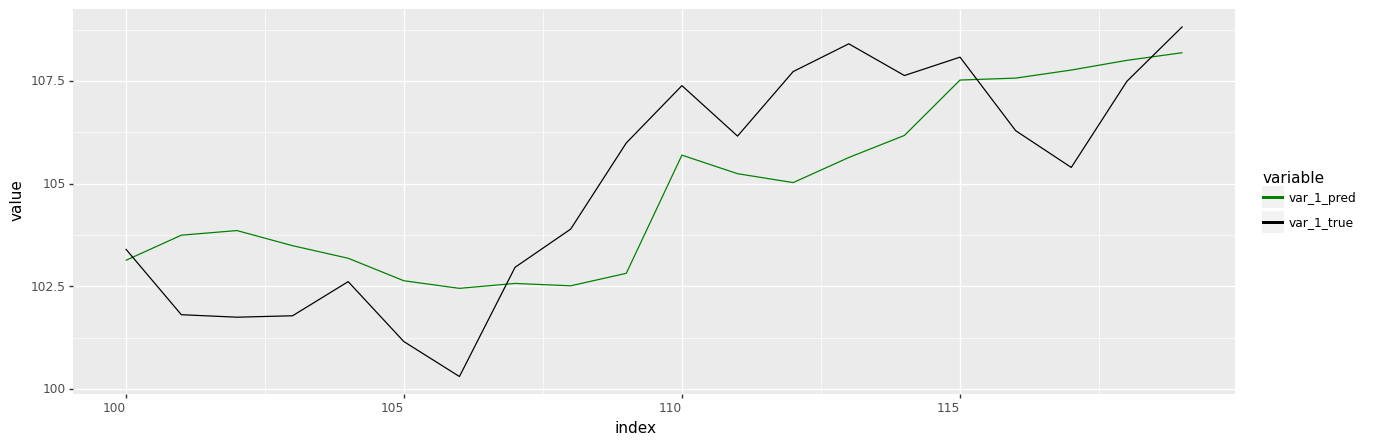

<ggplot: (121898237725)>

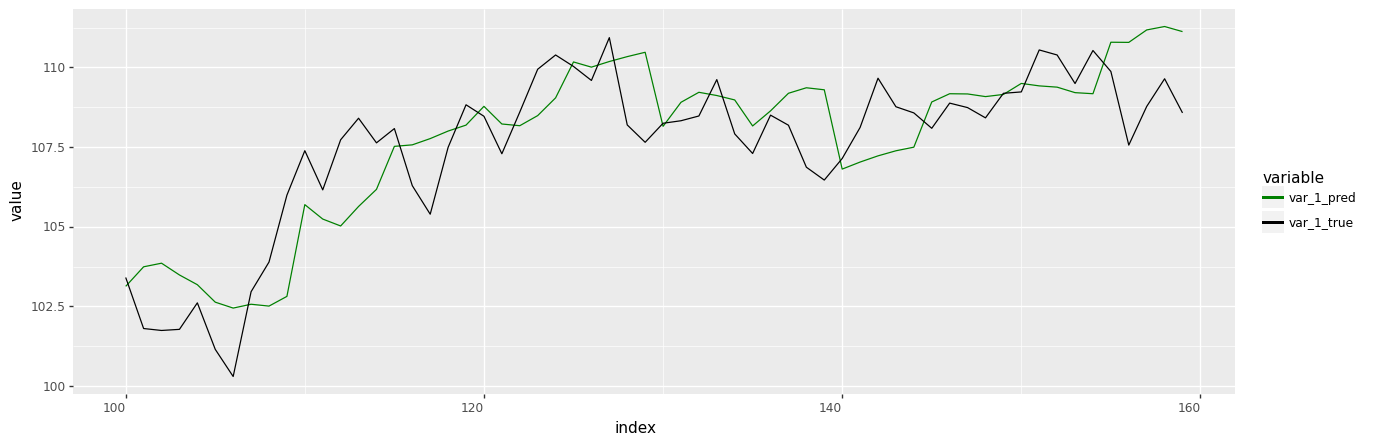

<ggplot: (-9223371914953065065)>

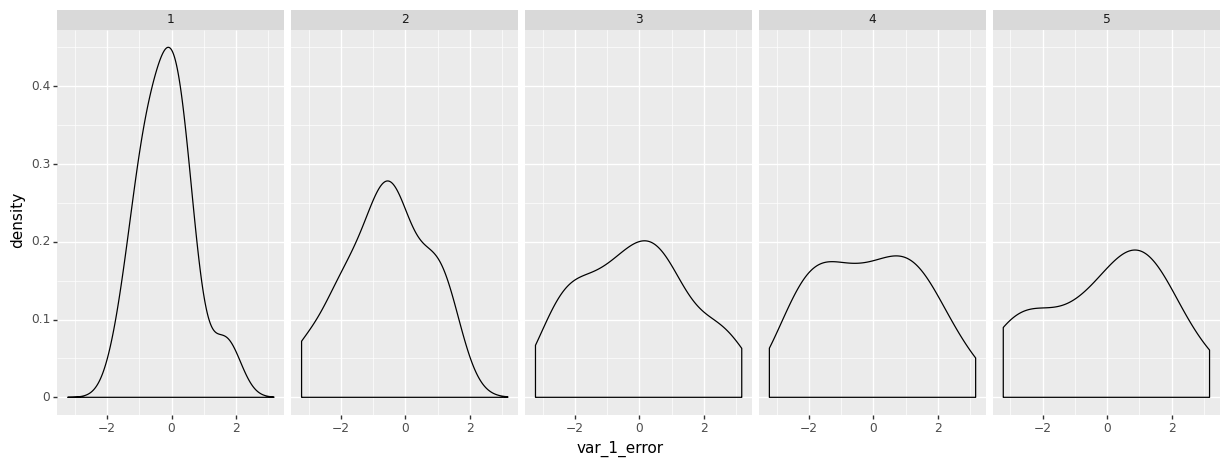

<ggplot: (-9223371914956116031)>

index    metric
0    mean_absolute_error_  1.241168
1  median_absolute_error_  1.037178
2     mean_squared_error_  2.305899

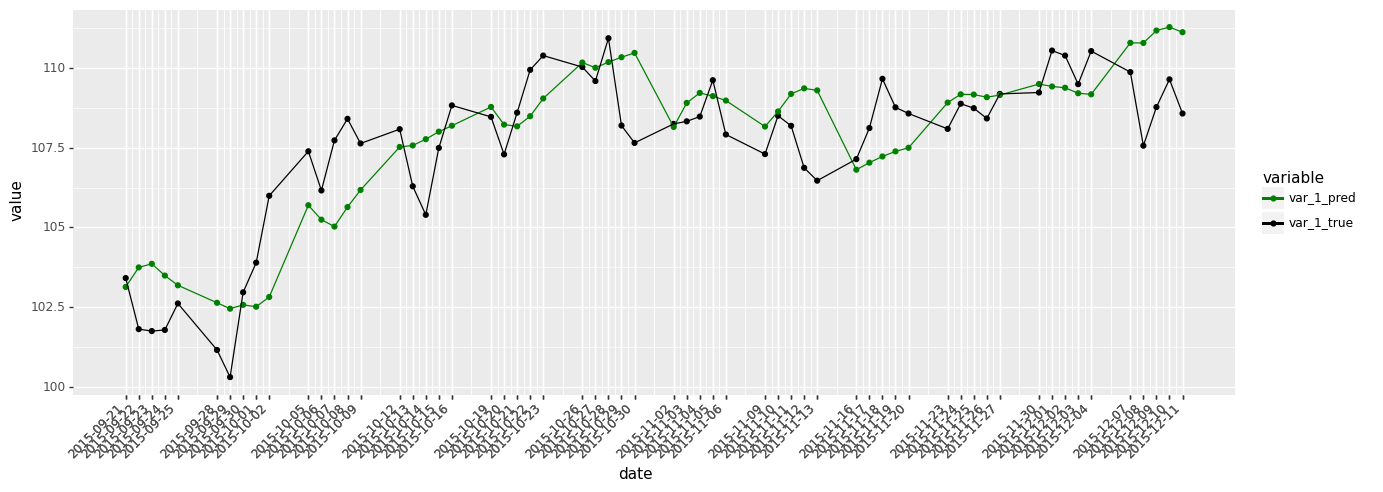

<ggplot: (-9223371914952669517)>

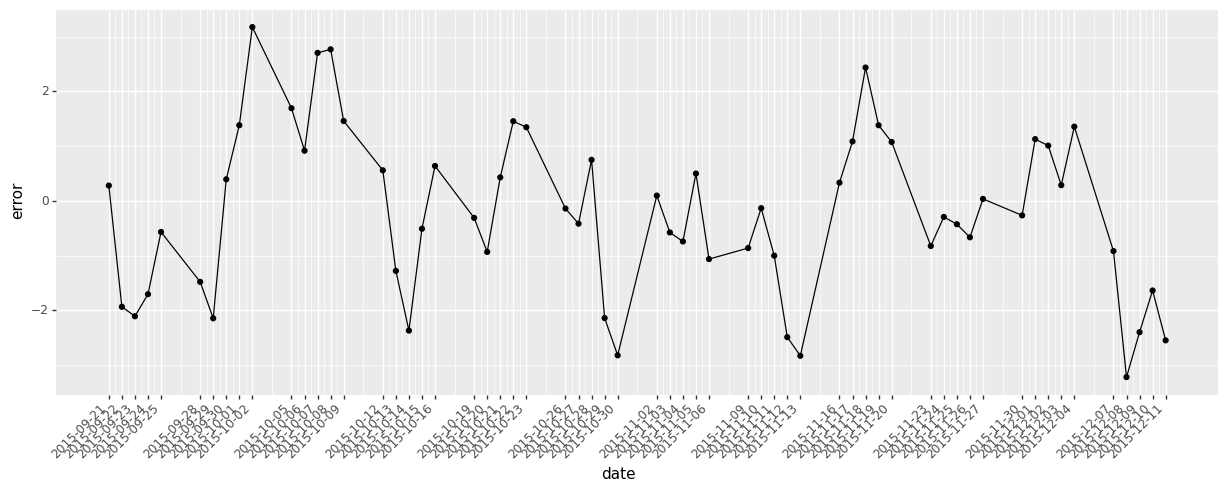

<ggplot: (121902514545)>

0
mean_error_true                0.011597
mean_error_pred                0.011551
mean_error_true_weighted_true  0.011545
mean_error_pred_weighted_pred  0.011522
median_error_true              0.009568
median_error_pred              0.009500
std_error                      0.008220
mean_error_squared             0.011522

In [44]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = pred_len           # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )



# MODEL
res = VARMAX( ts = ts
     ,var_y = [ts_var_1, ts_var_2]
     ,var_x = [ts_var_3]
     ,order = (4,3)
     ,trend = 'c'
     ,enforce_stationarity = False
     ,enforce_invertibility = False
     ,TS_idx = TS_idx
     ,fit_method = 'nm'
     ,max_iterations = 300
     ,model_name = 'VARMAX_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))


# VISUALISATION

# non aggregated results
# zmienna GM
var_true  = ts_var_1+'_true'
var_pred  = ts_var_1+'_pred'
var_error = ts_var_1+'_error'
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, var_true = var_true, var_pred = var_pred, plot_index = True, fig_w=fig_w, fig_h=fig_h)
plot_ts_fold_pred(data_results = res, fold = 1, var_true = var_true, var_pred = var_pred, plot_index = True, fig_w=fig_w, fig_h=fig_h)
plot_ts_pred(data_results = res, var_true=var_true, var_pred=var_pred, plot_index = True, fig_w=fig_w, fig_h=fig_h)
plot_density_error_pred_n(data_results = res, error = var_error, fold = None, fig_w=fig_w, fig_h=fig_h)
plot_metrics_pred(data_results = res, var_true = var_true, var_pred = var_pred)


# not aggregated residuals diagnostics
# h('Arch test')
# test_HET_ARCH(res)
# h('Ljung box autocorrelation test')
# test_LJUNG(res)
# h('BDS test')

# aggreagated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], var_y_true = var_true, var_y_pred = var_pred, start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
plot_pred_aggreg(data = res_clean[1], var_true=var_true, var_pred=var_pred, fig_w=fig_w, fig_h=fig_h)
plot_pred_aggreg_error(data = res_clean[1], var_error='error' , fig_w=fig_w, fig_h=fig_h)
res_clean[2]

## Vecm

1
2
3


C:\Users\memy\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


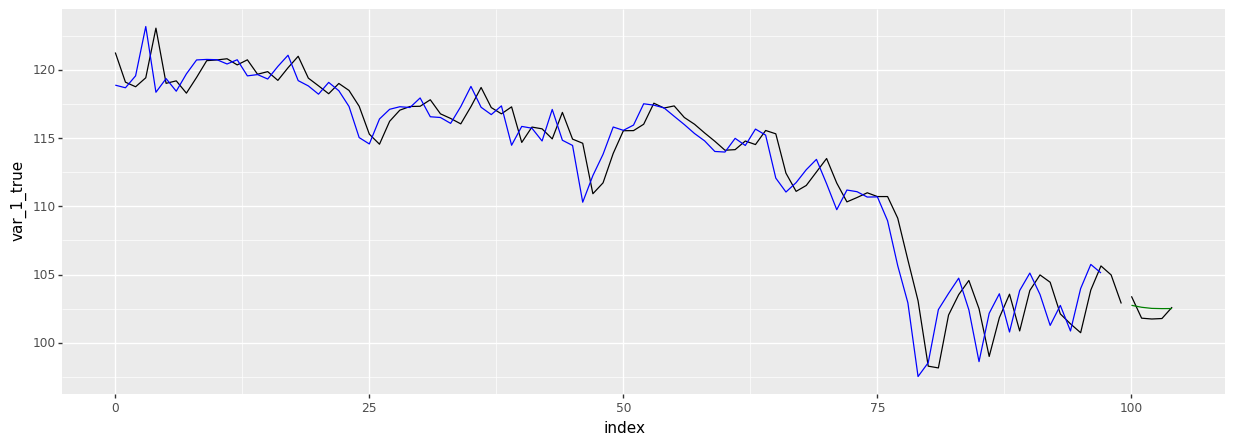

<ggplot: (121874647507)>

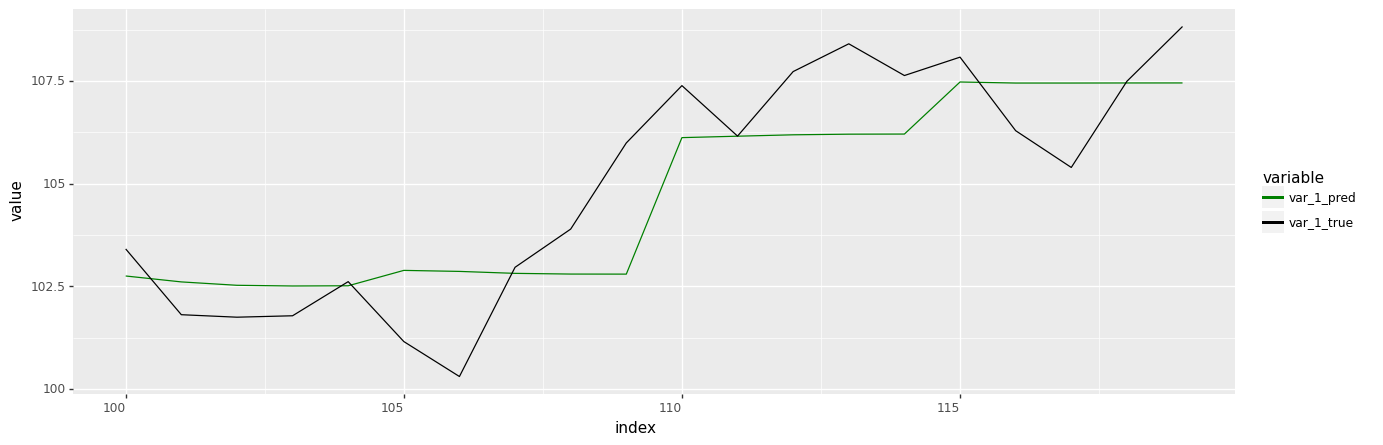

<ggplot: (122001278868)>

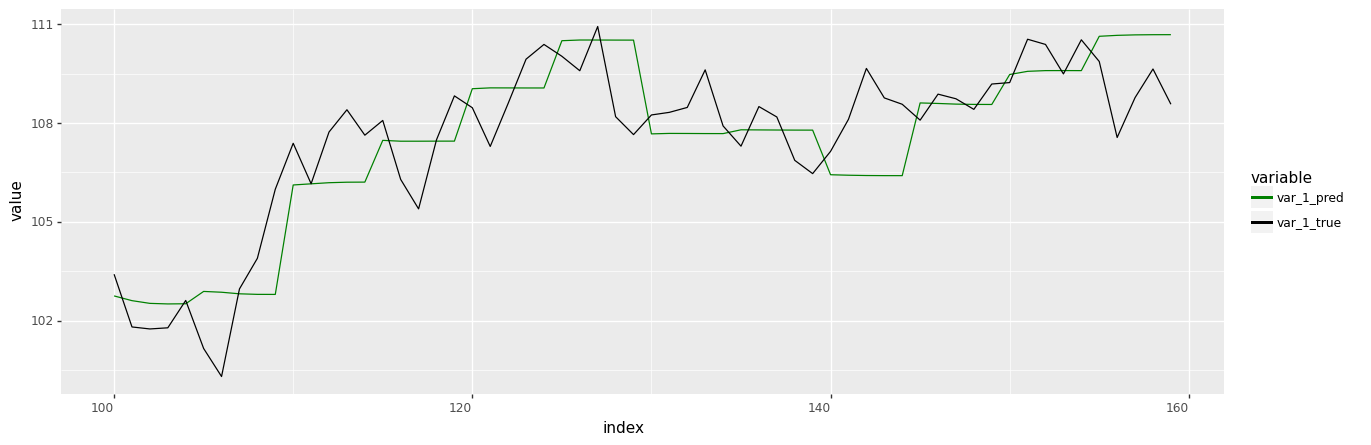

<ggplot: (122001284942)>

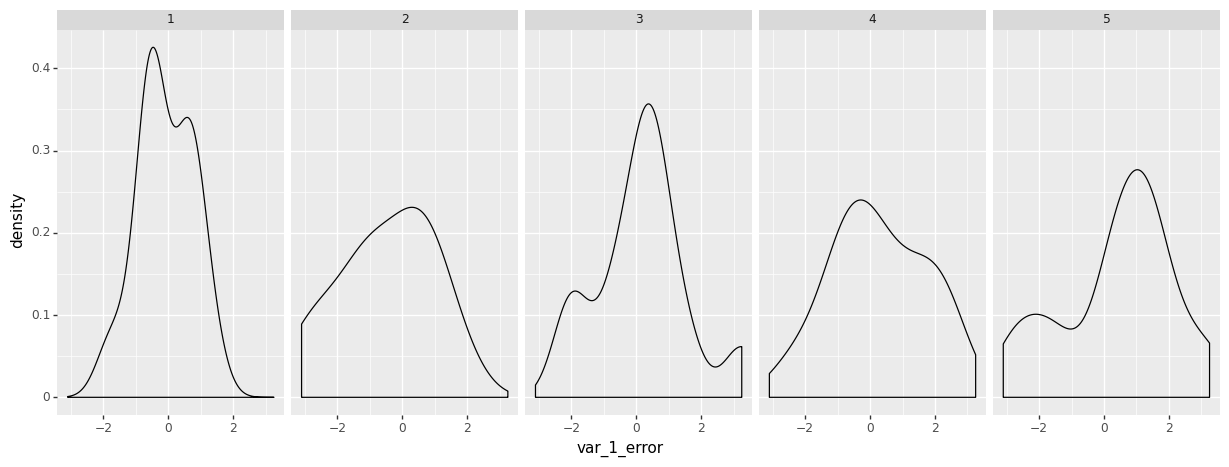

<ggplot: (122001652365)>

index    metric
0    mean_absolute_error_  1.123857
1  median_absolute_error_  0.836689
2     mean_squared_error_  1.977644

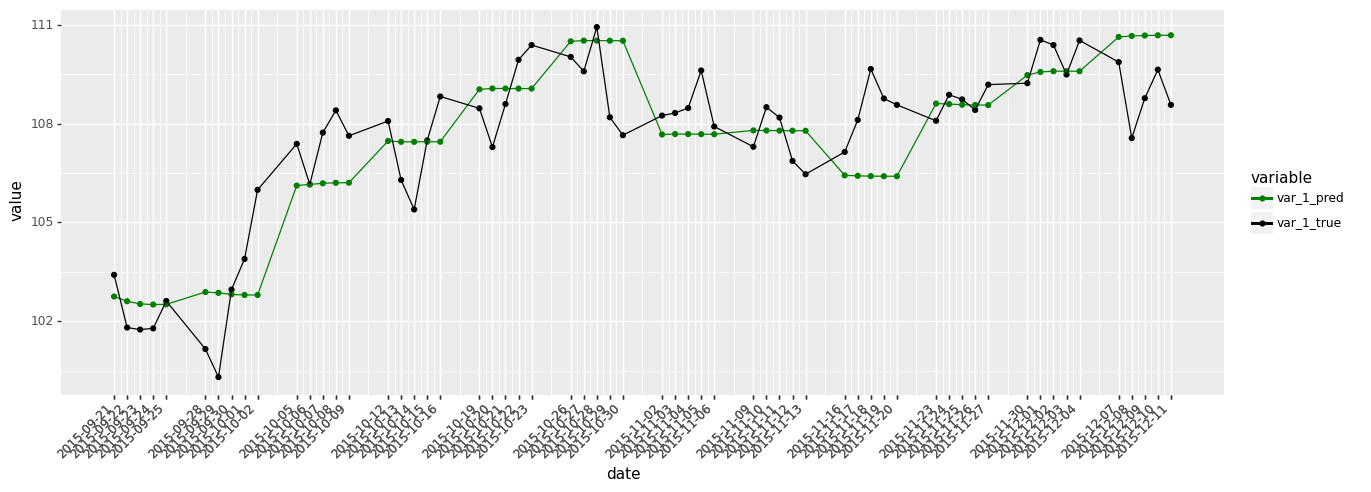

<ggplot: (-9223371914853482145)>

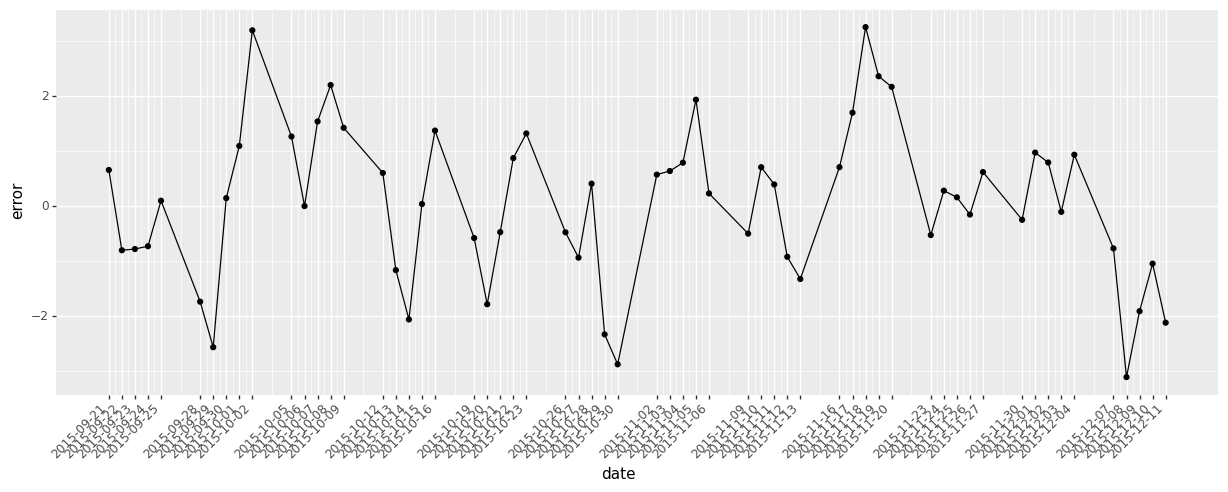

<ggplot: (-9223371914980162977)>

0
mean_error_true                0.010468
mean_error_pred                0.010473
mean_error_true_weighted_true  0.010454
mean_error_pred_weighted_pred  0.010460
median_error_true              0.007901
median_error_pred              0.007902
std_error                      0.007898
mean_error_squared             0.010460

In [22]:
# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)
train_len_min  = 100           # 
test_len_min   = train_len_min + pred_len * pred_n

train_back_len_min = train_len_min
test_back_len_min  = train_len_min



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = pred_len           # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = pred_len           # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )


# MODEL
res = VECM( ts = ts
         ,var_y = [ts_var_1, ts_var_2]
         ,var_x = None
         ,k_ar_diff = 1
         ,coint_rank = 1
         ,deterministic = 'ci'
         ,fit_method = 'ml'
         ,TS_idx = TS_idx
         ,model_name = 'VECM_')


# VISUALISTAION

# not aggregated results
# zmienna GM
var_true  = ts_var_1+'_true'
var_pred  = ts_var_1+'_pred'
var_error = ts_var_1+'_error'
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, var_true = var_true, var_pred = var_pred, plot_index = True, fig_w=fig_w, fig_h=fig_h)
plot_ts_fold_pred(data_results = res, fold = 1, var_true = var_true, var_pred = var_pred, plot_index = True, fig_w=fig_w, fig_h=fig_h)
plot_ts_pred(data_results = res, var_true=var_true, var_pred=var_pred, plot_index = True, fig_w=fig_w, fig_h=fig_h)
plot_density_error_pred_n(data_results = res, error = var_error, fold = None, fig_w=fig_w, fig_h=fig_h)
plot_metrics_pred(data_results = res, var_true = var_true, var_pred = var_pred)

# not aggregated residuals diagnostics
# h('Arch test')
# test_HET_ARCH(res)
# h('Ljung box autocorrelation test')
# test_LJUNG(res)
# h('BDS test')

# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], var_y_true = var_true, var_y_pred = var_pred, start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
plot_pred_aggreg(data = res_clean[1], var_true=var_true, var_pred=var_pred, fig_w=fig_w, fig_h=fig_h)
plot_pred_aggreg_error(data = res_clean[1], var_error='error', fig_w=fig_w, fig_h=fig_h )
res_clean[2]


# Models stacking

## Averaging and aggregations

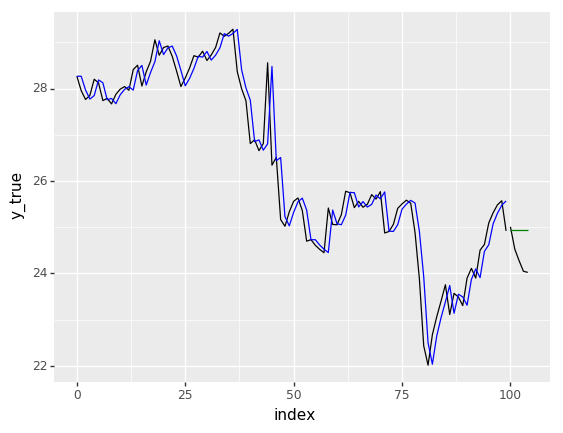

<ggplot: (-9223371875064655970)>

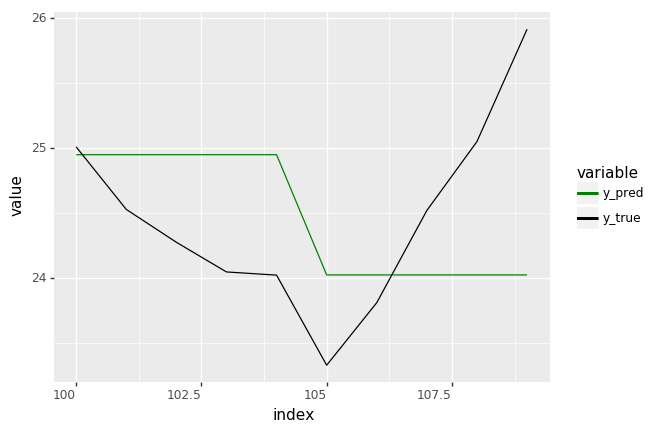

<ggplot: (-9223371875069117531)>

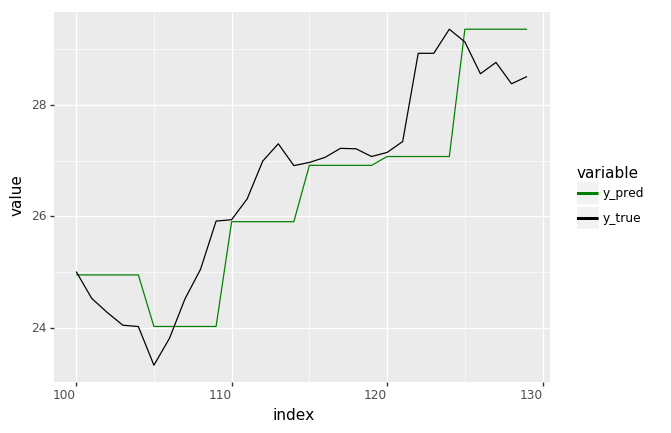

<ggplot: (161785940919)>

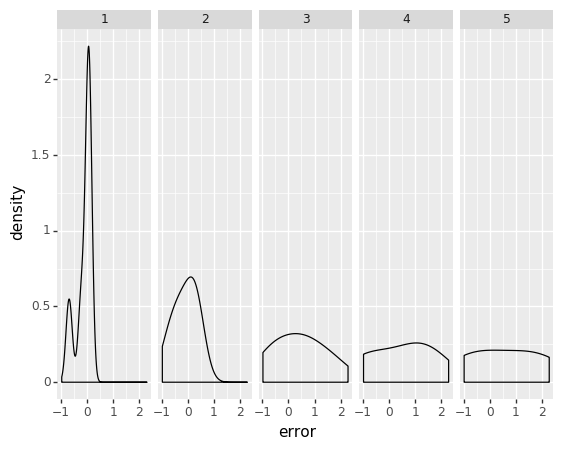

<ggplot: (161785943237)>

index    metric
0    mean_absolute_error_  0.733544
1  median_absolute_error_  0.635502
2     mean_squared_error_  0.906781

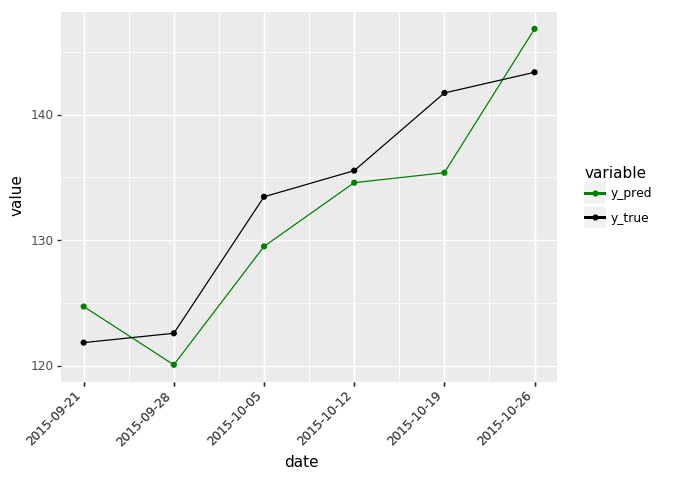

<ggplot: (-9223371875064014690)>

C:\Users\memy\Anaconda3\lib\site-packages\plotnine\layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


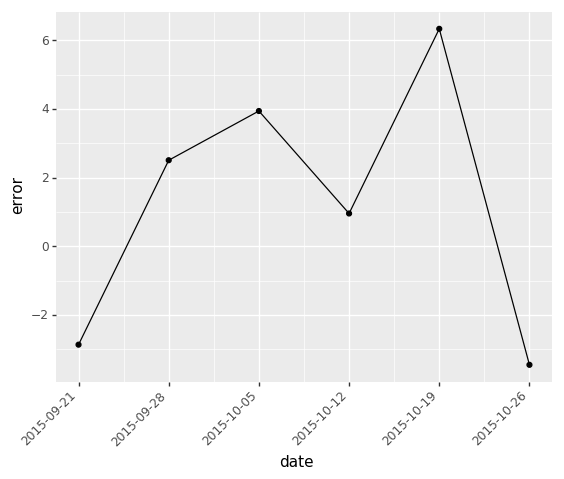

<ggplot: (-9223371875063873511)>

0
mean_error_true                0.024899
mean_error_pred                0.025292
mean_error_true_weighted_true  0.025128
mean_error_pred_weighted_pred  0.025363
median_error_true              0.023814
median_error_pred              0.023260
std_error                      0.011221
mean_error_squared             0.025363

In [137]:
t1 = copy.deepcopy(res)
t2 = copy.deepcopy(res)
t3 = copy.deepcopy(res)

res_new = CV_stacker(  models  = [t1, t2]
           , agg_fun = 'mean')

# VISUALISATION

h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res_new, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res_new, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res_new, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res_new, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res_new)

# agregating results
res_clean_new = results_cleaning_pred(results = res_new, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)

h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean_new[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean_new[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean_new[2]



## Defferent models for different times

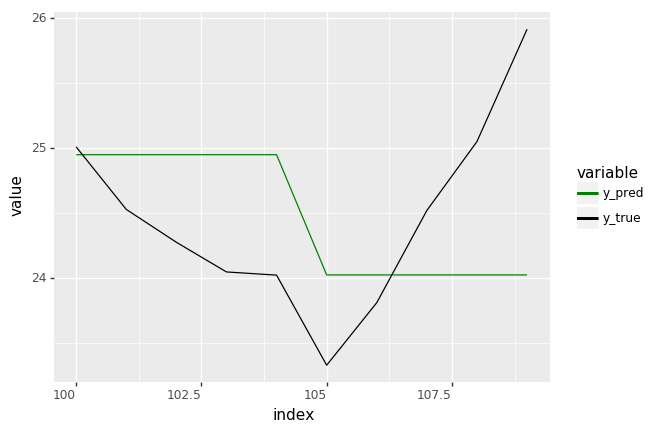

<ggplot: (161790975394)>

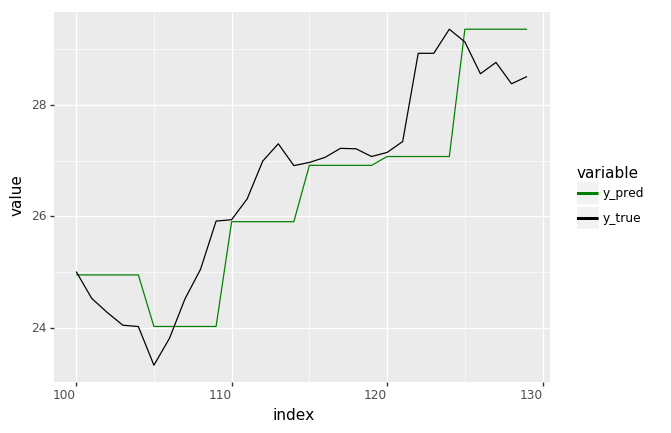

<ggplot: (-9223371875061631733)>

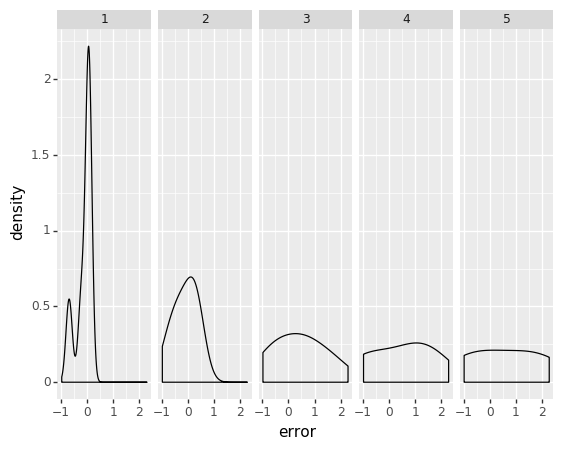

<ggplot: (161790979129)>

index    metric
0    mean_absolute_error_  0.733544
1  median_absolute_error_  0.635502
2     mean_squared_error_  0.906781

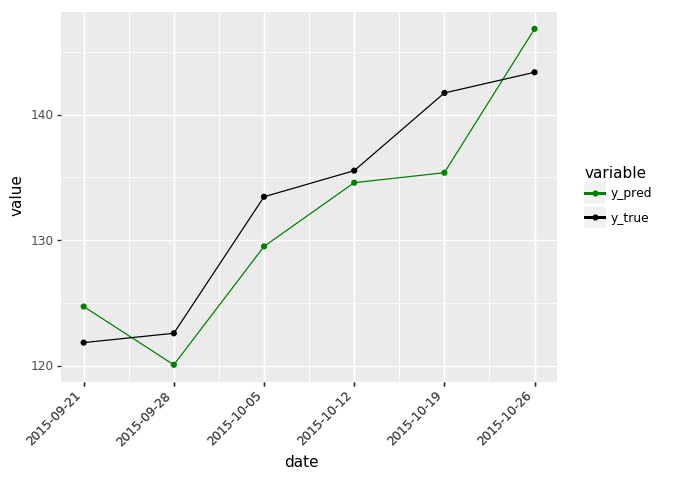

<ggplot: (161793174213)>

C:\Users\memy\Anaconda3\lib\site-packages\plotnine\layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


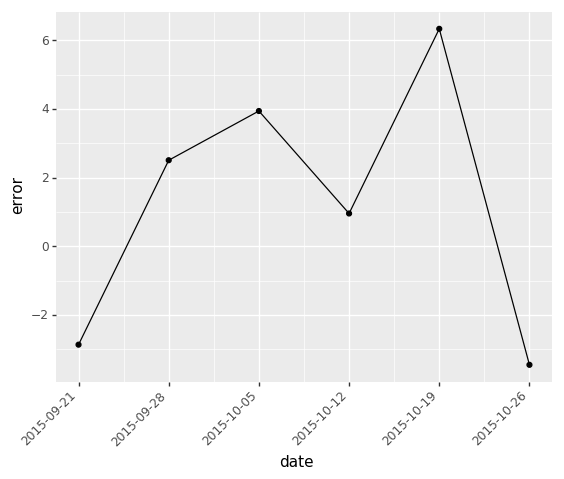

<ggplot: (161793149220)>

0
mean_error_true                0.024899
mean_error_pred                0.025292
mean_error_true_weighted_true  0.025128
mean_error_pred_weighted_pred  0.025363
median_error_true              0.023814
median_error_pred              0.023260
std_error                      0.011221
mean_error_squared             0.025363

In [140]:

res_monday    = res.loc[res['index_rel_shift'] == 1,]
res_thusday   = res.loc[res['index_rel_shift'] == 2,]
res_wednesday = res.loc[res['index_rel_shift'] == 3,]
res_thursday  = res.loc[res['index_rel_shift'] == 4,]
res_friday    = res.loc[res['index_rel_shift'] == 5,]


res_combined = pd.concat([res_monday, res_thusday, res_wednesday, res_thursday, res_friday ])


# VISUALISATION
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res_combined, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res_combined, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res_combined, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res_combined)

# agregating results
res_clean_combined = results_cleaning_pred(results = res_combined, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)

h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean_combined[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean_combined[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean_combined[2]






# Grid search

# Code test 

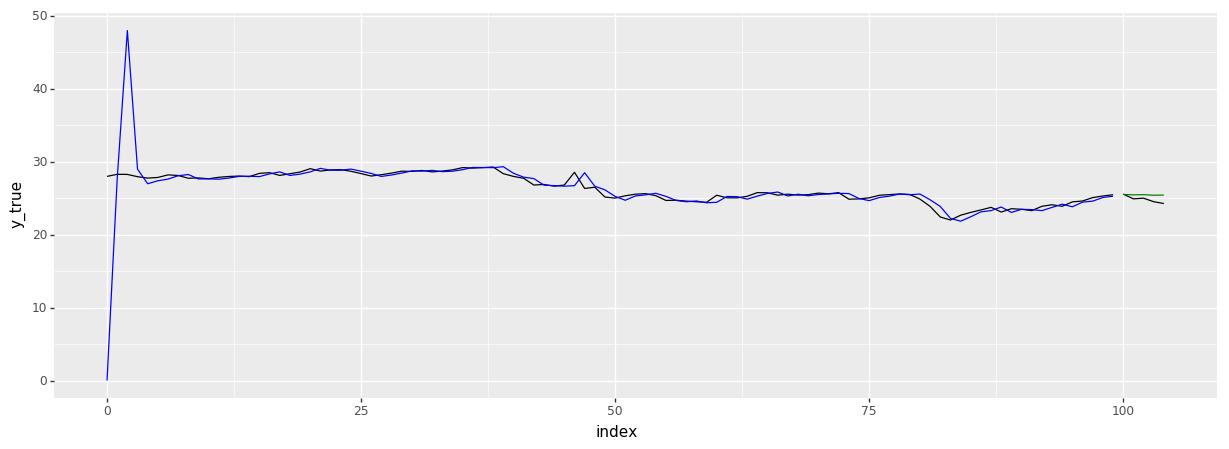

<ggplot: (144826056098)>

In [518]:
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True)

# Draft

0.002422230474518621
      Regressors Parameters         ERR
0        x1(k-2)     0.9000  0.95629559
1         y(k-1)     0.2001  0.04024104
2  x1(k-1)y(k-1)     0.0999  0.00346006
3  x1(k-1)y(k-2)     0.0002  0.00000002


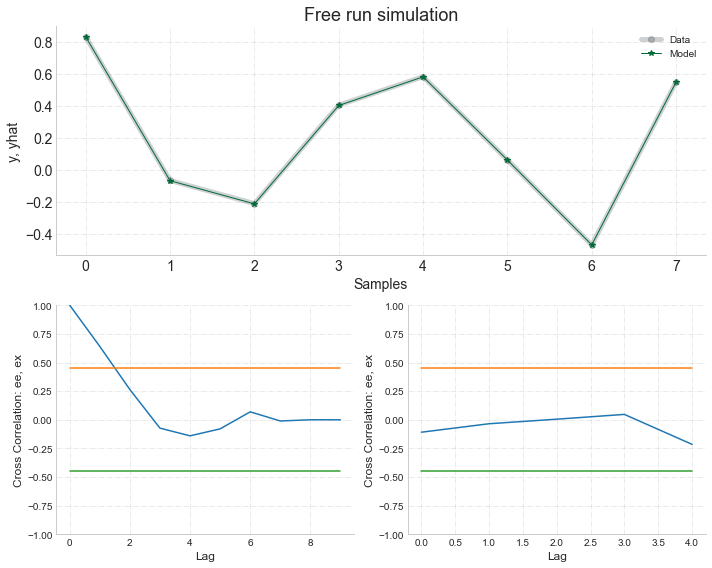

In [134]:
from sysidentpy.polynomial_basis import PolynomialNarmax
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data
x_train, x_valid_, y_train, y_valid_ = get_siso_data(n=1000,
                                                   colored_noise=False,
                                                   sigma=0.001,
                                                   train_percentage=90)
model = PolynomialNarmax(non_degree=2,
                         order_selection=True,
                         n_info_values=10,
                         extended_least_squares=False,
                         ylag=2, xlag=2,
                         info_criteria='aic',
                         estimator='least_squares',
                         )


x_valid = x_valid_[0:10,:]
y_valid = y_valid_[0:10,:]

# x_valid = x_train
# y_valid = y_train

model.fit(x_train, y_train)
yhat = model.predict(x_valid, y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)
results = pd.DataFrame(model.results(err_precision=8,
                                     dtype='dec'),
                       columns=['Regressors', 'Parameters', 'ERR'])

print(results)
ee, ex, extras, lam = model.residuals(x_valid, y_valid, yhat)
model.plot_result(y_valid, yhat, ee, ex)






In [320]:
ts    = ts
var_y = ['GM']
var_x = ['TM_Vol']
order = (2,1,2)
seasonal_order        = (0,1,0,2)
enforce_stationarity  = False
enforce_invertibility = False
max_iterations = 500
TS_idx = TS_idx
model_name    = 'SARIMAX_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S")

In [321]:
  # variables for loop over folds
pred_results = pd.DataFrame()
folds = list(TS_idx['train'].keys())

# loop over folds
for f in folds:
    # f = 1
    
    # indicies for training
    train_back_f_idx = TS_idx['train'][f]
    
    
    # DATA TRAIN BACK (no pred)
    
    # data set with y for training
    y_train_back_f     = ts.loc[train_back_f_idx['index'], var_y]
    y_train_back_f     = y_train_back_f.reset_index(drop = True)
    
    # data set with x for training
    if var_x is not None:
      x_train_back_f = ts.loc[train_back_f_idx['index'], var_x].astype(float) # bez zamiany na float f:sarimax.SARIMAX wyrzuca blad
      x_train_back_f = x_train_back_f.reset_index(drop = True)
    else:
      x_train_back_f = None
    
    
    # prepading variable with dates (without it SARIMAX may cause problems)
    if var_x is not None:
      x_train_back_f_fit = x_train_back_f
      y_train_back_f_fit = y_train_back_f
      
      x_train_back_f_fit.index = [date.fromordinal(datetime.datetime(1900, 1, 1).toordinal() + x - 2) for x in x_train_back_f_fit.index ]
      y_train_back_f_fit.index = [date.fromordinal(datetime.datetime(1900, 1, 1).toordinal() + x - 2) for x in y_train_back_f_fit.index ]
    else : 
      x_train_back_f_fit = x_train_back_f
      y_train_back_f_fit = y_train_back_f
    
    print(x_train_back_f_fit.head)
    
    # model fitting
    model_f = stm.tsa.statespace.sarimax.SARIMAX( endog = y_train_back_f_fit
                                                , order = order
                                                , seasonal_order = seasonal_order
                                                , exog = None # x_train_back_f_fit
                                                , enforce_stationarity = enforce_stationarity
                                                , enforce_invertibility = enforce_invertibility
                                                )
    # start_params=[0,0.1,0,0.1,0.1] # ilosc parametrow do parametry rozne od zera dla AR i MA w orede i seasona order. Parametry dla stopnia roznicowania szerewow nie tworza dodaktowych parametrow potrzebnych do estymacji
    model_fit_f = model_f.fit(maxiter=max_iterations, method=fit_method)
    
    
    
    # PREDICIONTS TRAIN
    
    # prediction back (fitted values)
    PRED_train_back_f = model_fit_f.fittedvalues # equivalent of : model_back_fit_f.predict(start = 0, end=len(y_back_f_i)-1)
    PRED_train_back_f = PRED_train_back_f.reset_index(drop = True)
    y_train_back_f = y_train_back_f.reset_index(drop=True)
    TRUE_PRED_train_back_f = pd.concat([y_train_back_f, PRED_train_back_f], axis = 1)
    TRUE_PRED_train_back_f.columns = ['y_true', 'y_pred']
    TRUE_PRED_train_back_f['if_pred']   = 0
    TRUE_PRED_train_back_f['test']      = 0
    TRUE_PRED_train_back_f['index']     = train_back_f_idx['index']
    TRUE_PRED_train_back_f['index_rel'] = train_back_f_idx['index_rel']
    TRUE_PRED_train_back_f['index_rel_shift'] = np.nan # train nie posiada informacji o index_rel_shift
    TRUE_PRED_train_back_f['date']      = train_back_f_idx['date']
    
    # prediction pred
    TRUE_PRED_train_pred_f = pd.DataFrame() # not calculated
    
    # concat of prediction from back and pred
    TRUE_PRED_train_f = pd.concat([TRUE_PRED_train_back_f, TRUE_PRED_train_pred_f])
    
    # additional identifiers
    TRUE_PRED_train_f['pred_nr'] = 1 # bo jest tylko jeden zbior (numeracja od 1)
    TRUE_PRED_train_f['model']   = model_name
    TRUE_PRED_train_f['fold']    = f
    
    pred_results = pd.concat([pred_results, TRUE_PRED_train_f])
  
    
    # rolling prediction
    for i in range(1 ,len(TS_idx['test_back_pred'][f]) + 1 ):
      # i = 1
      
      # indicies for back and pred
      test_back_pred_f_i_idx = TS_idx['test_back_pred'][f][i]
      
      # indicies for back
      test_back_f_i_idx = test_back_pred_f_i_idx[test_back_pred_f_i_idx['pred']==0]
      
      # data set with y for back
      y_test_back_f_i = ts.loc[test_back_f_i_idx['index'] , var_y]
      y_test_back_f_i = y_test_back_f_i.reset_index(drop = True)
      
      # data set with x for back
      if var_x is not None:
        x_test_back_f_i   = ts.loc[test_back_f_i_idx['index'] , var_x]
        x_test_back_f_i   = x_test_back_f_i.reset_index(drop = True)
      else:
        x_test_back_f_i = None
      
      # indicies for pred
      test_pred_f_i_idx = test_back_pred_f_i_idx[test_back_pred_f_i_idx['pred']==1]  
      
      # data set with y for pred
      y_test_pred_f_i = ts.loc[test_pred_f_i_idx['index'] , var_y]
      y_test_pred_f_i = y_test_pred_f_i.reset_index(drop = True)
      
      # data set with x for pred
      if var_x is not None:
        x_test_pred_f_i = ts.loc[test_pred_f_i_idx['index'] , var_x]
        x_test_pred_f_i = x_test_pred_f_i.reset_index(drop = True)
      else:
        x_test_pred_f_i = None
      
      # prepading variable with dates (without it SARIMAX may cause problems)
      if var_x is not None:
        x_test_back_f_i_fit = copy.deepcopy(x_test_back_f_i)
        y_test_back_f_i_fit = copy.deepcopy(y_test_back_f_i)
        x_test_pred_f_i_fit = copy.deepcopy(x_test_pred_f_i)
        
        x_test_back_f_i_fit.index = [date.fromordinal(datetime.datetime(1900, 1, 1).toordinal() + x - 2) for x in x_test_back_f_i_fit.index ]
        y_test_back_f_i_fit.index = [date.fromordinal(datetime.datetime(1900, 1, 1).toordinal() + x - 2) for x in y_test_back_f_i_fit.index ]
        x_test_pred_f_i_fit.index = [date.fromordinal(datetime.datetime(1900, 1, 1).toordinal() + x - 2) for x in x_test_pred_f_i_fit.index ]
      else : 
        x_test_back_f_i_fit = x_test_back_f_i
        y_test_back_f_i_fit = y_test_back_f_i
        x_test_pred_f_i_fit = x_test_pred_f_i
      
      # data back recalculation
      model_f_i = stm.tsa.statespace.sarimax.SARIMAX( endog                 = y_test_back_f_i_fit
                                                    , order                 = order
                                                    , seasonal_order        = seasonal_order
                                                    , exog                  = None # x_test_back_f_i_fit
                                                    , enforce_stationarity  = enforce_stationarity
                                                    , enforce_invertibility = enforce_invertibility)
      model_fit_f_i = model_f_i.smooth(model_fit_f.params)
      
      # prediction back (fitted values)
      PRED_test_back_f_i = model_fit_f_i.fittedvalues # equivalent of : model_back_fit_f_i.predict(start = 0, end=len(y_back_f_i)-1)
      PRED_test_back_f_i = PRED_test_back_f_i.reset_index(drop = True)
      TRUE_PRED_test_back_f_i = pd.DataFrame({'y_true':y_test_back_f_i, 'y_pred':PRED_test_back_f_i})
      TRUE_PRED_test_back_f_i['if_pred']   = 0
      TRUE_PRED_test_back_f_i['test']      = 1
      TRUE_PRED_test_back_f_i['index']     = test_back_f_i_idx['index']
      TRUE_PRED_test_back_f_i['index_rel'] = test_back_f_i_idx['index_rel']
      TRUE_PRED_test_back_f_i['index_rel_shift'] = test_back_f_i_idx['index_rel_shift']
      TRUE_PRED_test_back_f_i['date']      = test_back_f_i_idx['date']
      
      # prediction pred
      PRED_test_pred_f_i  = model_fit_f_i.predict(start=len(y_test_back_f_i), end=len(y_test_back_f_i) + len(y_test_pred_f_i) - 1)
      PRED_test_pred_f_i  = PRED_test_pred_f_i.reset_index(drop = True)
      TRUE_PRED_test_pred_f_i = pd.DataFrame({'y_true':y_test_pred_f_i, 'y_pred':PRED_test_pred_f_i})
      TRUE_PRED_test_pred_f_i['if_pred']   = 1
      TRUE_PRED_test_pred_f_i['test']      = 1
      TRUE_PRED_test_pred_f_i['index']     = test_pred_f_i_idx['index']
      TRUE_PRED_test_pred_f_i['index_rel'] = test_pred_f_i_idx['index_rel']
      TRUE_PRED_test_pred_f_i['index_rel_shift'] = test_pred_f_i_idx['index_rel_shift']
      TRUE_PRED_test_pred_f_i['date']      = test_pred_f_i_idx['date']
      
      # concat of prediction from back and pred
      TRUE_PRED_test_f_i = pd.concat([TRUE_PRED_test_back_f_i, TRUE_PRED_test_pred_f_i], axis = 0)
      
      # additional identifiers
      TRUE_PRED_test_f_i['pred_nr'] = i # 'pred_nr' to ktora prognoza (w jednym foldzie moze byc kilka prognoz)
      TRUE_PRED_test_f_i['model']   = model_name
      TRUE_PRED_test_f_i['fold']    = f
      
      
      # collecting results 
      pred_results = pd.concat([pred_results, TRUE_PRED_test_f_i])
      
    print(f)
    # printing information about fitted model parameter.
    print(model_fit_f.params)

# error calculation
pred_results['error'] = pred_results['y_true'] - pred_results['y_pred']
pred_results

<bound method NDFrame.head of                   TM_Vol
1899-12-30  1.720000e+05
1899-12-31  2.661000e+05
1900-01-01  3.225000e+05
1900-01-02  2.085000e+05
1900-01-03  3.194000e+05
1900-01-04  7.567000e+05
1900-01-05  5.794000e+05
1900-01-06  3.597000e+05
1900-01-07  1.504000e+05
1900-01-08  1.777000e+05
1900-01-09  1.413000e+05
1900-01-10  2.237000e+05
1900-01-11  1.210000e+05
1900-01-12  1.419000e+05
1900-01-13  2.028000e+05
1900-01-14  4.490000e+05
1900-01-15  2.932000e+05
1900-01-16  2.470000e+05
1900-01-17  2.200000e+05
1900-01-18  3.106000e+05
1900-01-19  2.801000e+05
1900-01-20  2.759000e+05
1900-01-21  2.403000e+05
1900-01-22  2.310000e+05
1900-01-23  1.672000e+05
1900-01-24  3.049000e+05
1900-01-25  2.363000e+05
1900-01-26  1.662000e+05
1900-01-27  1.526000e+05
1900-01-28  1.914000e+05
1900-01-29  2.927000e+05
1900-01-30  1.792000e+05
1900-01-31  3.449000e+05
1900-02-01  2.463000e+05
1900-02-02  1.798000e+05
1900-02-03  2.631000e+05
1900-02-04  2.705000e+05
1900-02-05  1.490000

C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\memy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


NameError: name 'fit_method' is not defined

In [357]:

PRED_train_back_f = PRED_train_back_f.reset_index(drop = True)
y_train_back_f = y_train_back_f.reset_index(drop=True)

pd.concat([y_train_back_f, PRED_train_back_f ], axis = 1)


GM          0
0   28.268686   0.000000
1   27.957256  27.780427
2   27.765604  46.845228
3   27.853445  28.045303
4   28.204802  27.622263
5   28.124952  28.252067
6   27.741644  28.200983
7   27.789560  27.766574
8   27.669775  27.702446
9   27.877396  27.689145
10  27.989191  27.773883
11  28.045097  28.043498
12  27.965237  27.993317
13  28.412426  28.029467
14  28.508249  28.334714
15  28.057071  28.627947
16  28.364513  28.051763
17  28.596104  28.389268
18  29.059250  28.595019
19  28.723860  29.103156
20  28.891556  28.804492
21  28.923498  28.907209
22  28.699903  28.993099
23  28.380482  28.738478
24  28.045097  28.440746
25  28.230667  28.056206
26  28.448505  28.231388
27  28.714758  28.446652
28  28.682484  28.729314
29  28.811571  28.714420
30  28.609867  28.829249
31  28.730898  28.657233
32  28.892263  28.733912
33  29.206917  28.925677
34  29.134300  29.210649
35  29.198845  29.197899
36  29.287598  29.210467
37  28.367821  29.342269
38  27.996685  28.435269
39  27.738503  28.018712
40  26.810654  27.747465
41  26.891342  26.848509
42  26.657364  26.834475
43  26.810654  26.662253
44  28.561458  26.743258
45  26.342701  28.470567
46  26.512136  26.486012
47  25.164743  26.400682
48  25.019516  25.260288
49  25.334173  24.872782
50  25.560087  25.332748
51  25.632704  25.417384
52  25.358381  25.653814
53  24.696789  25.249641
54  24.729061  24.743385
55  24.608038  24.581381
56  24.519287  24.626839
57  24.446671  24.380191
58  25.414860  24.458819
59  25.059858  25.223436
60  25.051785  25.122226
61  25.269629  24.904622
62  25.777925  25.297563
63  25.745657  25.617546
64  25.422928  25.803315
65  25.560087  25.309149
66  25.430998  25.595028
67  25.495539  25.315447
68  25.705313  25.529733
69  25.608494  25.577476
70  25.769861  25.657044
71  24.874289  25.645046
72  24.906559  24.967364
73  25.059858  24.764466
74  25.406788  25.096568
75  25.503607  25.259145
76  25.584288  25.552394
77  25.519747  25.456909
78  24.882351  25.577084
79  23.881895  24.793461
80  22.429617  23.968175
81  22.010075  22.357339
82  22.671665  22.025784
83  23.058935  22.482574
84  23.397806  23.053746
85  23.752806  23.241454
86  23.107349  23.756686
87  23.567234  23.014113
88  23.486559  23.548152
89  23.300987  23.377178
90  23.895343  23.315330
91  24.107805  23.747664
92  23.898033  24.116060
93  24.502430  23.801000
94  24.624937  24.483656
95  25.090485  24.526888
96  25.311005  25.082713
97  25.482525  25.219525
98  25.572367  25.494981
99  24.918970  25.492418

C:\Users\memy\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\memy\Anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


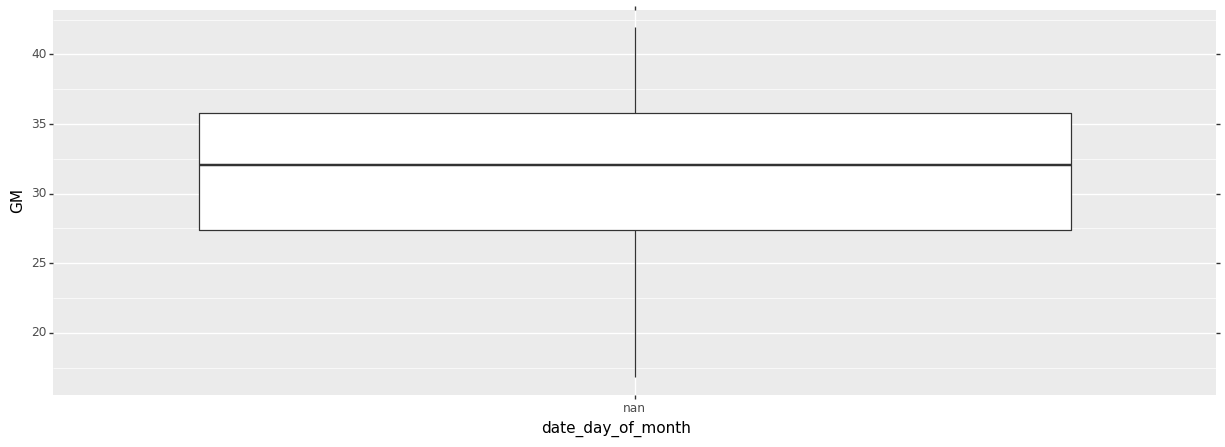

<ggplot: (153587452378)>

In [125]:
ts_2=ts.copy()
var_y='GM'
var_group_x = 'date_day_of_month'
var_group_facet_y = None
fig_w = 15; fig_h = 5


plotnine.options.figure_size = (fig_w, fig_h)
bins = ts_2[var_group_x].astype(int).sort_values()
# bins = bins.astype(str)
bins = bins.drop_duplicates()
ts_2[var_group_x] = pd.Categorical(ts_2[var_group_x], categories=bins,    ordered=True)
if var_group_facet_y is not None:
    ts_2[var_group_facet_y] = ts_2[var_group_facet_y].astype('str')
    ggplot(data = ts_2) + geom_boxplot(aes(x=var_group_x, y=var_y)) + facet_grid(facets=var_group_facet_y+'~.')
else:
    ggplot(data = ts_2) + geom_boxplot(aes(x=var_group_x, y=var_y))


    

In [102]:
%run "modules\\data_analysis"



stats                                              value
0  Ljung-Box Q-statistic  [13.544179476568964, 15.886610162978874, 15.95...
1                p-value  [0.00023301292309748232, 0.0003550311302496335...

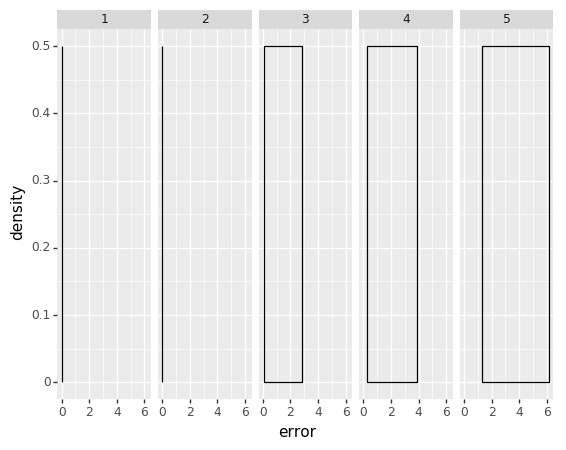

<ggplot: (161790468279)>

In [423]:
data_results = res
test  = 1
error = 'error'
fold  = 1

if fold is None:
    plot_data_pred = data_results.loc[  (data_results['test']==test) 
                                      & (data_results['if_pred']==1)
                                      , ['index_rel', 'date', error]]
else:
    plot_data_pred = data_results.loc[  (data_results['fold']==fold) 
                                      & (data_results['test']==test) 
                                      & (data_results['if_pred']==1)
                                      , ['index_rel', 'date', error]]

ggplot(data=plot_data_pred) + geom_density(aes(x=error)) + facet_grid(facets='.~index_rel')

# draft indicies

In [5]:
# # PARAMETERS


input_len_f  = 5
features_n_f = 1
output_len_f = pred_len





# PARAMETERS (parametry rozne of defaultowych ustawien)
fold_n         = 3                 # ilosc foldow (ile razy bedzie uczenie modelu)
fold_shift     = pred_len * pred_n # przesuniecie folda (co jaki okres bedzie uczenie modelu)

train_len_min  = 100           # 
test_len_min   = input_len_f + pred_len * pred_n
train_test_gap = -test_len_min + 1 # test zachodzi o jeden zbior back na train-a

train_back_len_min = input_len_f 
test_back_len_min  = input_len_f 

train_pred_len = output_len_f
test_pred_len  = output_len_f



# INDICIES
TS_idx = TS_indicies( # ARGUMENTS
  
  # general
   ts          = ts     # szereg czasowy
  ,start_point = 0      # indeks pierwszej obserwacji
  ,var_date    = 'date' # nazwa kolumny z datą
  
  # fold
  ,fold_n     = fold_n      # ilosc foldow
  ,fold_shift = fold_shift  # przesuniecie miedzy kolejnymi foldami
  
  # train_test 
  ,train_len_min     = train_len_min  # minimalna długosc calego traina.  Jezeli train_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,train_fixed_start = False          # czy punkt startowy dla traina pommiedzy foldami jest staly
  ,test_len_min      = test_len_min   # minimalna długosc calego testu.  Jezeli test_fixed_start = False to jest to stala wartosc dla kazdego folda
  ,test_fixed_start  = False          # czy punkt startowy dla testu pommiedzy foldami jest staly. Mozna uzywac nawet gdy train_fixed_start = False
  ,train_test_gap    = -train_len_min + 1 # przerwa miedzy train-me i test-em. Ma znaczenie tylko kiedy test_fixed_start = False
  
  # train
  ,train_back_len_min    = train_back_len_min # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,train_pred_len        = train_pred_len     # dlugosc pred-a dla kazdej rekalkulacji w foldzie. 
  ,train_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,train_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,train_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  
  # test
  ,test_back_len_min    = test_back_len_min  # Minimalna dlugosc back w train w w kazdej rekalkulacji w foldzie. Jezeli train_back_pred_fixed_start = True to jest to wielkosc stala dla kazdege back w foldzie.
  ,test_pred_len        = test_pred_len      # Dlugosc calego pred-a dla kazdej rekalkulacji w foldzie. 
  ,test_back_pred_shift = pred_len           # Przesuniecie pary back i pred pomiedzy rekalkulacjami  w foldzie
  ,test_back_pred_gap   = 1                  # Przerwa miedzy back i pred dla kadej rekalkulacji w foldzie
  ,test_back_pred_fixed_start = False        # Czy staly dla back w ramach rekalkulacji po foldzie punkt startu. Jest to opcja niezalezna od train_fixed_start
  )







# # INDICIES
# TS_idx = TS_indicies( ts = ts
#                   ,var_date = 'date'
#                   #
#                   ,fold_n      = 3
#                   ,fold_shift  = 10
#                   #
#                   ,train_len   = 1000
#                   ,test_len    = 10
#                   ,train_test_shift = 1
#                   #
#                   ,train_back_len = input_len_f # brane tylko do odliczania index_rel_shift wzgledem back
#                   ,train_pred_len = output_len_f 
#                   ,train_shift    = 1 # zazwyczaj na train daje co jeden zeby model mial wiecel obserwacji do wytrenowania
#                   ,train_back_pred_shift = 1 # zazwyczaj jeden
#                   #
#                   ,test_back_len = input_len_f # brane tylko do odliczania index_rel_shift wzgledem back
#                   ,test_pred_len = output_len_f
#                   ,test_shift    = output_len_f # zazwyczaj na test daje tak aby prognozy sie nie pokrywaly (test_pred_len = test_shift)
#                   ,test_back_pred_shift = 1 # zazwyczaj jeden
#                   #
#                   ,move_fold_start_point = True
#                   ,start_point = 0)

# MODEL
# 'lstm_vanilia'
model = keras.Sequential()
model.add(keras.layers.LSTM(100, activation='relu', input_shape = ( input_len_f, features_n_f ) ))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(output_len_f))
model.compile(loss='mse', optimizer='adam')


res = NN_n1_n1( ts = ts
  , var_y = [ts_var_1] #scalar no list !!!
  , var_x = [ts_var_1]
  , TS_idx = TS_idx
  , epochs = 200
  , batch_size = 20
  , model_type = 'lstm_vanilia'
  , model = model
  , model_name = 'LSTM_' + datetime.datetime.now().strftime("%m_%d_%Y___%H_%M_%S"))



# VISUALISATION

# not aggregated results
h("recal + pred for test for given fold and pred_nr")
plot_ts_fold_pred_nr(data_results = res, fold = 1, pred_nr = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("only pred for test for given fold")
plot_ts_fold_pred(data_results = res, fold = 1, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("all pred for test")
plot_ts_pred(data_results = res, plot_index = True, fig_w=fig_w, fig_h=fig_h)
h("density plot of errors for all pred for test")
plot_density_error_pred_n(data_results = res, fold = None, fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test")
plot_metrics_pred(data_results = res)


# not aggregated residuals diagnostics
h('Arch test')
test_HET_ARCH(res)
h('Ljung box autocorrelation test')
test_LJUNG(res)
h('BDS test')

# aggregated results
res_clean = results_cleaning_pred(results = res, aggr_grupby = [], start_obs = 0, aggr_unit = aggregation, aggr_num = 1, remove_holidays = False)
h("all pred for test (aggregated)")
plot_pred_aggreg(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("error of all pred for test (aggregated)")
plot_pred_aggreg_error(data = res_clean[1], fig_w=fig_w, fig_h=fig_h)
h("table with metrics for all pred for test (aggregated)")
res_clean[2]


NameError: name 'pred_len' is not defined